In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import app, Sort, reviews_all,reviews

In [2]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words_list import stop_words_list
from wn_affect import wn_affect 
import matplotlib.pyplot as plt


In [3]:
#len(d)

In [4]:
#df4 = pd.DataFrame(d)

In [5]:
#df4["App Name"]="IMO"

In [6]:
#df4.to_csv("IMO.csv")

In [7]:
#dataF=dataF.append(df4,ignore_index = True) 

In [8]:
data1=pd.read_csv("Skype.csv")
data2=pd.read_csv("Whatsapp.csv")
data3=pd.read_csv("IMO.csv")
data4=pd.read_csv("Telegram.csv")
data5=pd.read_csv("wechat.csv")

In [9]:
data=data1.append(data2,ignore_index = True) 
data=data.append(data3,ignore_index = True) 
data=data.append(data4,ignore_index = True) 
data=data.append(data5,ignore_index = True) 

In [10]:
len(data)

50000

In [11]:
from collections import Counter
Counter(data["App Name"])

Counter({'Skype': 10000,
         'Whatsapp': 10000,
         'IMO': 10000,
         'Telegram': 10000,
         'Wechat': 10000})

# Topic Modeling Sentiment

In [12]:
df=data

In [13]:
df[:2]

Unnamed: 0                                           reviewId  userName  \
0           0  gp:AOqpTOGEZYy-BlqAMREMFe6nf-YyiPfvtB3YI2XOo8c...  J Steele   
1           1  gp:AOqpTOFRK-4r3CFo22QviGRzqs3m9gVsEem5NIqq8Uj...      Jess   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a/AATXAJ...   
1  https://play-lh.googleusercontent.com/a-/AOh14...   

                                             content  score  thumbsUpCount  \
0  Suddenly can not send media through my phone, ...      1             26   
1  Skype has gone way down hill. The makers of th...      1             45   

  reviewCreatedVersion                   at replyContent repliedAt App Name  
0           8.81.0.268  2022-03-16 05:50:06          NaN       NaN    Skype  
1           8.81.0.268  2022-03-16 06:46:15          NaN       NaN    Skype

In [14]:
#Preprocessing of text tweets to remove : Punction, Numbers, stropwords hash tages , links stemming, lematization


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english') and "amp"]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)


df['cleanText']=df['content'].map(lambda s:preprocess(s)) 

In [15]:
# initiate nltk lemmatiser
# initiate stopwords from nltk
df['remove_lower_punct'] = df['cleanText'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[13]), axis=1)

stop_words = stopwords.words('english')

# add additional missing terms

stop_words.extend(stop_words_list) 

# remove stopwords

df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])


wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 


C:\Users\SOHAIL~1\AppData\Local\Temp/ipykernel_8152/1911259254.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['remove_lower_punct'] = df['cleanText'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


In [16]:
Counter(df['sentiment'])

Counter({'Positive': 29196, 'Negative': 14279, 'Neutral': 6525})

In [17]:
# initialise the count vectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()                            
vectorised = vectorizer.fit_transform(df['cleanText'])

In [18]:
# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 10, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(2))

Unnamed: 0                                           reviewId  userName  \
0           0  gp:AOqpTOGEZYy-BlqAMREMFe6nf-YyiPfvtB3YI2XOo8c...  J Steele   
1           1  gp:AOqpTOFRK-4r3CFo22QviGRzqs3m9gVsEem5NIqq8Uj...      Jess   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a/AATXAJ...   
1  https://play-lh.googleusercontent.com/a-/AOh14...   

                                             content  score  thumbsUpCount  \
0  Suddenly can not send media through my phone, ...      1             26   
1  Skype has gone way down hill. The makers of th...      1             45   

  reviewCreatedVersion                   at replyContent  ... Topic2 Topic3  \
0           8.81.0.268  2022-03-16 05:50:06          NaN  ...    0.0   0.43   
1           8.81.0.268  2022-03-16 06:46:15          NaN  ...    0.0   0.00   

  Topic4 Topic5 Topic6  Topic7 Topic8 Topic9 Topic10  Dominant_topic  
0   0.19   0.00   0.09    0.00   0.27    0.0    0.00               3  
1   0.00   0.33   0.00    0.22   0.00    0.0    0.43              10  

[2 rows x 30 columns]

In [19]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


topic  relevance_score
___      Topic1         1.099941
______   Topic9         1.099906
_____p   Topic9         1.099948
__app    Topic7         1.099993
_and     Topic4         1.099898
...         ...              ...
𝙡𝙞𝙨𝙩𝙚𝙣   Topic5         1.100000
𝙧𝙚𝙖𝙙𝙞𝙣𝙜  Topic5         1.100000
𝙩𝙚𝙭𝙩     Topic5         2.100000
𝙩𝙝𝙖𝙩     Topic5         1.100000
𝙩𝙝𝙚      Topic5         1.100000

[19070 rows x 2 columns]

In [20]:
tmp.loc[tmp['topic'] == 'Topic10', 'topic'] = 10
tmp.loc[tmp['topic'] == 'Topic9', 'topic'] = 9
tmp.loc[tmp['topic'] == 'Topic8', 'topic'] = 8
tmp.loc[tmp['topic'] == 'Topic7', 'topic'] = 7
tmp.loc[tmp['topic'] == 'Topic6', 'topic'] = 6

tmp.loc[tmp['topic'] == 'Topic5', 'topic'] = 5
tmp.loc[tmp['topic'] == 'Topic4', 'topic'] = 4
tmp.loc[tmp['topic'] == 'Topic3', 'topic'] = 3
tmp.loc[tmp['topic'] == 'Topic2', 'topic'] = 2
tmp.loc[tmp['topic'] == 'Topic1', 'topic'] = 1

In [21]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] 
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

Dominant_topic topic_name
0               1   [number]
1               9   [please]
2               7  [working]
3               4    [video]
4               2  [contact]
5               8  [message]
6               3  [account]
7               5      [app]
8              10     [call]
9               6   [update]

In [25]:
df["Dominant_topic"].replace({3: "account",4: "video", 5: "app",6: "update",7: "working",8: "message",10: "call"}, inplace=True)

In [26]:
from collections import Counter
Counter(df['Dominant_topic'])

Counter({'account': 7882,
         'call': 5057,
         'working': 5629,
         'video': 5791,
         'update': 3884,
         'app': 9909,
         'message': 2940,
         1: 3621,
         9: 2951,
         2: 2336})

In [27]:
df = df[df.Dominant_topic != 1]
df = df[df.Dominant_topic != 9]
df = df[df.Dominant_topic != 2]

In [28]:
df.to_csv("DataAPPCALL.csv")

In [22]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()
results = results[results.Dominant_topic != 1]
results = results[results.Dominant_topic != 9]
results = results[results.Dominant_topic != 2]

results = results.merge(all_topics, on='Dominant_topic')
results['Topic Name'] = results['topic_name'].apply(', '.join)

graph_results = results[['Topic Name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Topic Name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Topic Name', inplace=True)

display(graph_results)

sentiment   Negative  Neutral  Positive
Topic Name                             
account         4199      817      2866
app              341      278      9290
call            1922      816      2319
message          628      368      1944
update          1549     1023      1312
video           1110      663      4018
working         1867     1082      2680

In [23]:
df

Unnamed: 0                                           reviewId  \
0               0  gp:AOqpTOGEZYy-BlqAMREMFe6nf-YyiPfvtB3YI2XOo8c...   
1               1  gp:AOqpTOFRK-4r3CFo22QviGRzqs3m9gVsEem5NIqq8Uj...   
2               2  gp:AOqpTOHQsNYtHGx4O-qkWdAfXPz5gTAocesMy5rb8E6...   
3               3  gp:AOqpTOGU2W7Yo__DD-IvhTfBfuVL32NUtnMJXB7mgUm...   
4               4  gp:AOqpTOH3046rnC6z2oO1zRb2L188gJlG5-iClefb1Ls...   
...           ...                                                ...   
49995        9995  gp:AOqpTOGoHxslcqvNhhrwfL2hZ4etjg41PZxEae7_wM2...   
49996        9996  gp:AOqpTOFZmG8UKSri5WQRRx8zJ2fXqATduIs6Z1Rmebq...   
49997        9997  gp:AOqpTOFW67aMOPdZAMS9B9vVFnyMrZrqPMzY-3PA-aw...   
49998        9998  gp:AOqpTOGDXUsEvkOcQ1Ax2FfzuhSsrm-qXKJxKoG7fFg...   
49999        9999  gp:AOqpTOHIzWD0_WaDsNTedgjMWdpBB4gLa6jfLQb_FD0...   

              userName                                          userImage  \
0             J Steele  https://play-lh.googleusercontent.com/a/AATXAJ...   
1                 Jess  https://play-lh.googleusercontent.com/a-/AOh14...   
2      Jessica Rinaldi  https://play-lh.googleusercontent.com/a-/AOh14...   
3          Steve Paige  https://play-lh.googleusercontent.com/a-/AOh14...   
4         Judith Smith  https://play-lh.googleusercontent.com/a/AATXAJ...   
...                ...                                                ...   
49995            Tomas  https://play-lh.googleusercontent.com/a/AATXAJ...   
49996         J.F. Lin  https://play-lh.googleusercontent.com/a-/AOh14...   
49997    Asmita Shetty  https://play-lh.googleusercontent.com/a-/AOh14...   
49998           WHAT ?  https://play-lh.googleusercontent.com/a-/AOh14...   
49999          Jeff TJ  https://play-lh.googleusercontent.com/a-/AOh14...   

                                                 content  score  \
0      Suddenly can not send media through my phone, ...      1   
1      Skype has gone way down hill. The makers of th...      1   
2      Stopped working out of nowhere last week. Lite...      1   
3      I have a Chrome Box. Skype used to open by its...      1   
4      Can't send text messages at all. It just keeps...      1   
...                                                  ...    ...   
49995  Help a friend thing before I can even use the ...      1   
49996  I cant get back into my account and all the pa...      1   
49997  Disgusting app.. To register they asking for y...      1   
49998  I have been trying again and again to sign up....      2   
49999            Can't login and a waste of time trying.      1   

       thumbsUpCount reviewCreatedVersion                   at replyContent  \
0                 26           8.81.0.268  2022-03-16 05:50:06          NaN   
1                 45           8.81.0.268  2022-03-16 06:46:15          NaN   
2                 84           8.81.0.268  2022-03-04 05:18:22          NaN   
3                  1           8.81.0.268  2022-03-16 19:53:39          NaN   
4                 17           8.81.0.268  2022-03-15 10:00:48          NaN   
...              ...                  ...                  ...          ...   
49995              1               7.0.17  2020-09-19 20:09:05          NaN   
49996              0                  5.0  2019-03-08 04:41:44          NaN   
49997              0               7.0.13  2020-06-13 22:46:18          NaN   
49998              0                  NaN  2021-10-19 13:08:29          NaN   
49999              0               6.5.16  2020-08-11 10:38:13          NaN   

       ... Topic2 Topic3 Topic4 Topic5 Topic6  Topic7 Topic8 Topic9 Topic10  \
0      ...   0.00   0.43   0.19   0.00   0.09    0.00   0.27   0.00    0.00   
1      ...   0.00   0.00   0.00   0.33   0.00    0.22   0.00   0.00    0.43   
2      ...   0.00   0.09   0.00   0.00   0.26    0.51   0.00   0.00    0.08   
3      ...   0.12   0.00   0.00   0.00   0.23    0.00   0.07   0.00    0.56   
4      ...   0.00   0.00   0.00   0.00   0.21    0.54   0.22   0.00 

In [119]:
df["App Name"].value_counts()

Skype       10000
Whatsapp    10000
IMO         10000
Telegram    10000
Wechat      10000
Name: App Name, dtype: int64

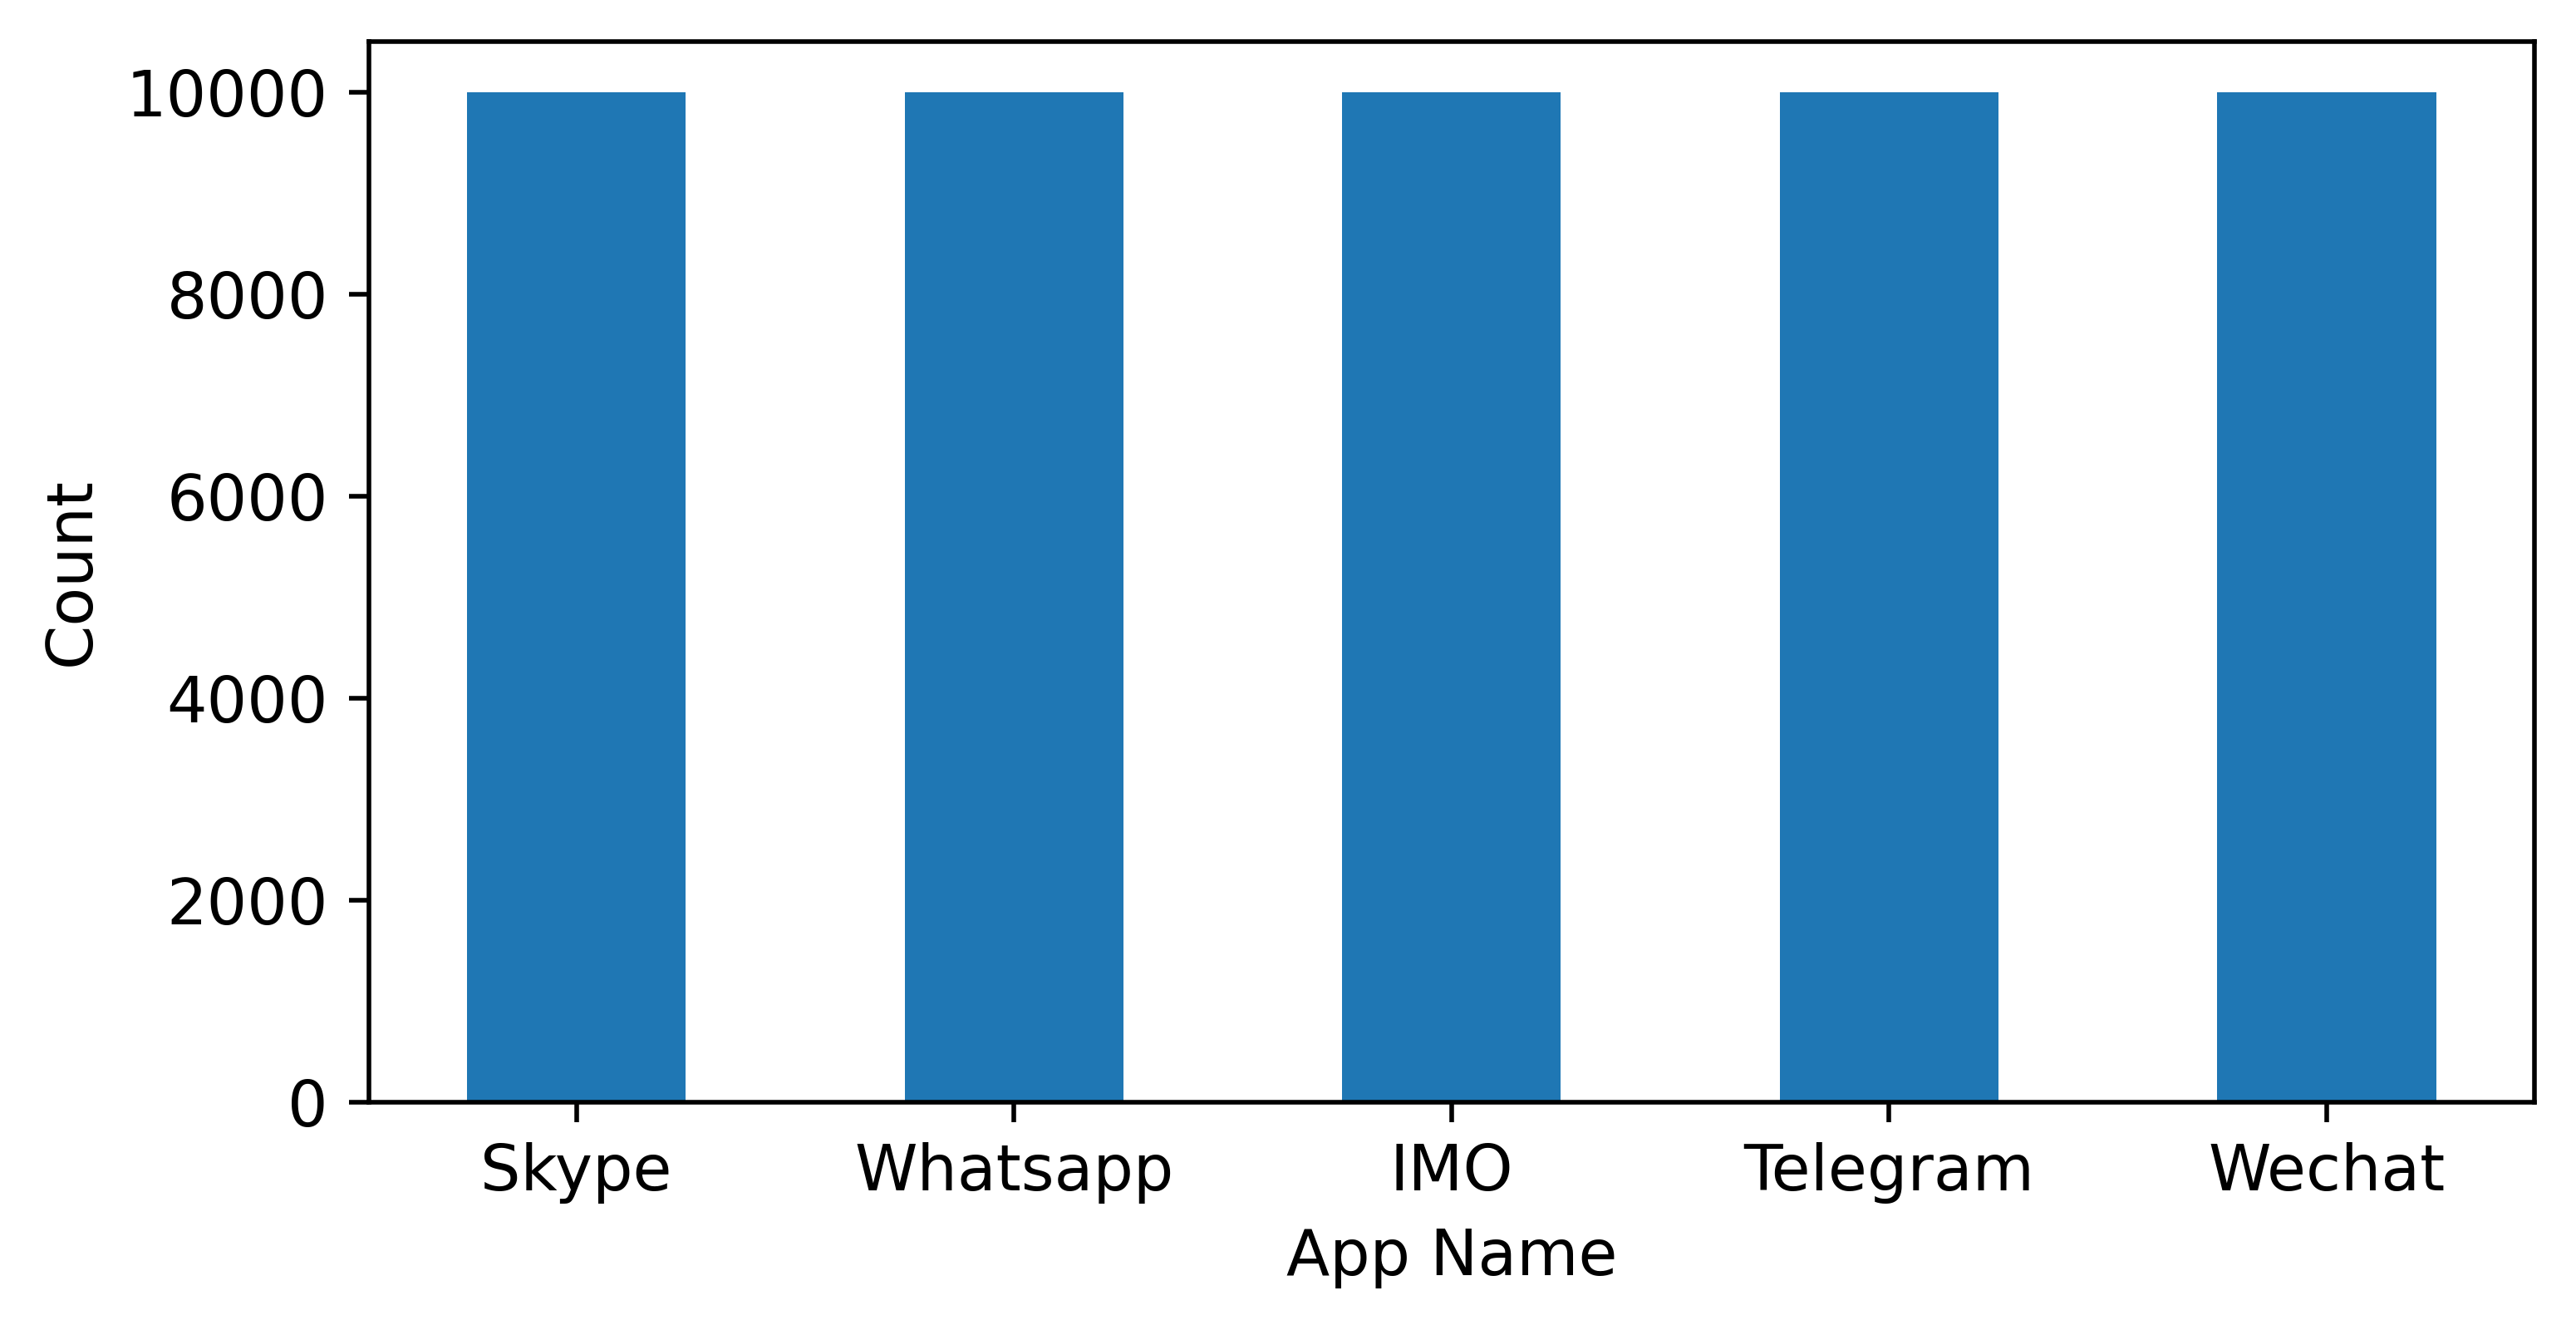

In [120]:
# library
import matplotlib.pyplot as plt
plt.figure(1,figsize=(6, 3),dpi=500)
# create dataset
height = [10000, 10000, 10000, 10000, 10000]
bars = ('Skype', 'Whatsapp', 'IMO', 'Telegram', 'Wechat')

# Choose the width of each bar and their positions
width = [0.05,0.05,0.05,0.05,0.05]
x_pos = [0.2,0.3,0.4,0.5,0.6]
plt.rcParams['font.size'] = '11' 
# Make the plot
plt.bar(x_pos, height, width=width)

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.xlabel('App Name', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.tight_layout(pad=0) 
# Show graphic

plt.savefig('New_All_App_name_count.pdf')
plt.show()

In [121]:
df["sentiment"].value_counts()

Positive    29196
Negative    14279
Neutral      6525
Name: sentiment, dtype: int64

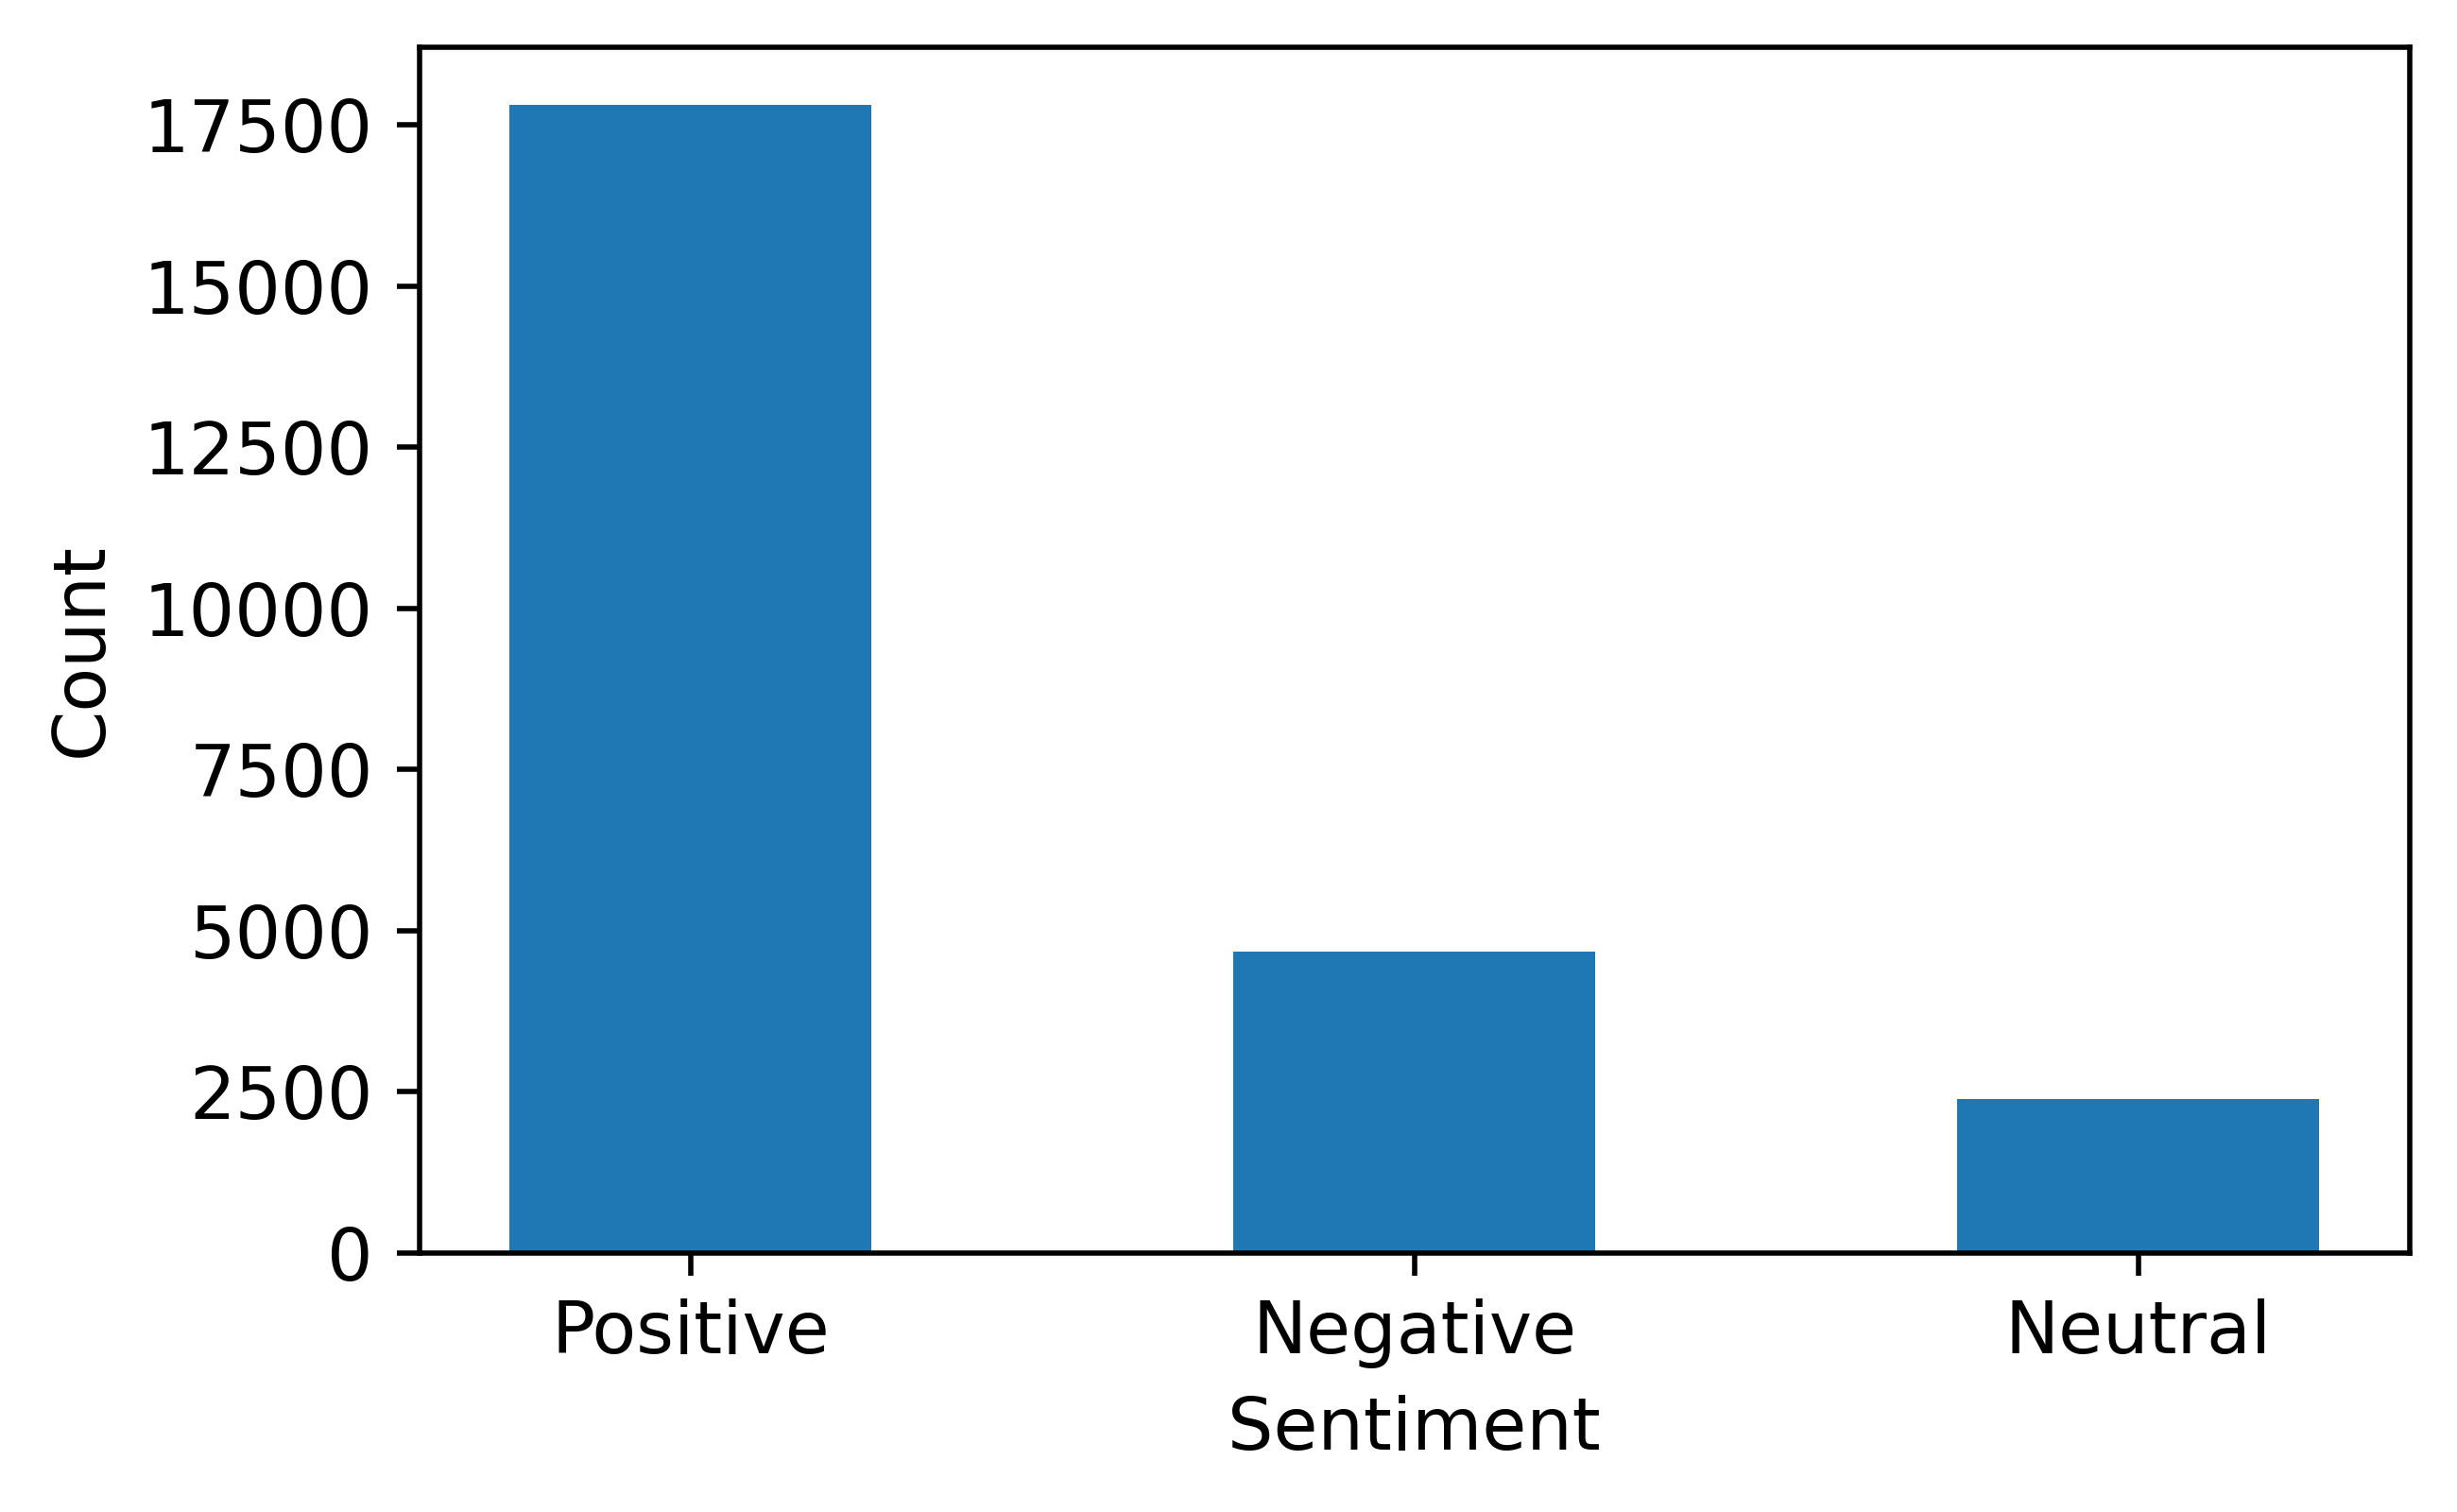

In [122]:
# library
import matplotlib.pyplot as plt
plt.figure(1,figsize=(5, 3),dpi=500)
# create dataset
height = [17816, 4670, 2389]
bars = ('Positive', 'Negative', 'Neutral')

# Choose the width of each bar and their positions
width = [0.05,0.05,0.05]
x_pos = [0.2,0.3,0.4]
plt.rcParams['font.size'] = '11' 
# Make the plot
plt.bar(x_pos, height, width=width)

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.xlabel('Sentiment', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.tight_layout(pad=0) 
# Show graphic

plt.savefig('New_All_App_Sentiment_count.pdf')
plt.show()

C:\Users\Sohail_Comp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


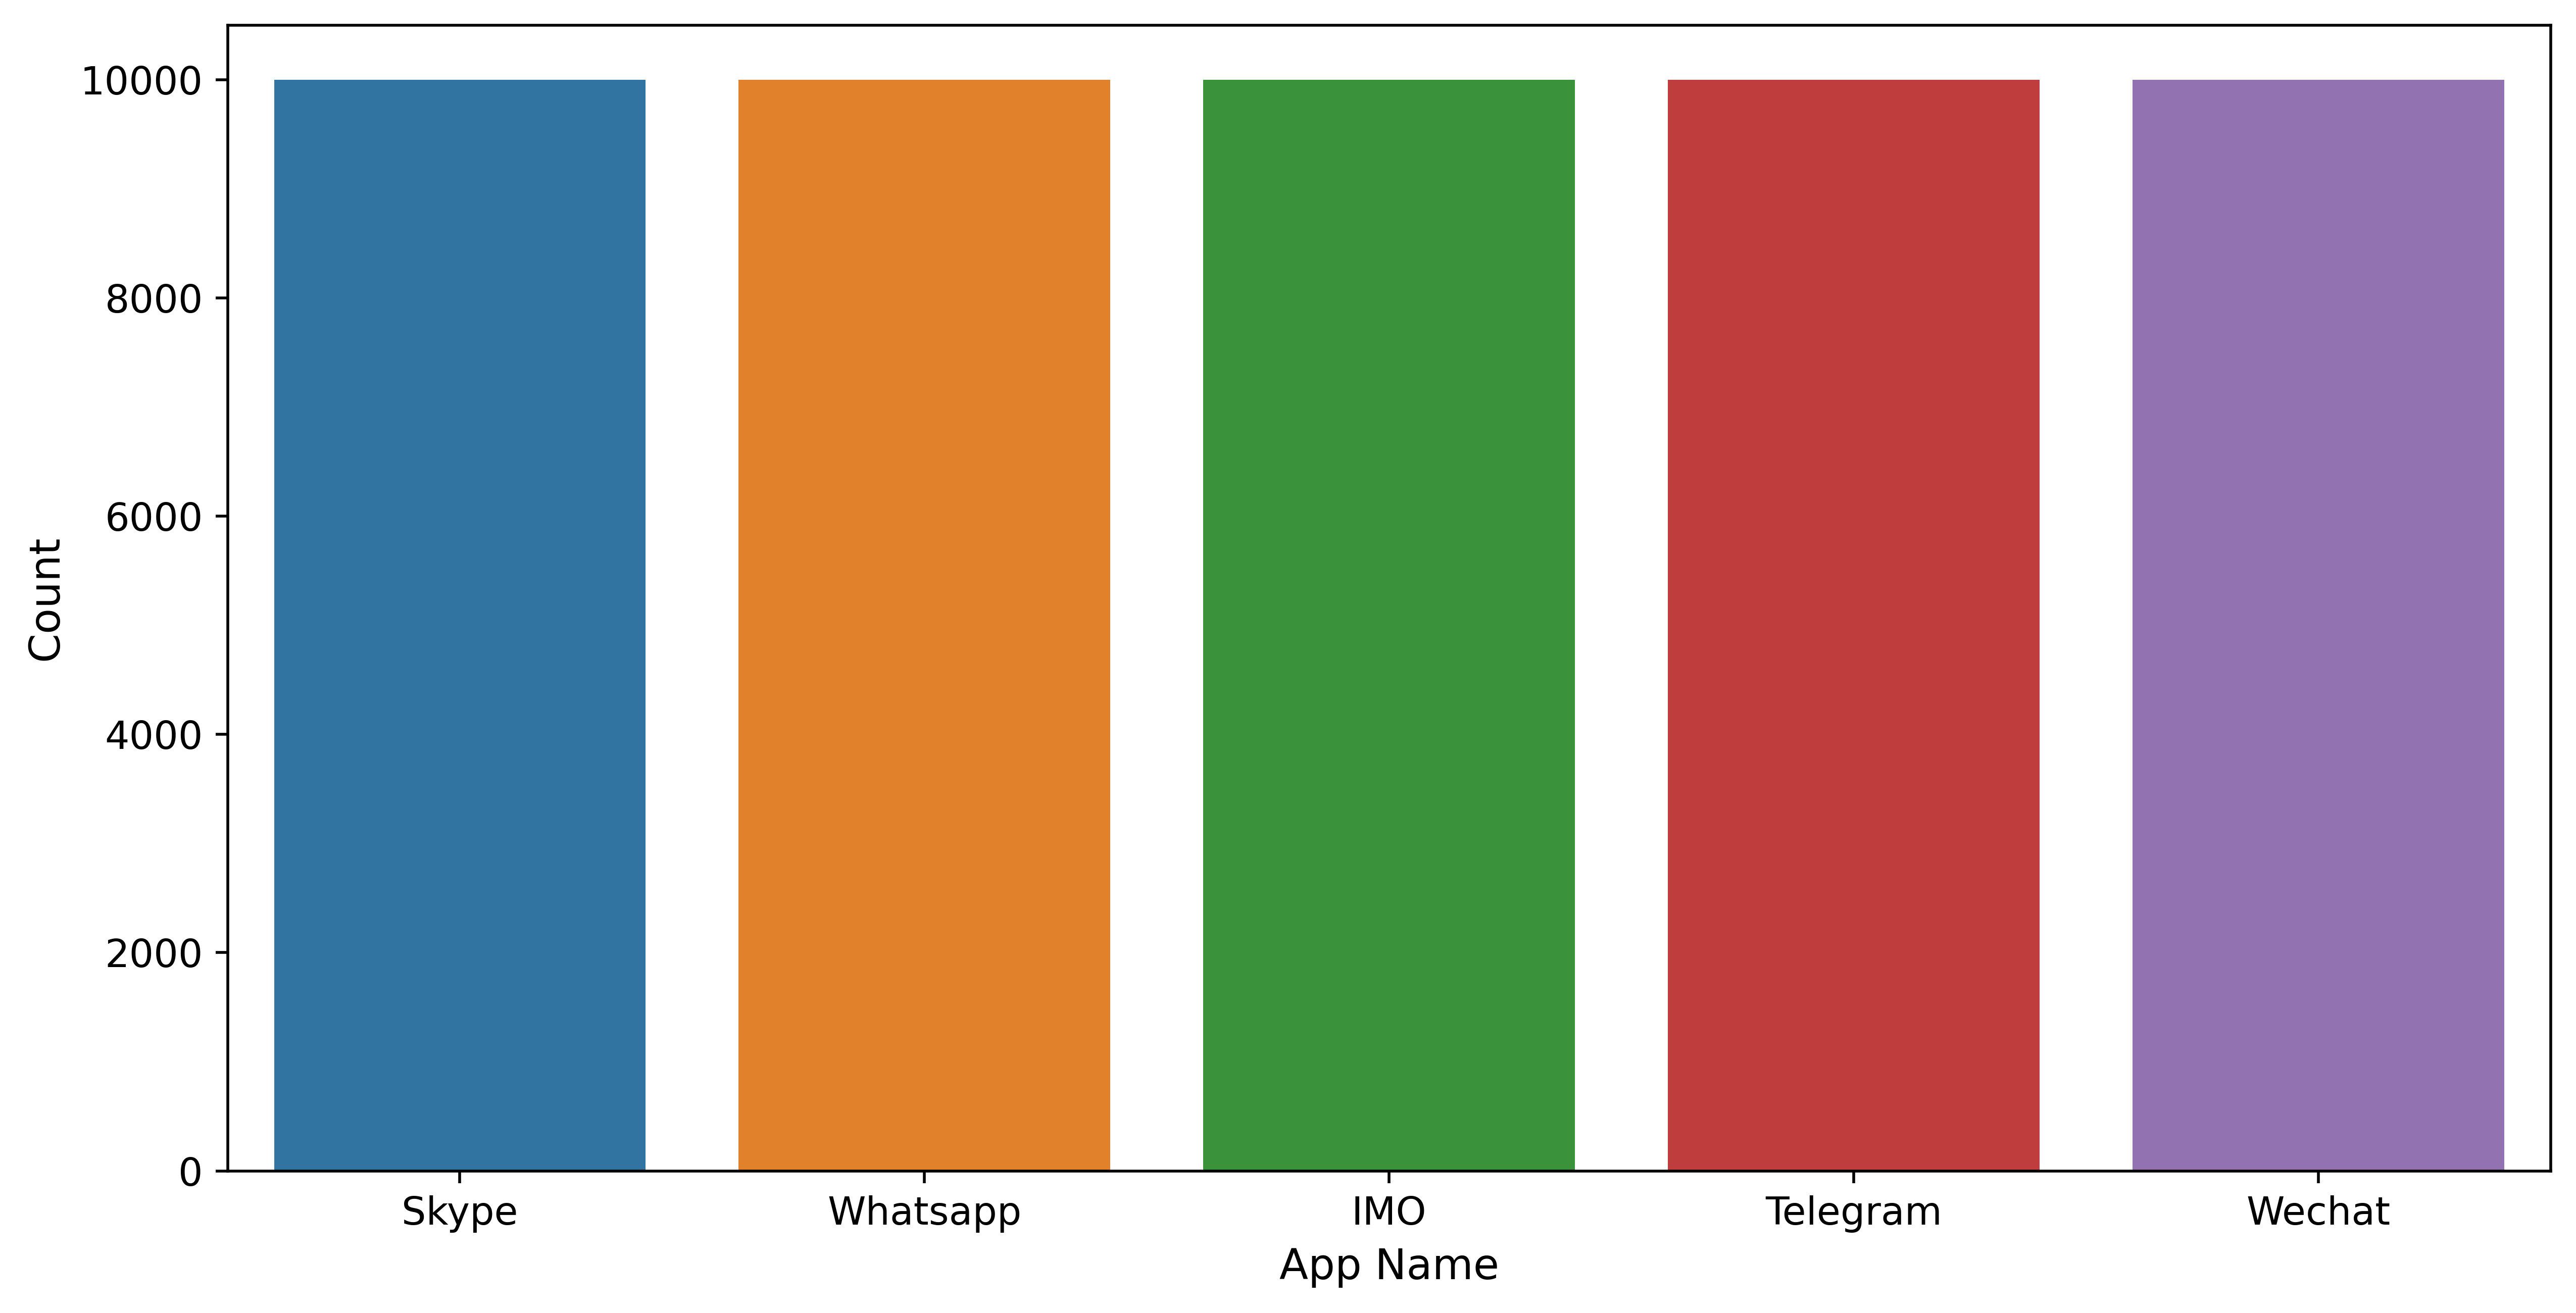

In [123]:
from matplotlib import pyplot
y = df["App Name"]         
fig, ax = pyplot.subplots(figsize=(10,5),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=df["App Name"].value_counts().iloc[:6].index )   
plt.xlabel('App Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout(pad=0)
plt.savefig('All_App_count.pdf')

C:\Users\Sohail_Comp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


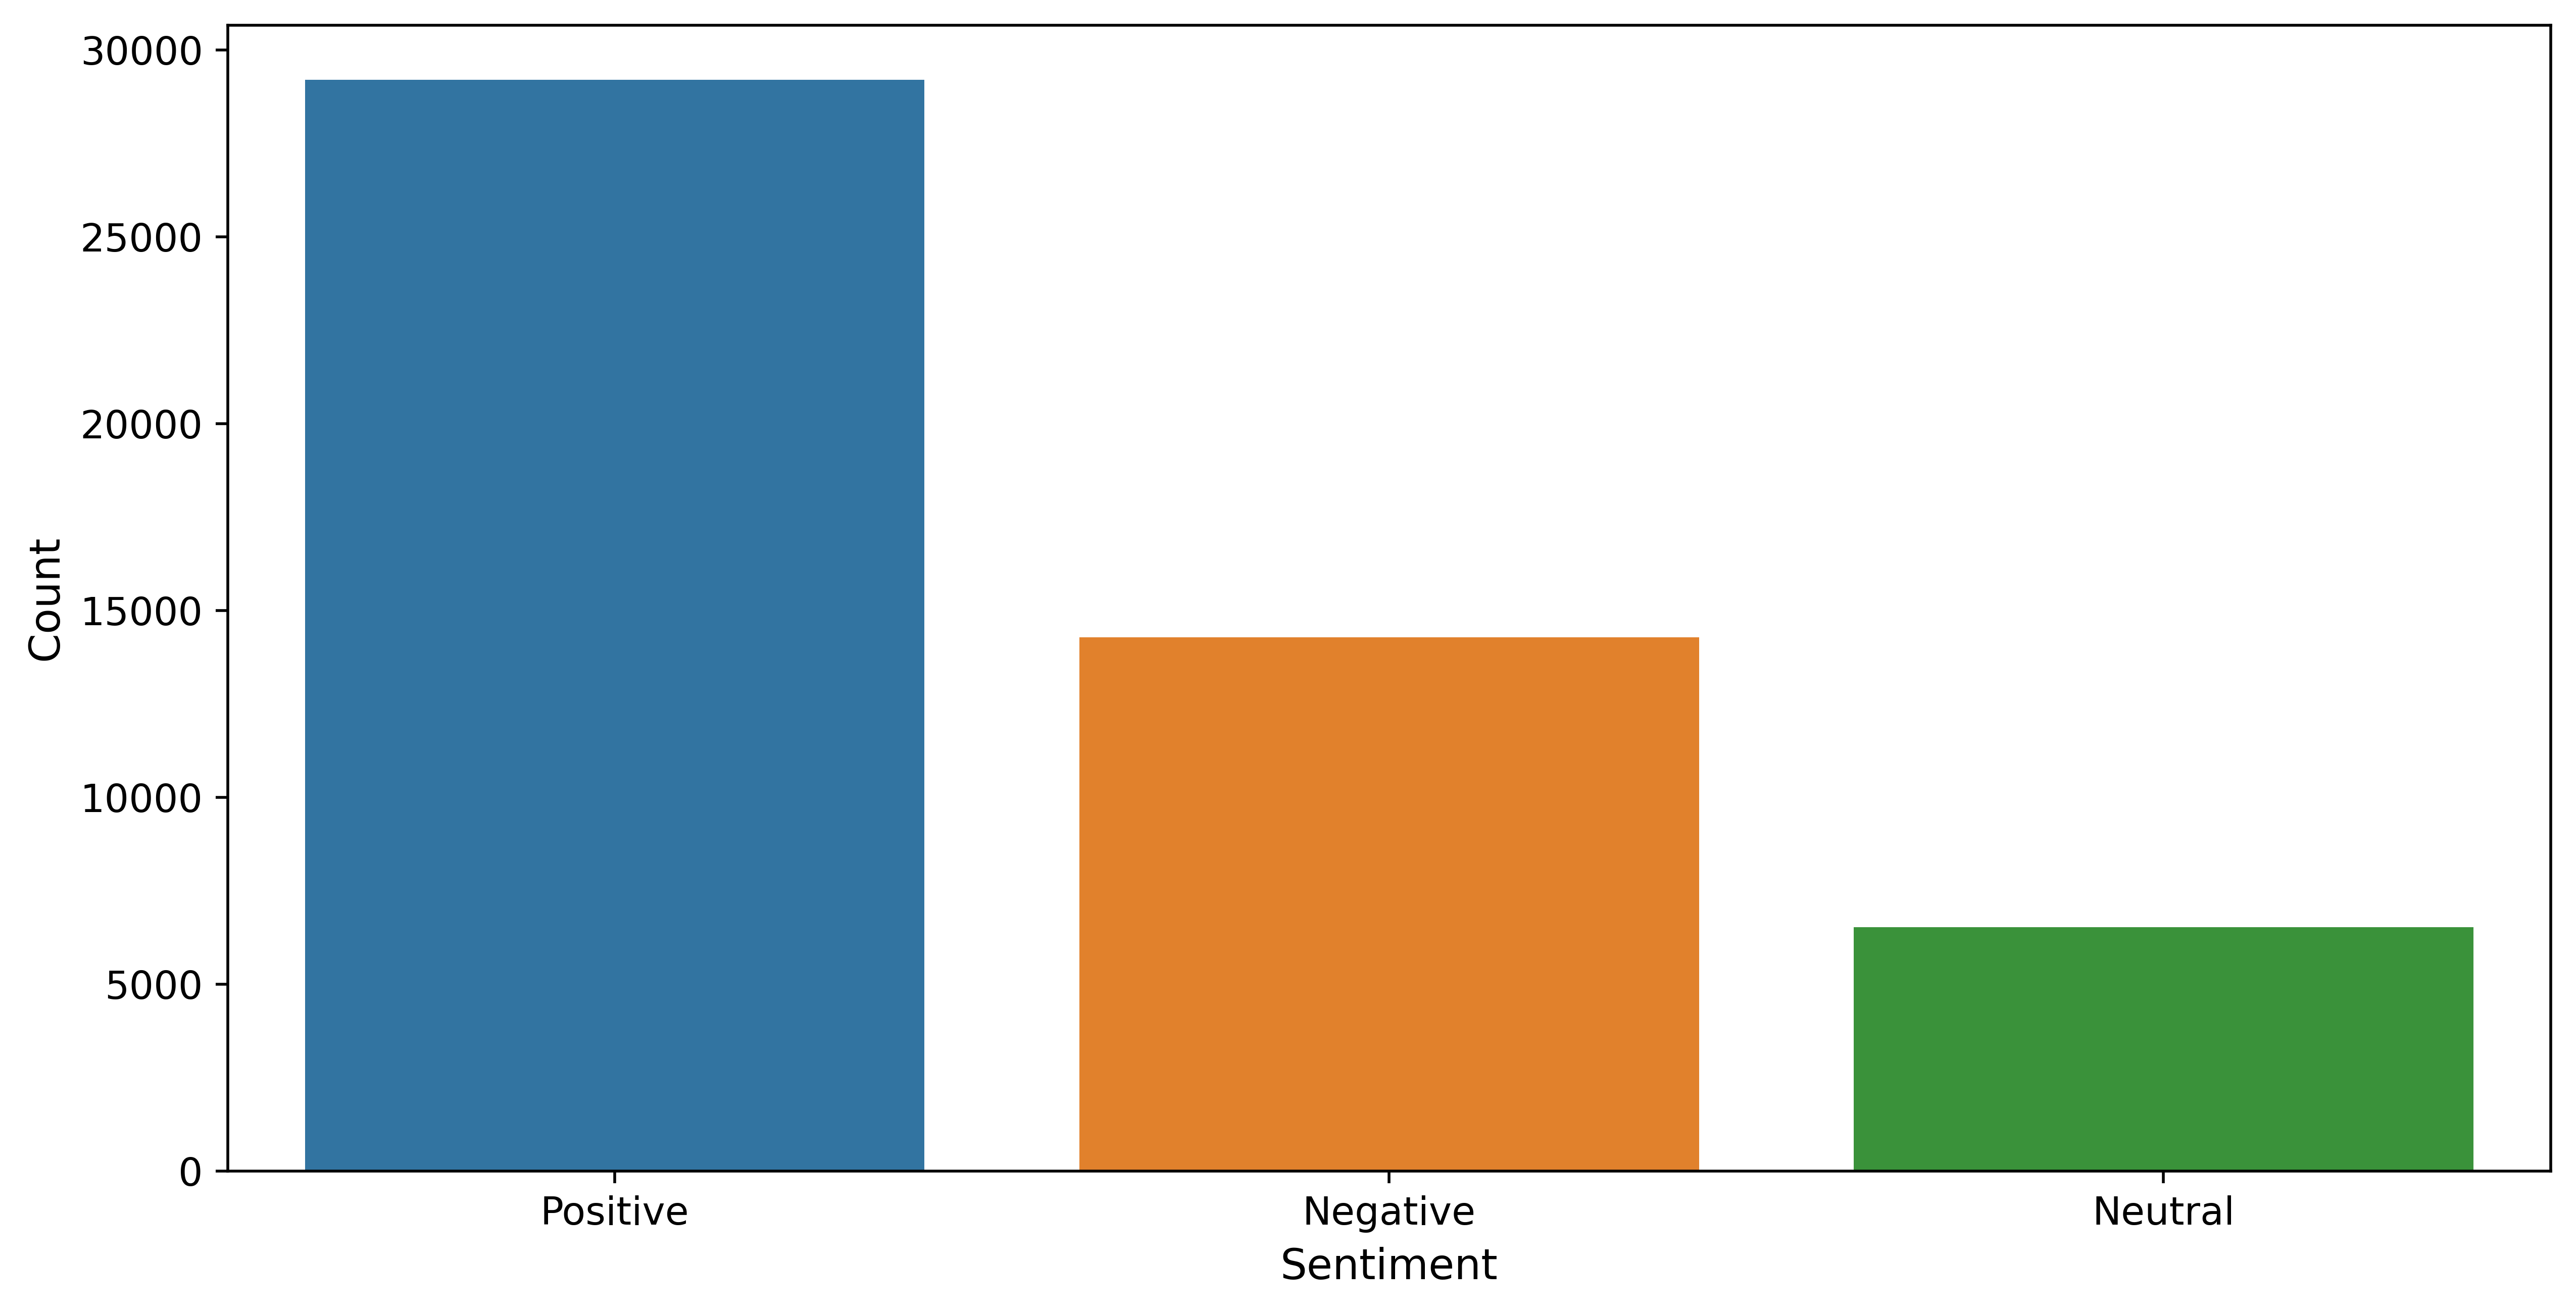

In [124]:
from matplotlib import pyplot
y = df["sentiment"]         
fig, ax = pyplot.subplots(figsize=(10,5),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=df["sentiment"].value_counts().iloc[:6].index )   
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout(pad=0)
plt.savefig('All_App_Sentiment_count.pdf')

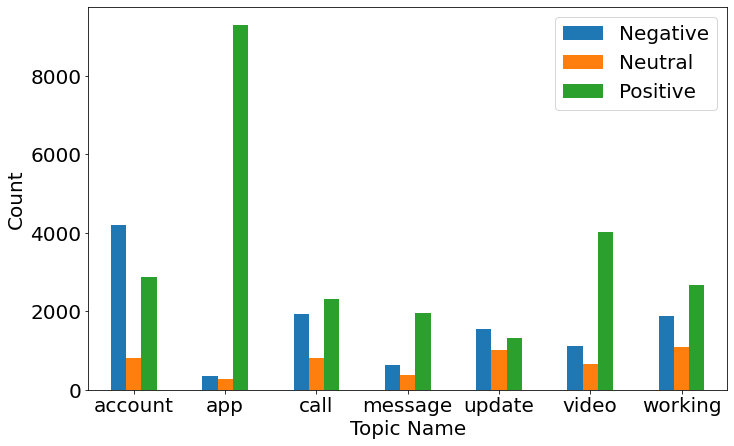

In [125]:
fig = graph_results.plot.bar(rot=0, figsize=(10,6),fontsize=20)
fig.legend(fontsize=20)
plt.xlabel('Topic Name', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout(pad=0)
fig.figure.savefig('All_App_Topic_Sentiment.pdf', bbox_inches='tight')

In [126]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df.loc[df['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass

In [127]:
unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

In [56]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(background_color='whitesmoke', width = 1000, height = 1000)

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v

wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('All_App_positive_words.pdf')
plt.show()

In [ ]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('All_App_negative_words.pdf')
plt.show()

# Per App Sentiment

In [76]:
#Preprocessing of text tweets to remove : Punction, Numbers, stropwords hash tages , links stemming, lematization


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english') and "amp"]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)


df['cleanText']=df['content'].map(lambda s:preprocess(s)) 

In [77]:
# initiate nltk lemmatiser
# initiate stopwords from nltk
df['remove_lower_punct'] = df['cleanText'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list


C:\Users\SOHAIL~1\AppData\Local\Temp/ipykernel_5224/1593059411.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['remove_lower_punct'] = df['cleanText'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


In [149]:
analyser.polarity_scores("Have changed profile settings multiple times and still cannot see my profile photo")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [150]:
import nltk
from textblob import  TextBlob

sentiment = TextBlob("Have changed profile settings multiple times and still cannot see my profile photo")
sentiment.sentiment.polarity

0.0

In [78]:
results = df.groupby(['App Name', 'sentiment']).count().reset_index()
graph_results = results[['App Name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='App Name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('App Name', inplace=True)

display(graph_results)

sentiment  Negative  Neutral  Positive
App Name                              
IMO            2005     1992      6003
Skype          2854      877      6269
Telegram       2496     1421      6083
Wechat         4611     1022      4367
Whatsapp       2313     1213      6474

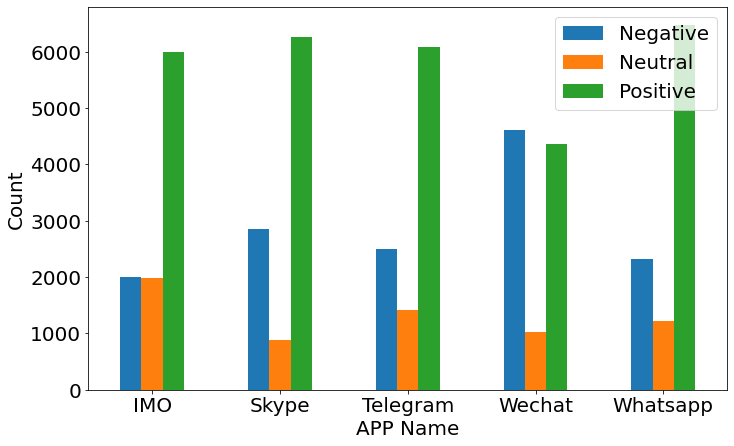

In [79]:
fig = graph_results.plot.bar(rot=0, figsize=(10,6),fontsize=20)
fig.legend(fontsize=20)
plt.xlabel('APP Name', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout(pad=0)
fig.figure.savefig('All_App_Sentiment.pdf', bbox_inches='tight')

# Per App Topic Sentiment

# IMO

In [80]:
df1=df.loc[df['App Name'] == "IMO"]

In [81]:
results = df1.groupby(['Dominant_topic', 'sentiment']).count().reset_index()
results = results[results.Dominant_topic != 2]
results = results[results.Dominant_topic != 1]
results = results[results.Dominant_topic != 9]
results = results.merge(all_topics, on='Dominant_topic')
results['Topic Name'] = results['topic_name'].apply(', '.join)

graph_results = results[['Topic Name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Topic Name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Topic Name', inplace=True)

display(graph_results)

sentiment   Negative  Neutral  Positive
Topic Name                             
account          143      111       129
app               64      105      2688
call             170      215       254
message           48       59       146
update           647      592       556
video             37       59       151
working           84      119       121

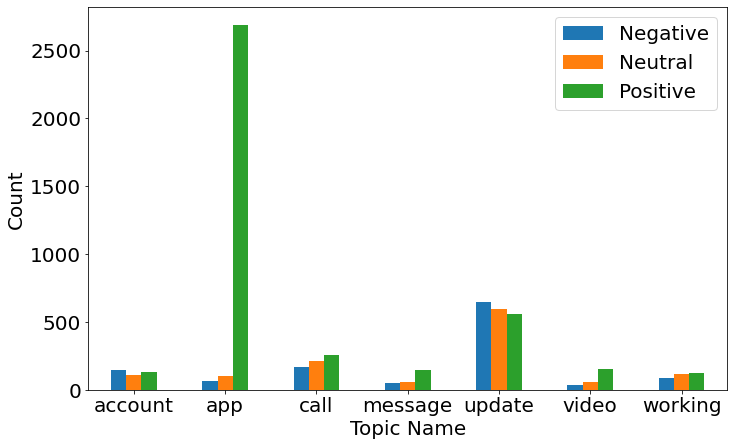

In [82]:
fig = graph_results.plot.bar(rot=0, figsize=(10,6),fontsize=20)
fig.legend(fontsize=20)
plt.xlabel('Topic Name', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout(pad=0)
fig.figure.savefig('IMO_Topic_Sentiment.pdf', bbox_inches='tight')

In [75]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df1['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df1.loc[df1['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass

In [76]:
unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

In [46]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v


wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Google_Meet_positive_words.pdf')
plt.show()

NameError: name 'wordcloud' is not defined

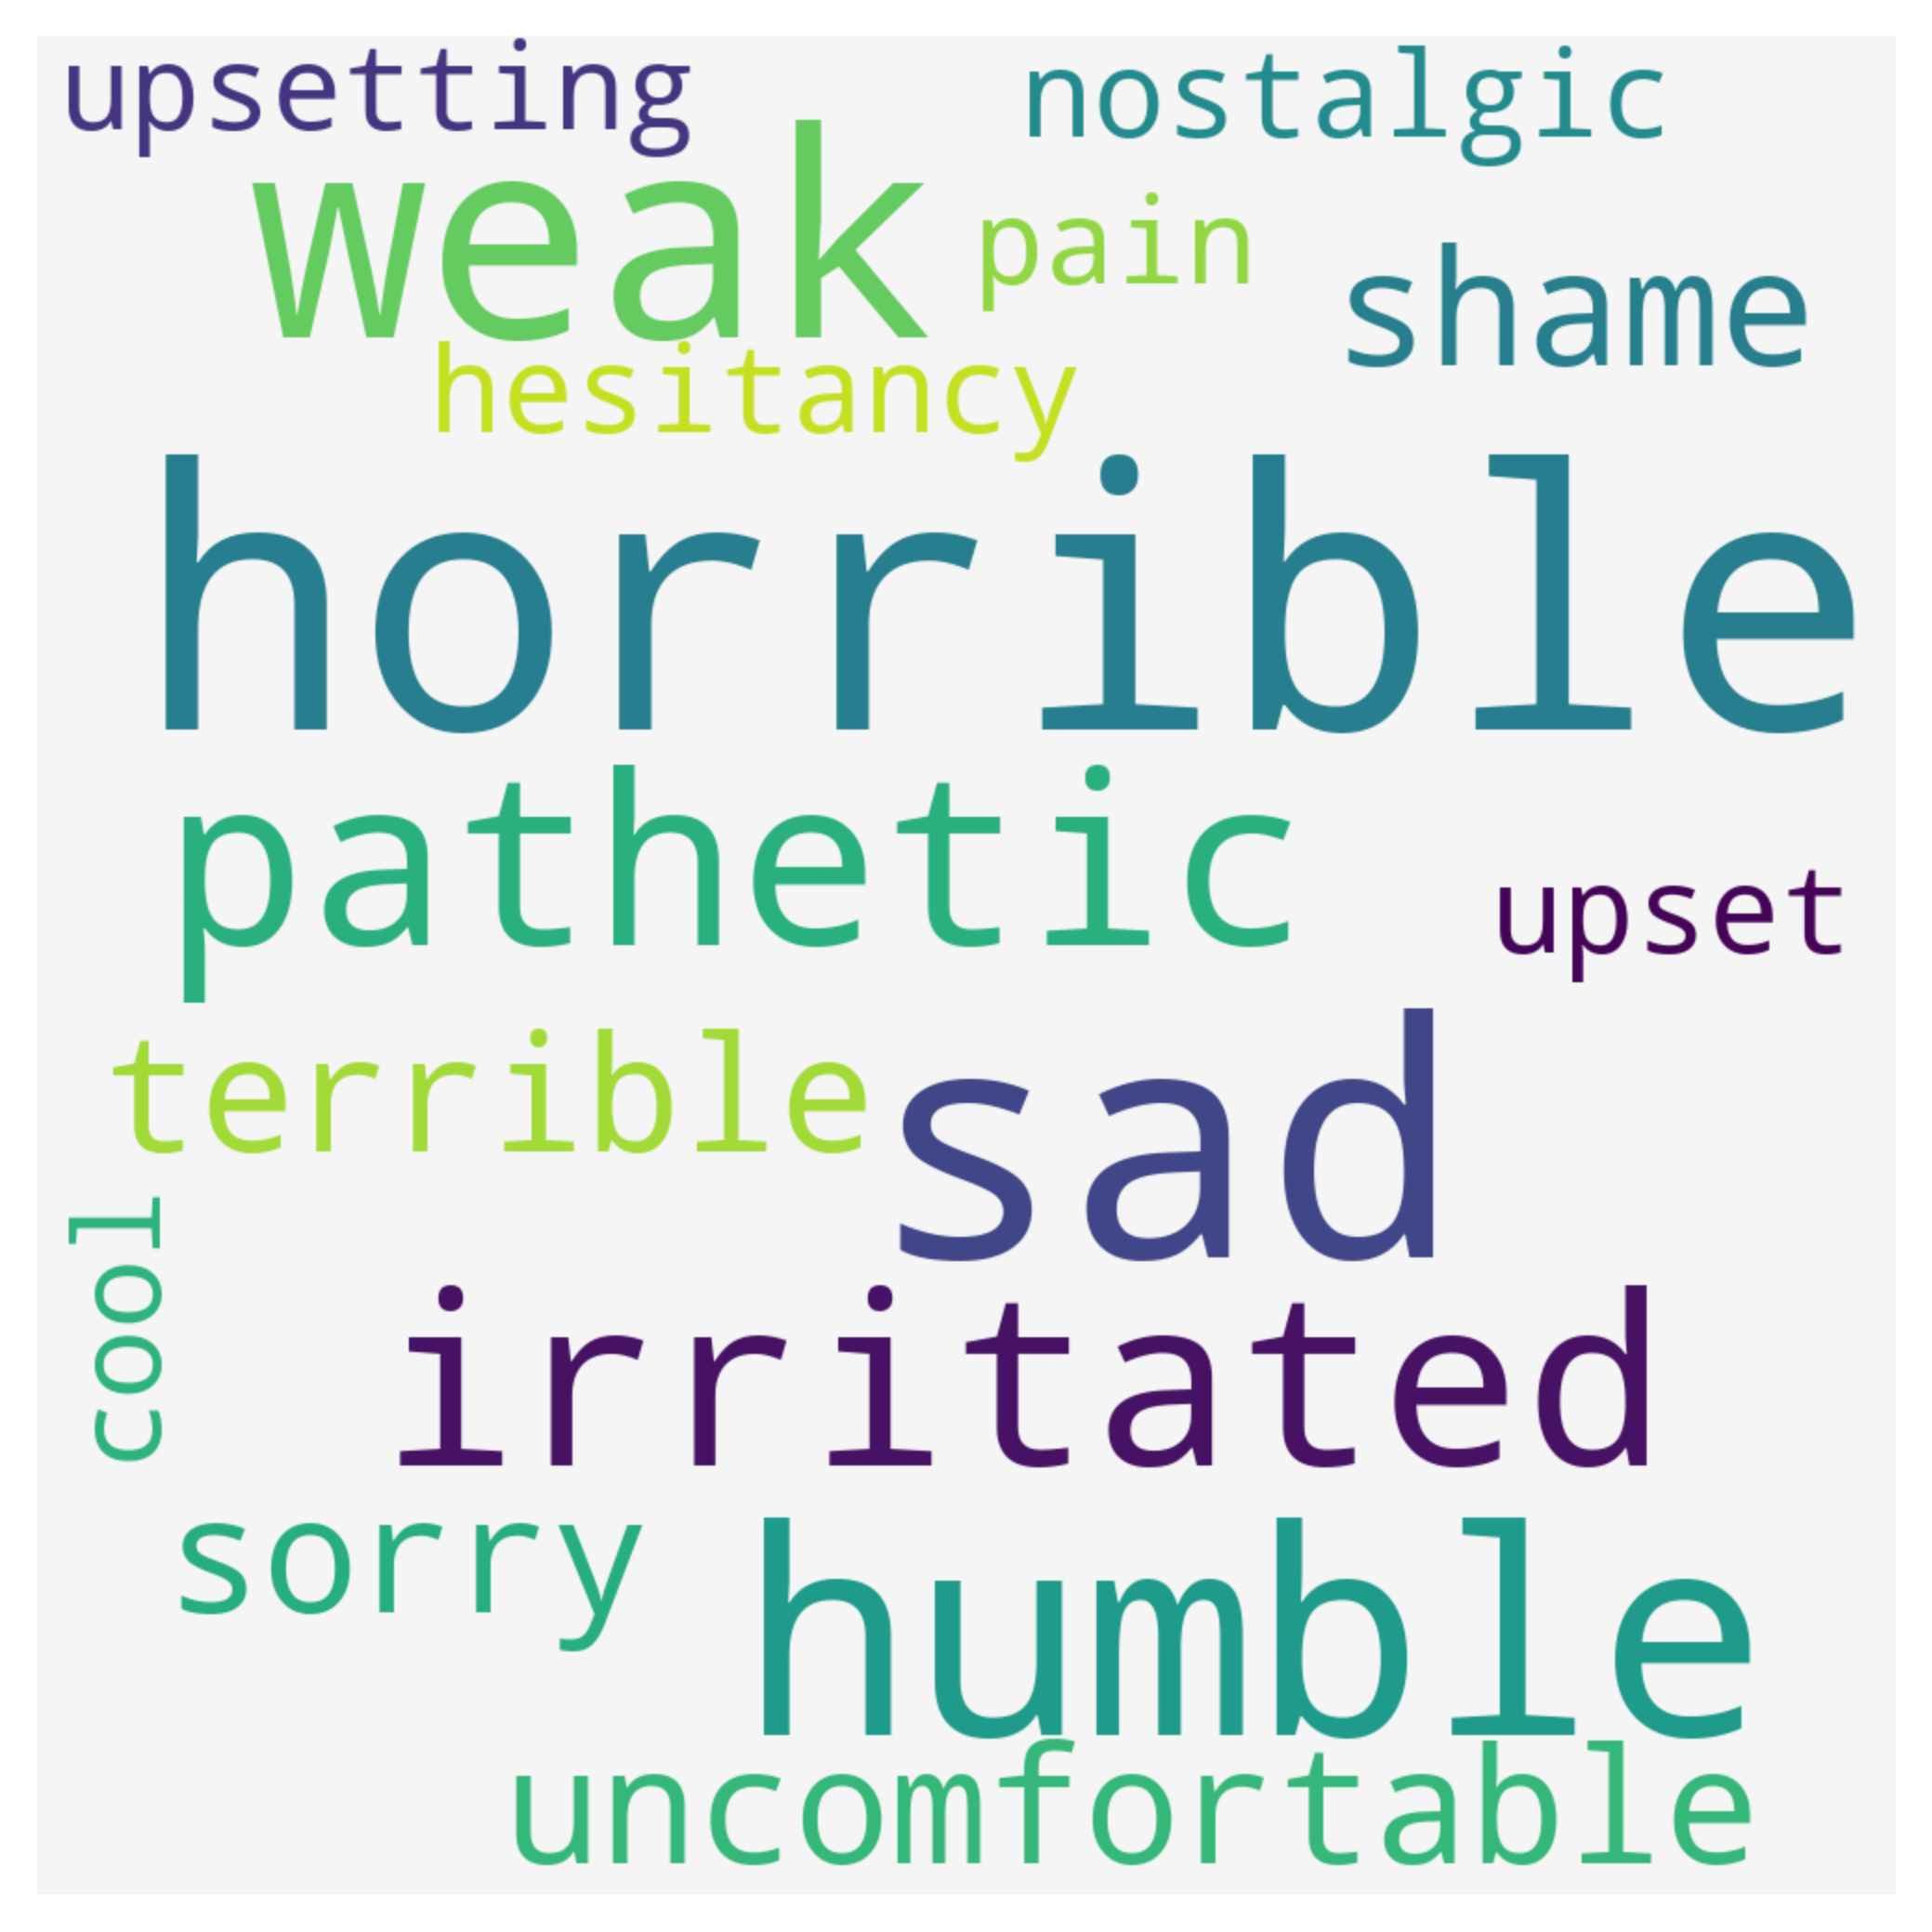

In [188]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Google_Meet_negative_words.pdf')
plt.show()

# Skype

In [83]:
df1=df.loc[df['App Name'] == "Skype"]

In [84]:
results = df1.groupby(['Dominant_topic', 'sentiment']).count().reset_index()
results = results[results.Dominant_topic != 2]
results = results[results.Dominant_topic != 1]
results = results[results.Dominant_topic != 9]
results = results.merge(all_topics, on='Dominant_topic')
results['Topic Name'] = results['topic_name'].apply(', '.join)

graph_results = results[['Topic Name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Topic Name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Topic Name', inplace=True)


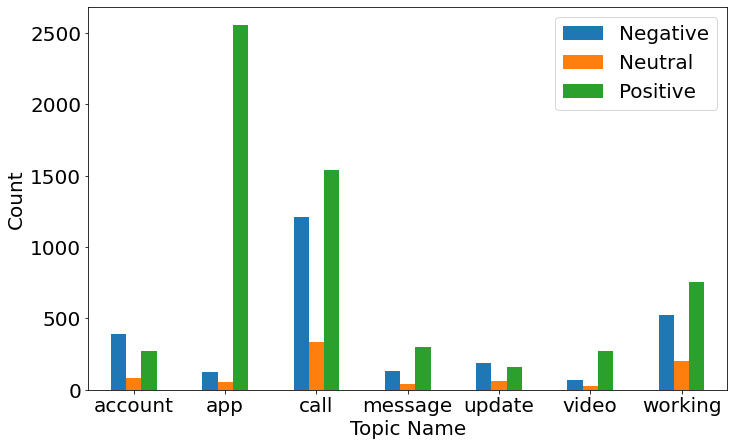

In [85]:
fig = graph_results.plot.bar(rot=0, figsize=(10,6),fontsize=20)
fig.legend(fontsize=20)
plt.xlabel('Topic Name', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout(pad=0)
fig.figure.savefig('skype_Topic_Sentiment.pdf', bbox_inches='tight')

In [192]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df1['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df1.loc[df1['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass
                    

unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

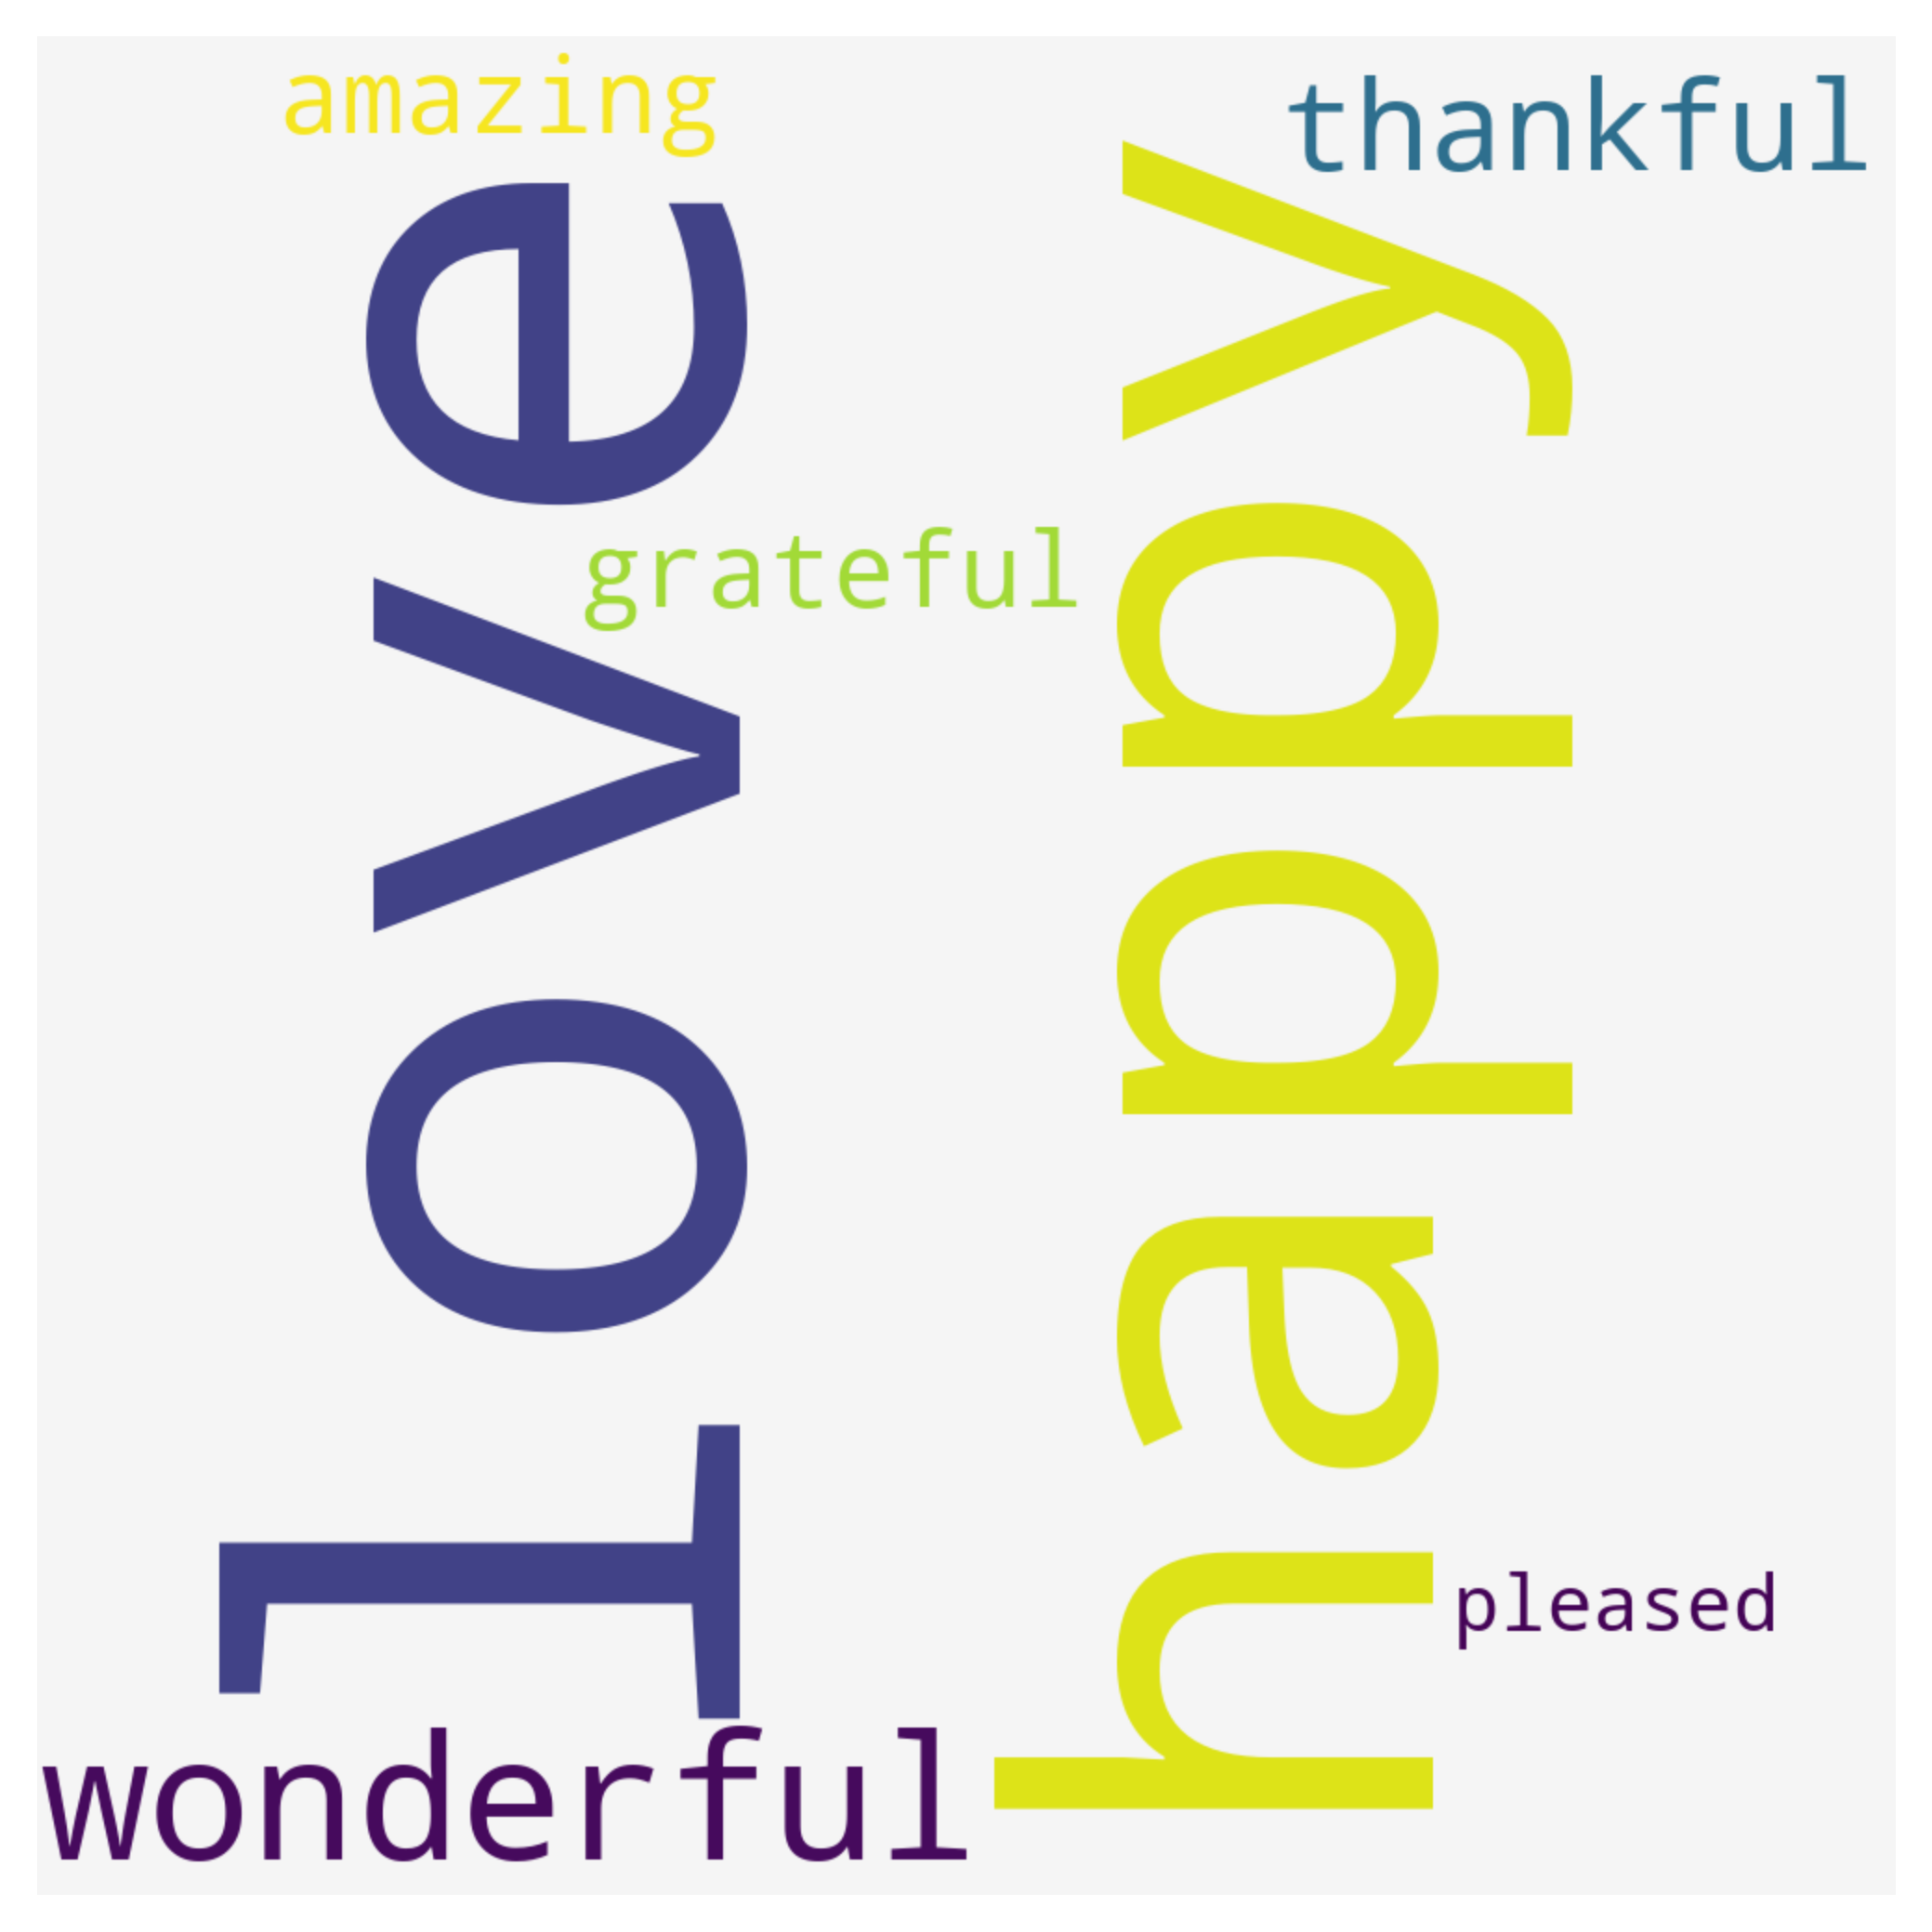

In [193]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v

wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Zoom_Meeting_positive_words.pdf')
plt.show()

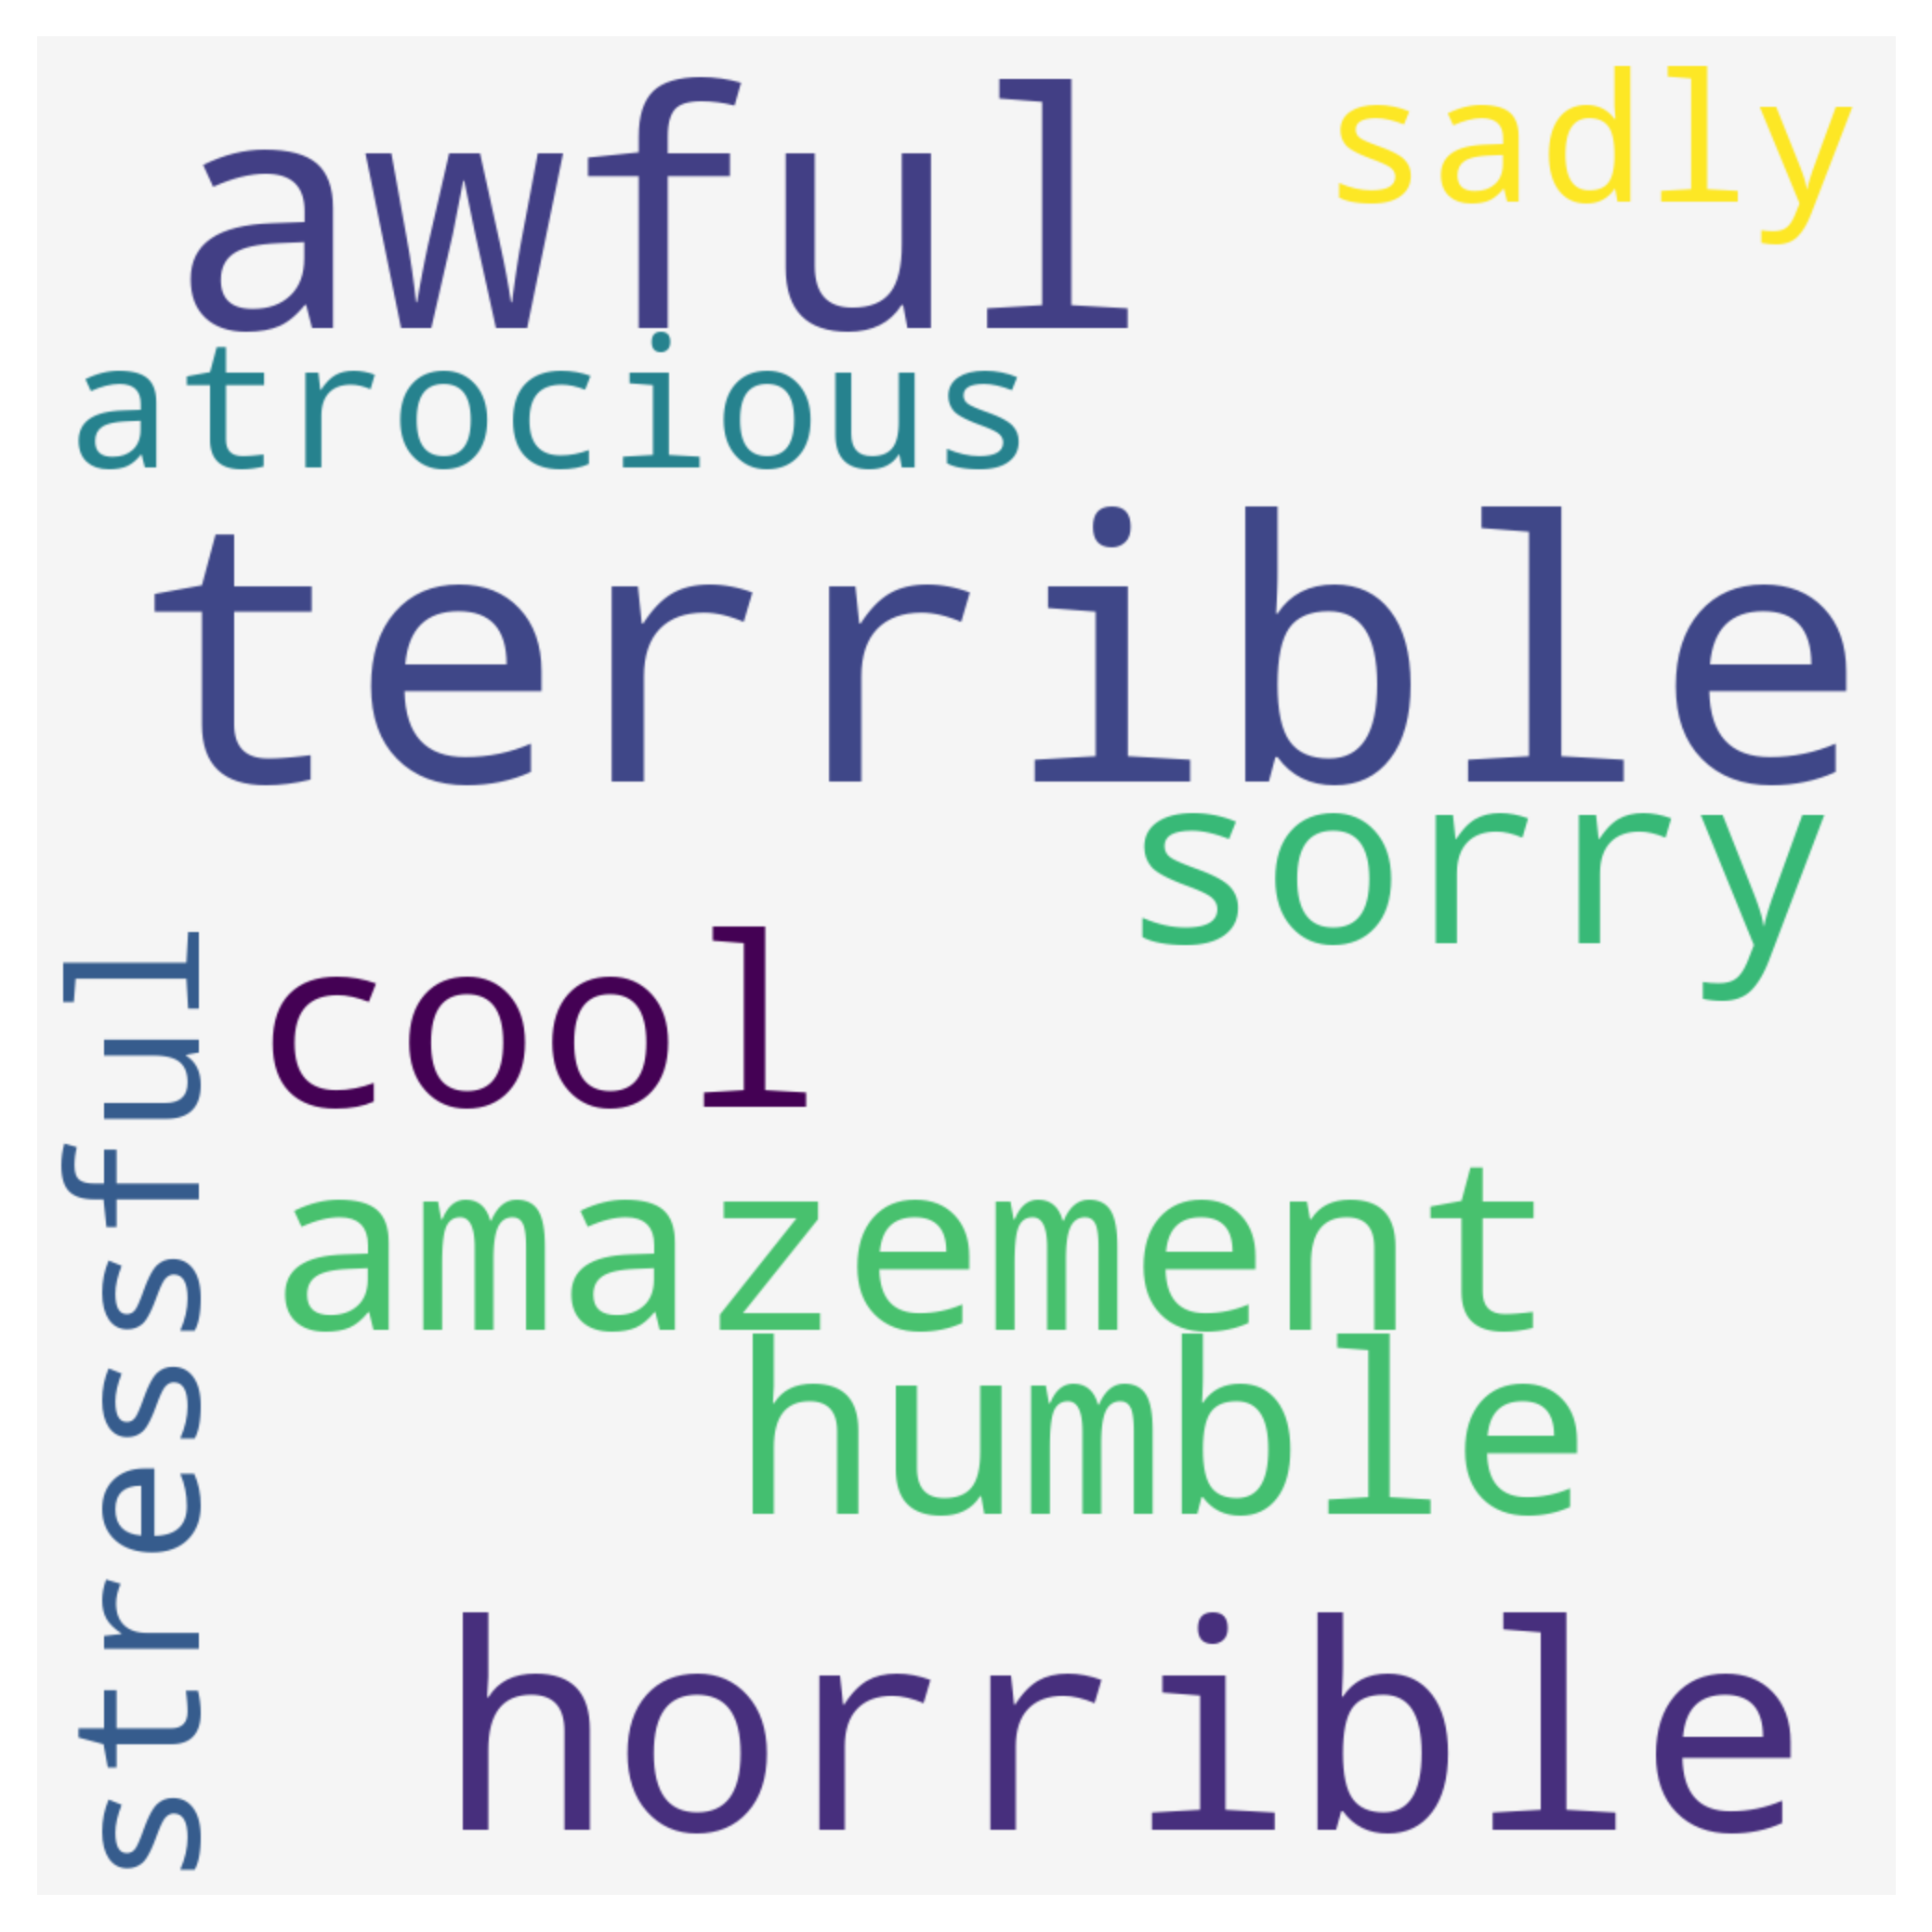

In [194]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Zoom_meeting_negative_words.pdf')
plt.show()

# Telegram

In [86]:
df1=df.loc[df['App Name'] == "Telegram"]

In [87]:
results = df1.groupby(['Dominant_topic', 'sentiment']).count().reset_index()
results = results[results.Dominant_topic != 2]
results = results[results.Dominant_topic != 1]
results = results[results.Dominant_topic != 9]
results = results.merge(all_topics, on='Dominant_topic')
results['Topic Name'] = results['topic_name'].apply(', '.join)

graph_results = results[['Topic Name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Topic Name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Topic Name', inplace=True)



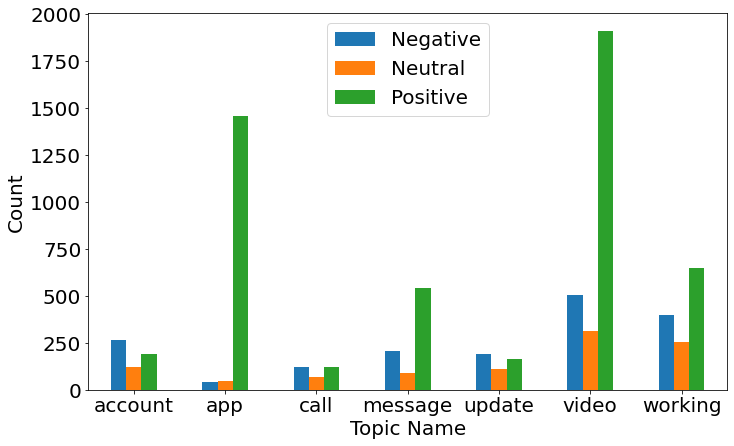

In [88]:
fig = graph_results.plot.bar(rot=0, figsize=(10,6),fontsize=20)
fig.legend(fontsize=20)
plt.xlabel('Topic Name', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout(pad=0)
fig.figure.savefig('Telegram_Topic_Sentiment.pdf', bbox_inches='tight')

In [198]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df1['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df1.loc[df1['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass
                    

unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

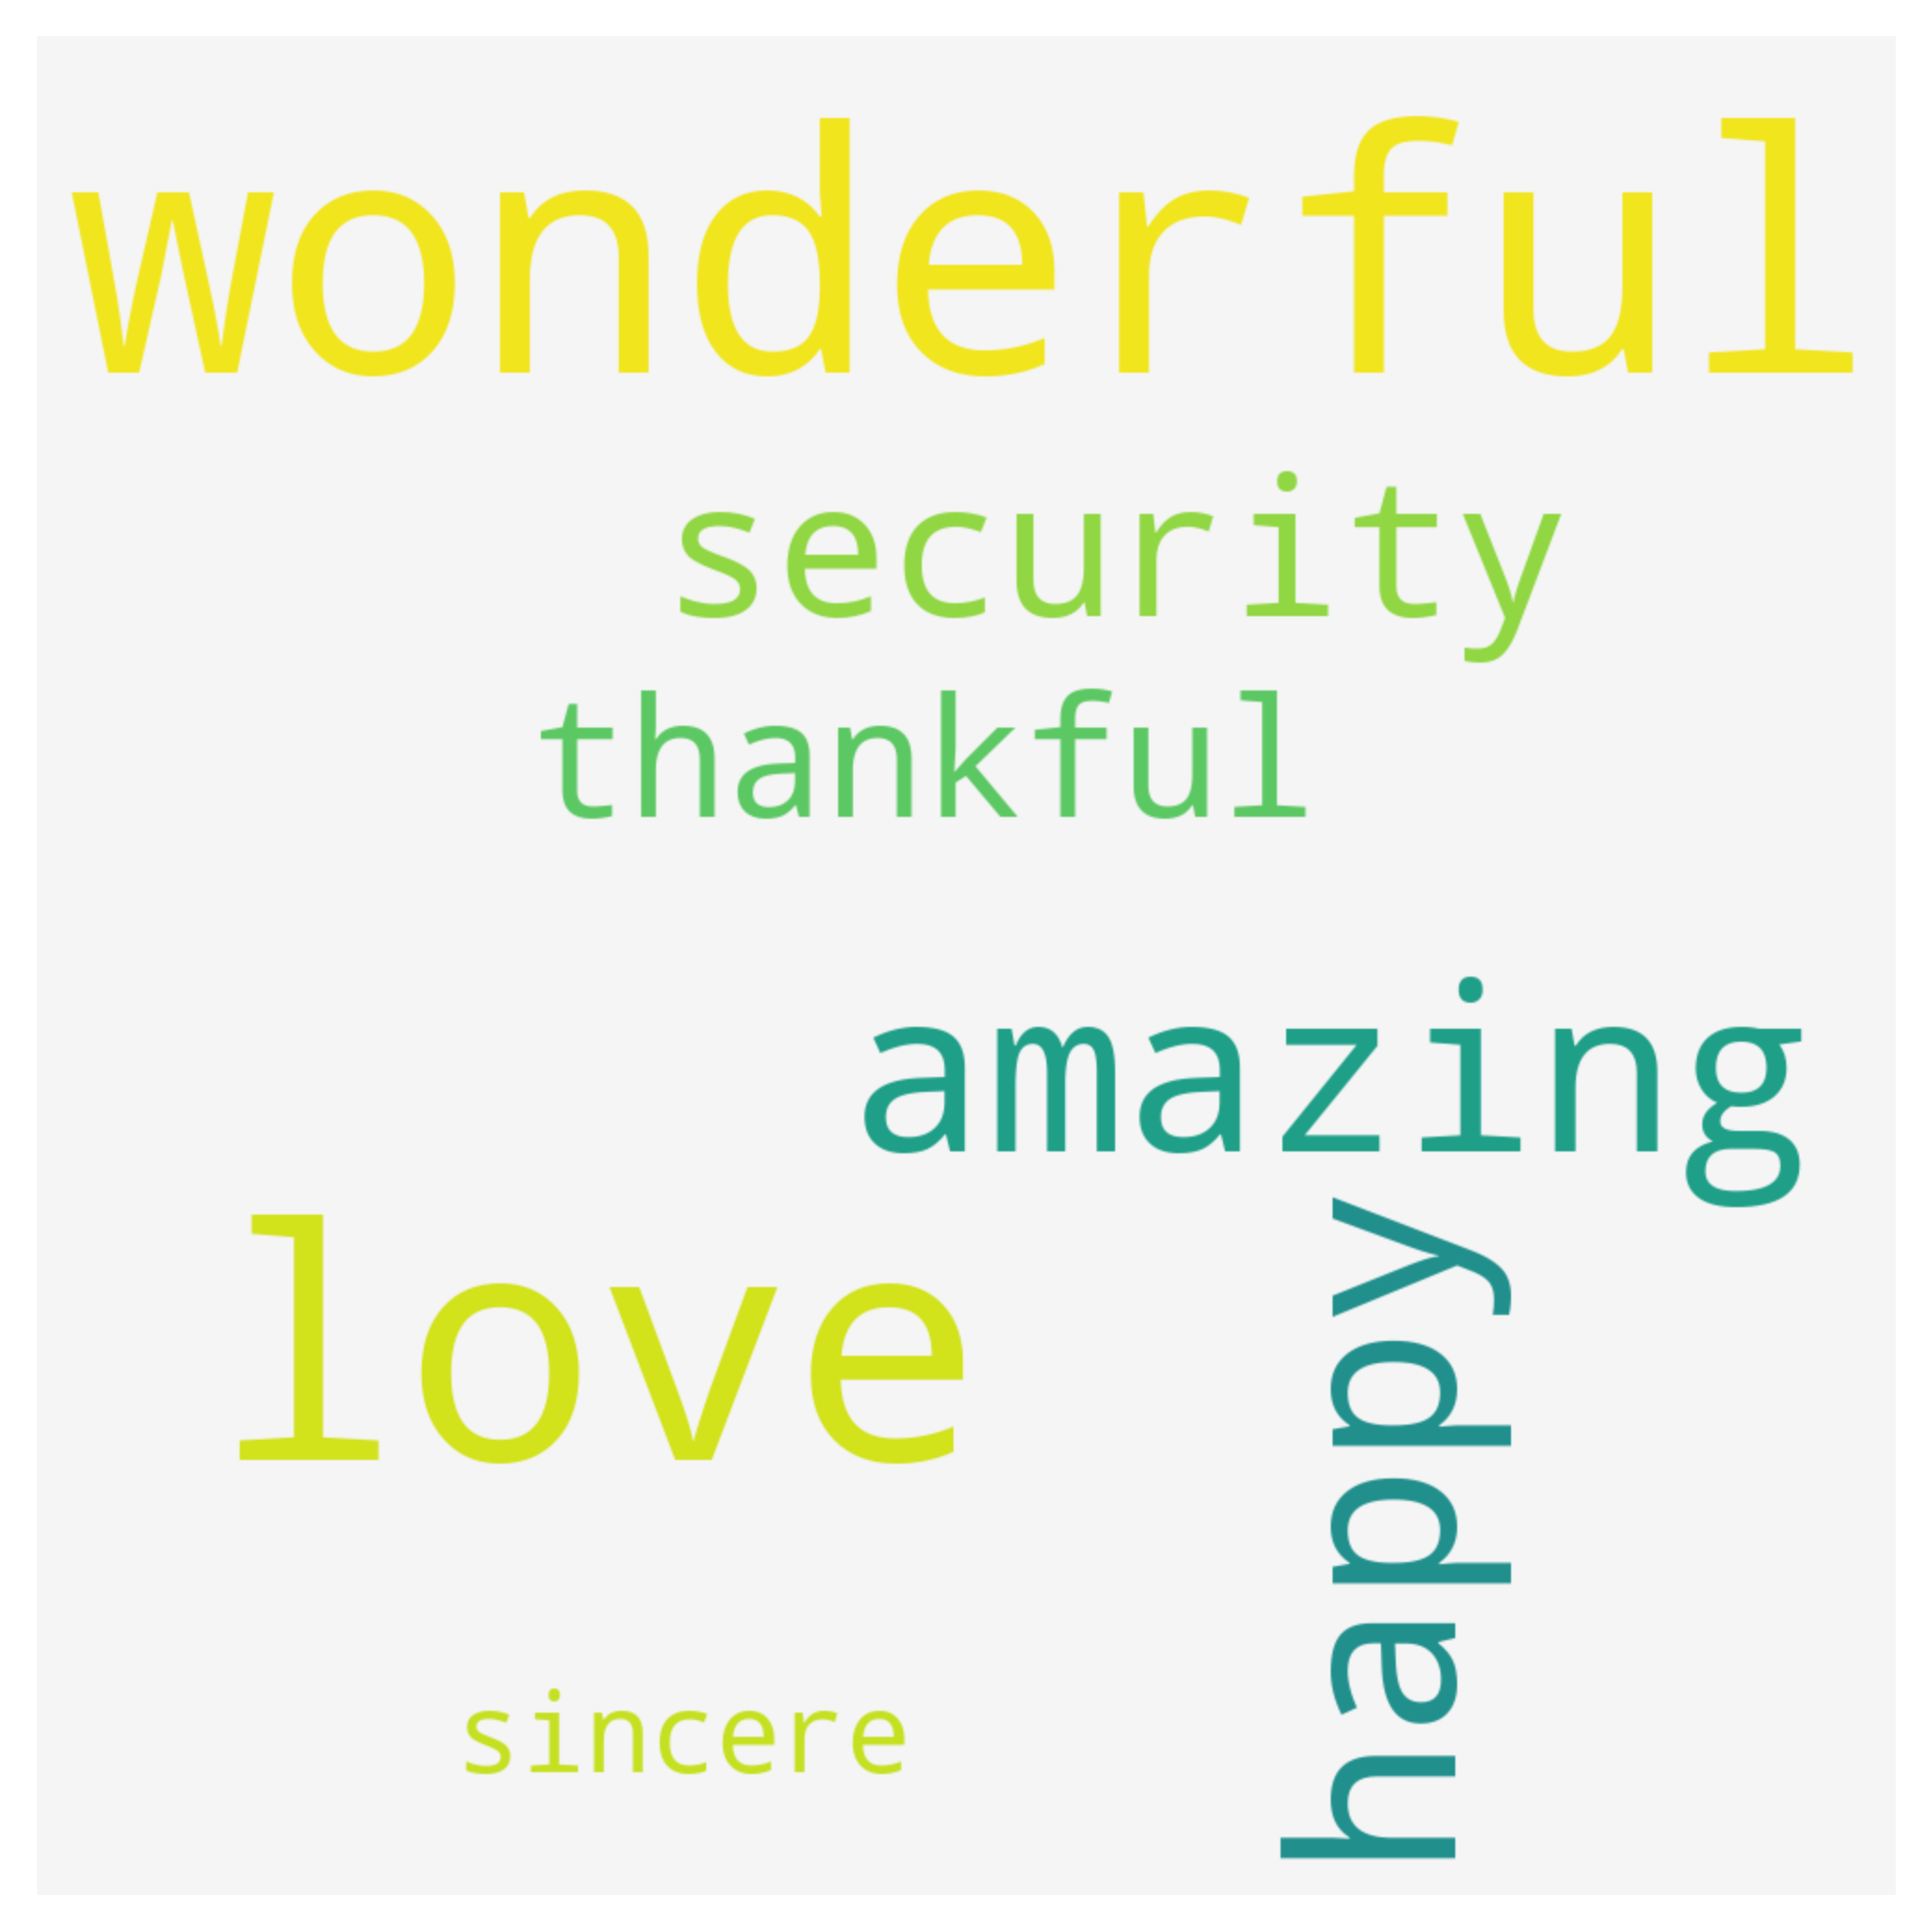

In [199]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v


wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Goto_Meeting_positive_words.pdf')
plt.show()

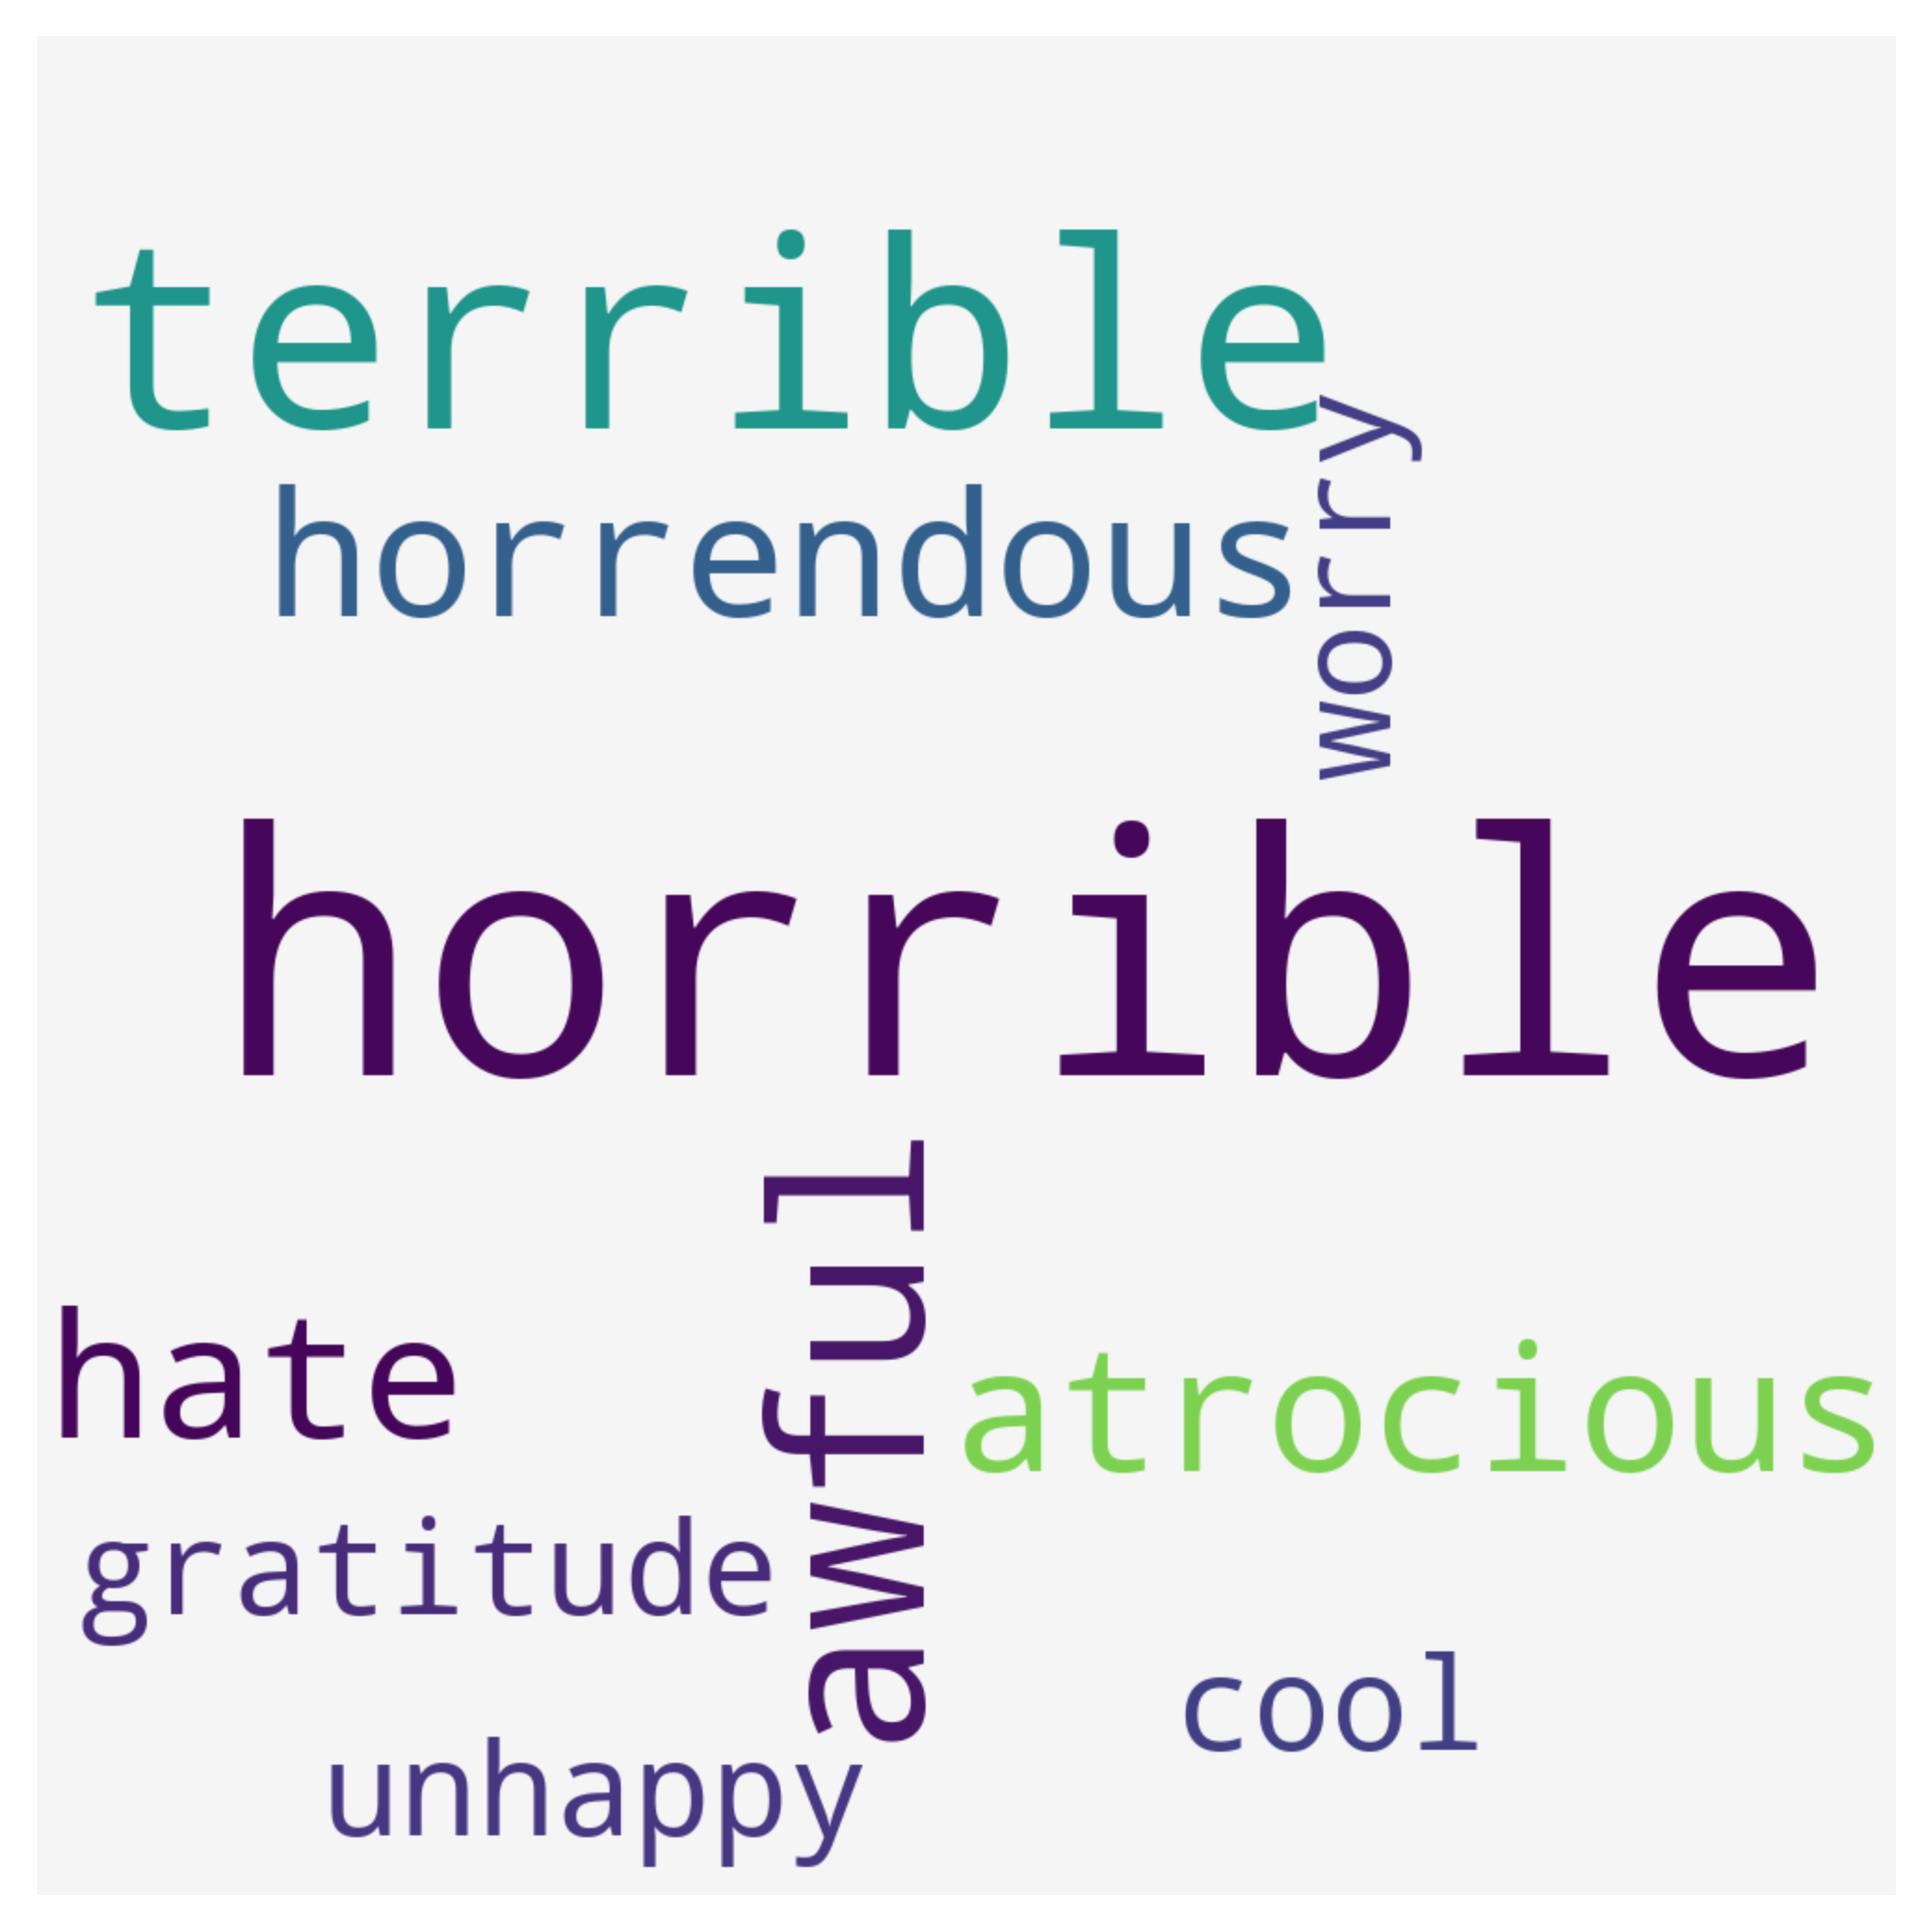

In [200]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Goto_meeting_negative_words.pdf')
plt.show()

# Wechat

In [93]:
df1=df.loc[df['App Name'] == "Wechat"]

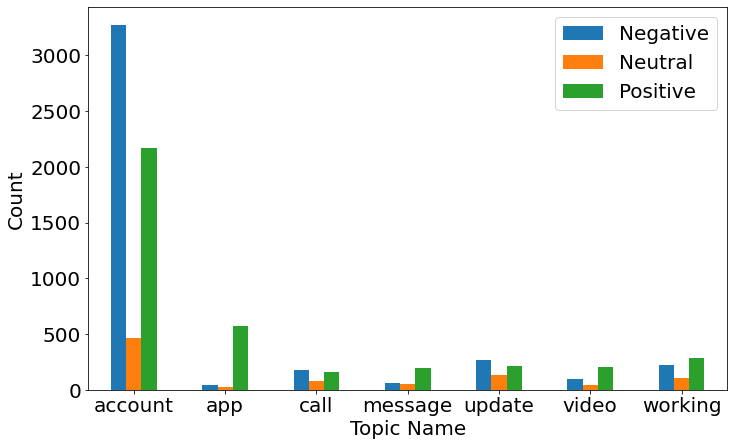

In [94]:
results = df1.groupby(['Dominant_topic', 'sentiment']).count().reset_index()
results = results[results.Dominant_topic != 2]
results = results[results.Dominant_topic != 1]
results = results[results.Dominant_topic != 9]
results = results.merge(all_topics, on='Dominant_topic')
results['Topic Name'] = results['topic_name'].apply(', '.join)

graph_results = results[['Topic Name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Topic Name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Topic Name', inplace=True)

fig = graph_results.plot.bar(rot=0, figsize=(10,6),fontsize=20)
fig.legend(fontsize=20)
plt.xlabel('Topic Name', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout(pad=0)
fig.figure.savefig('Wechat_Topic_Sentiment.pdf', bbox_inches='tight')

In [203]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df1['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df1.loc[df1['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass
                    

unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

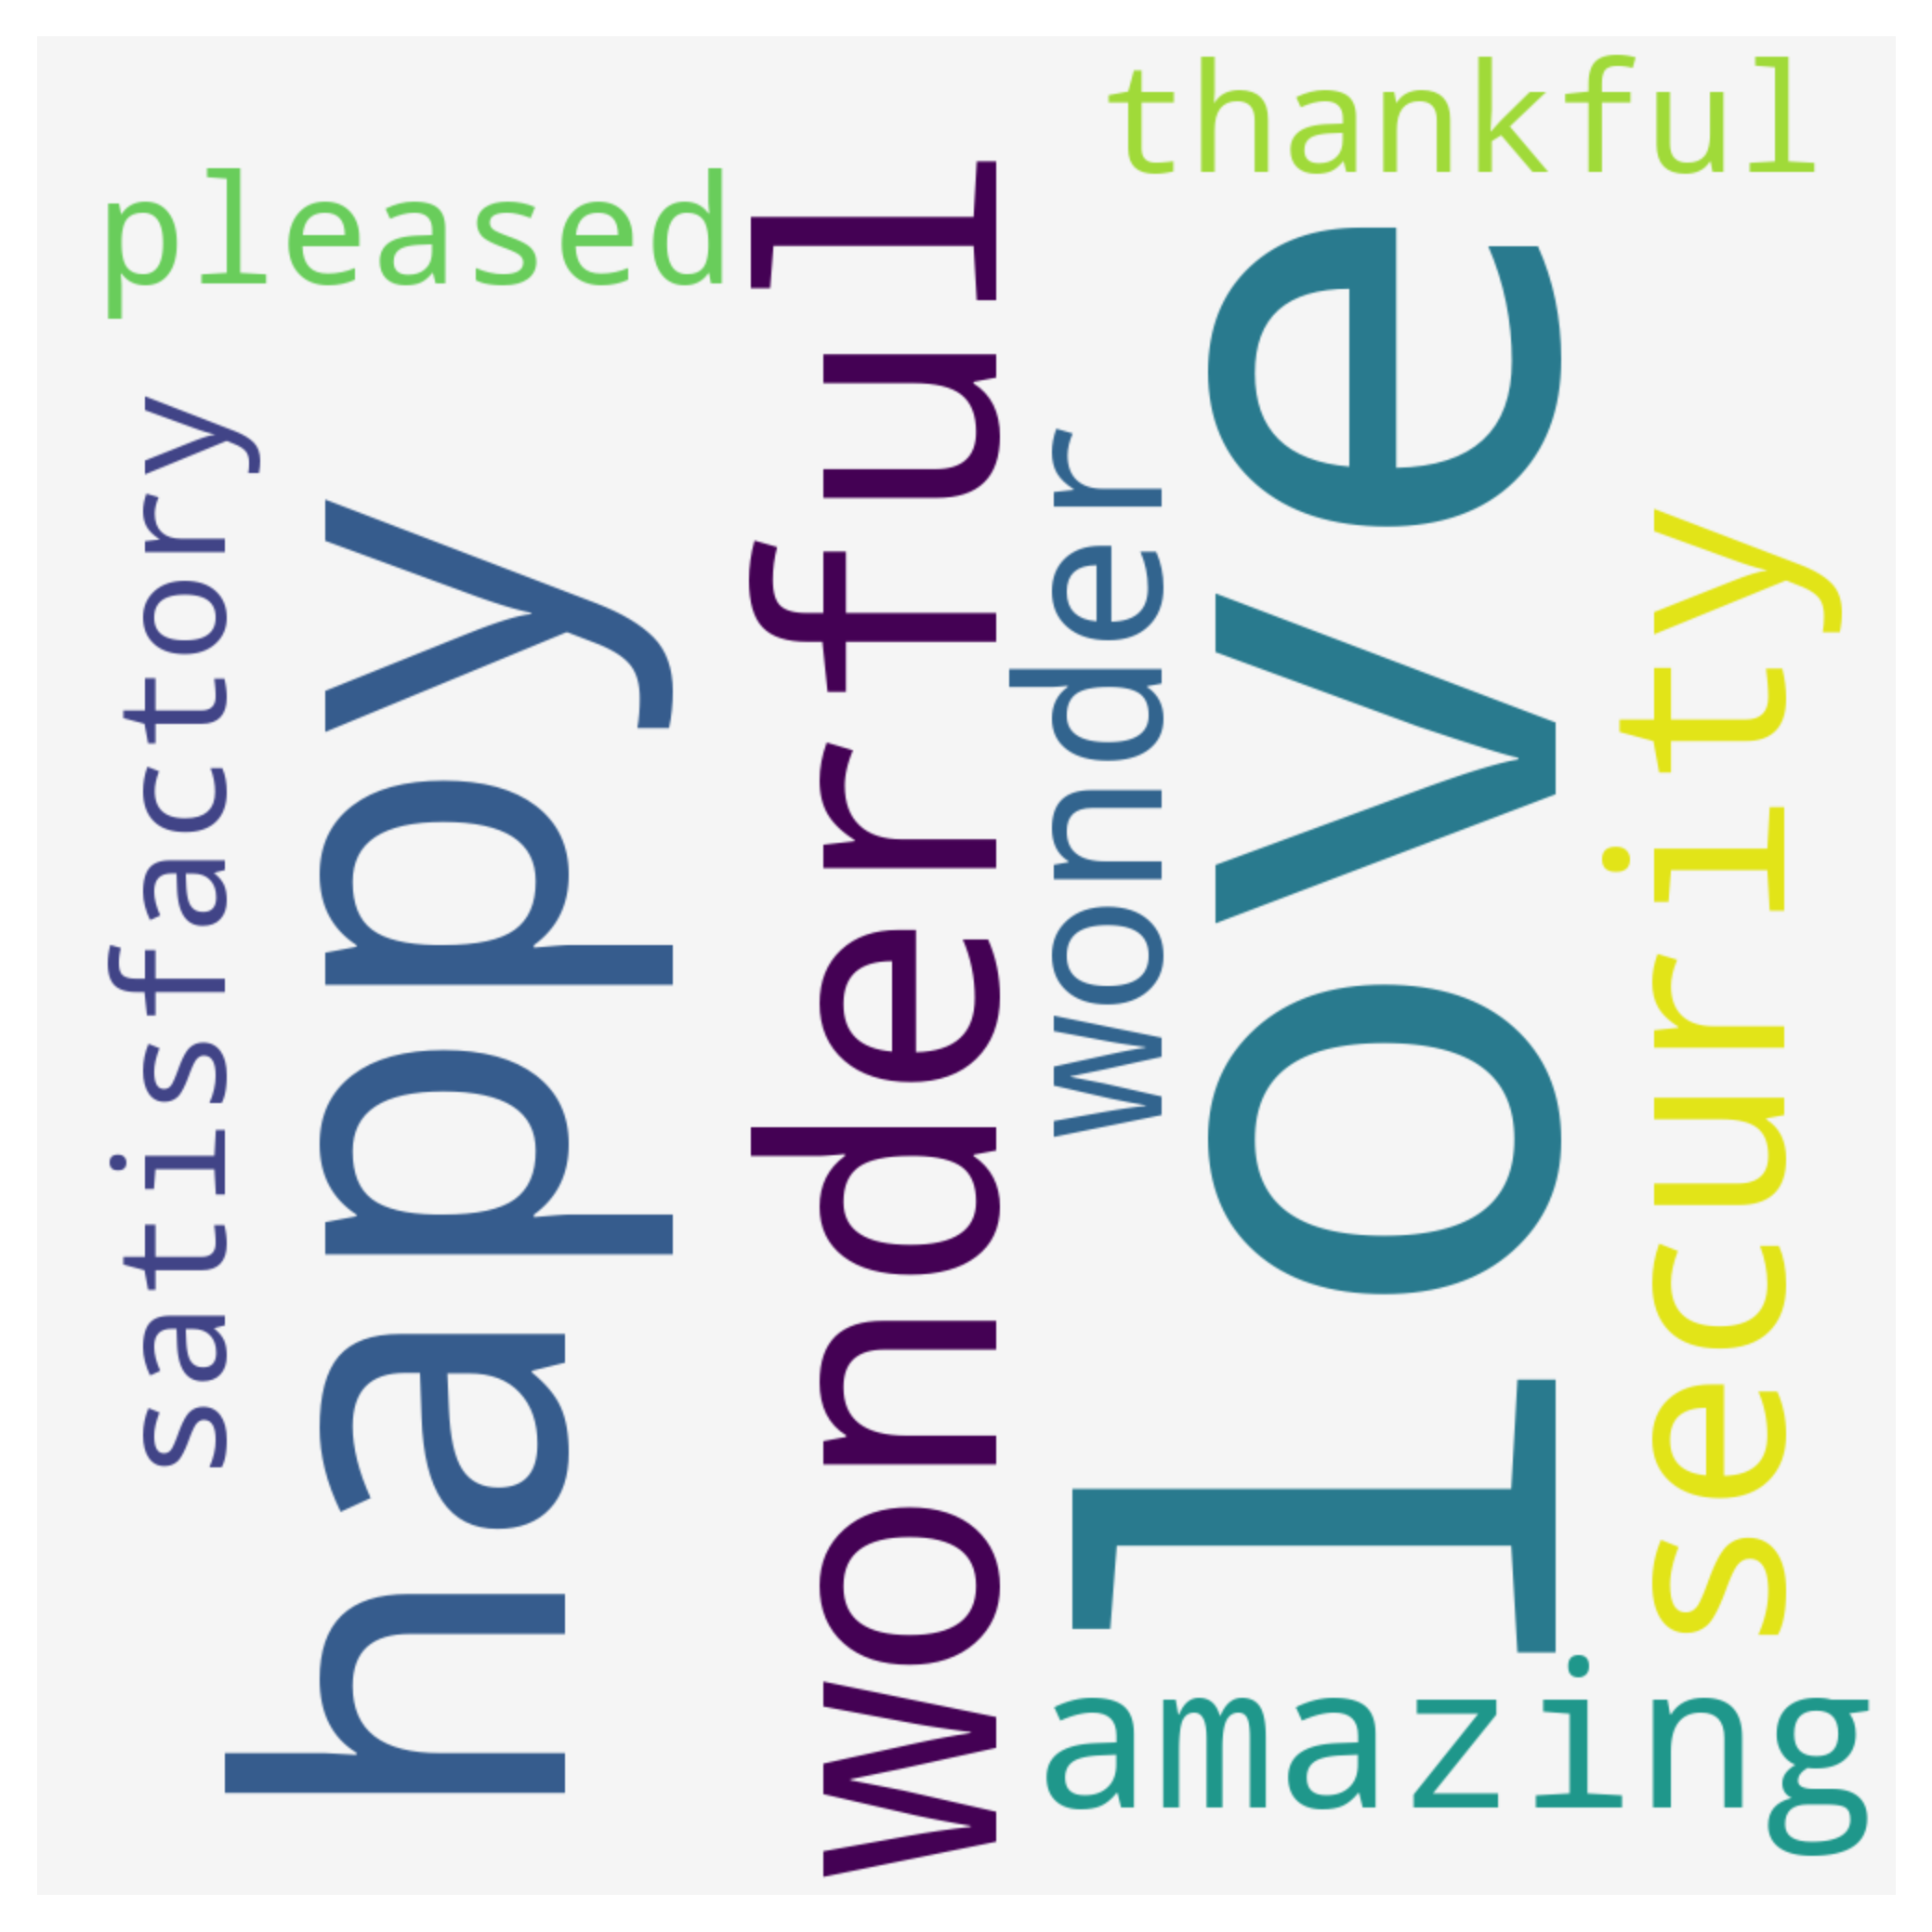

In [204]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v


wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Hangouts_positive_words.pdf')
plt.show()

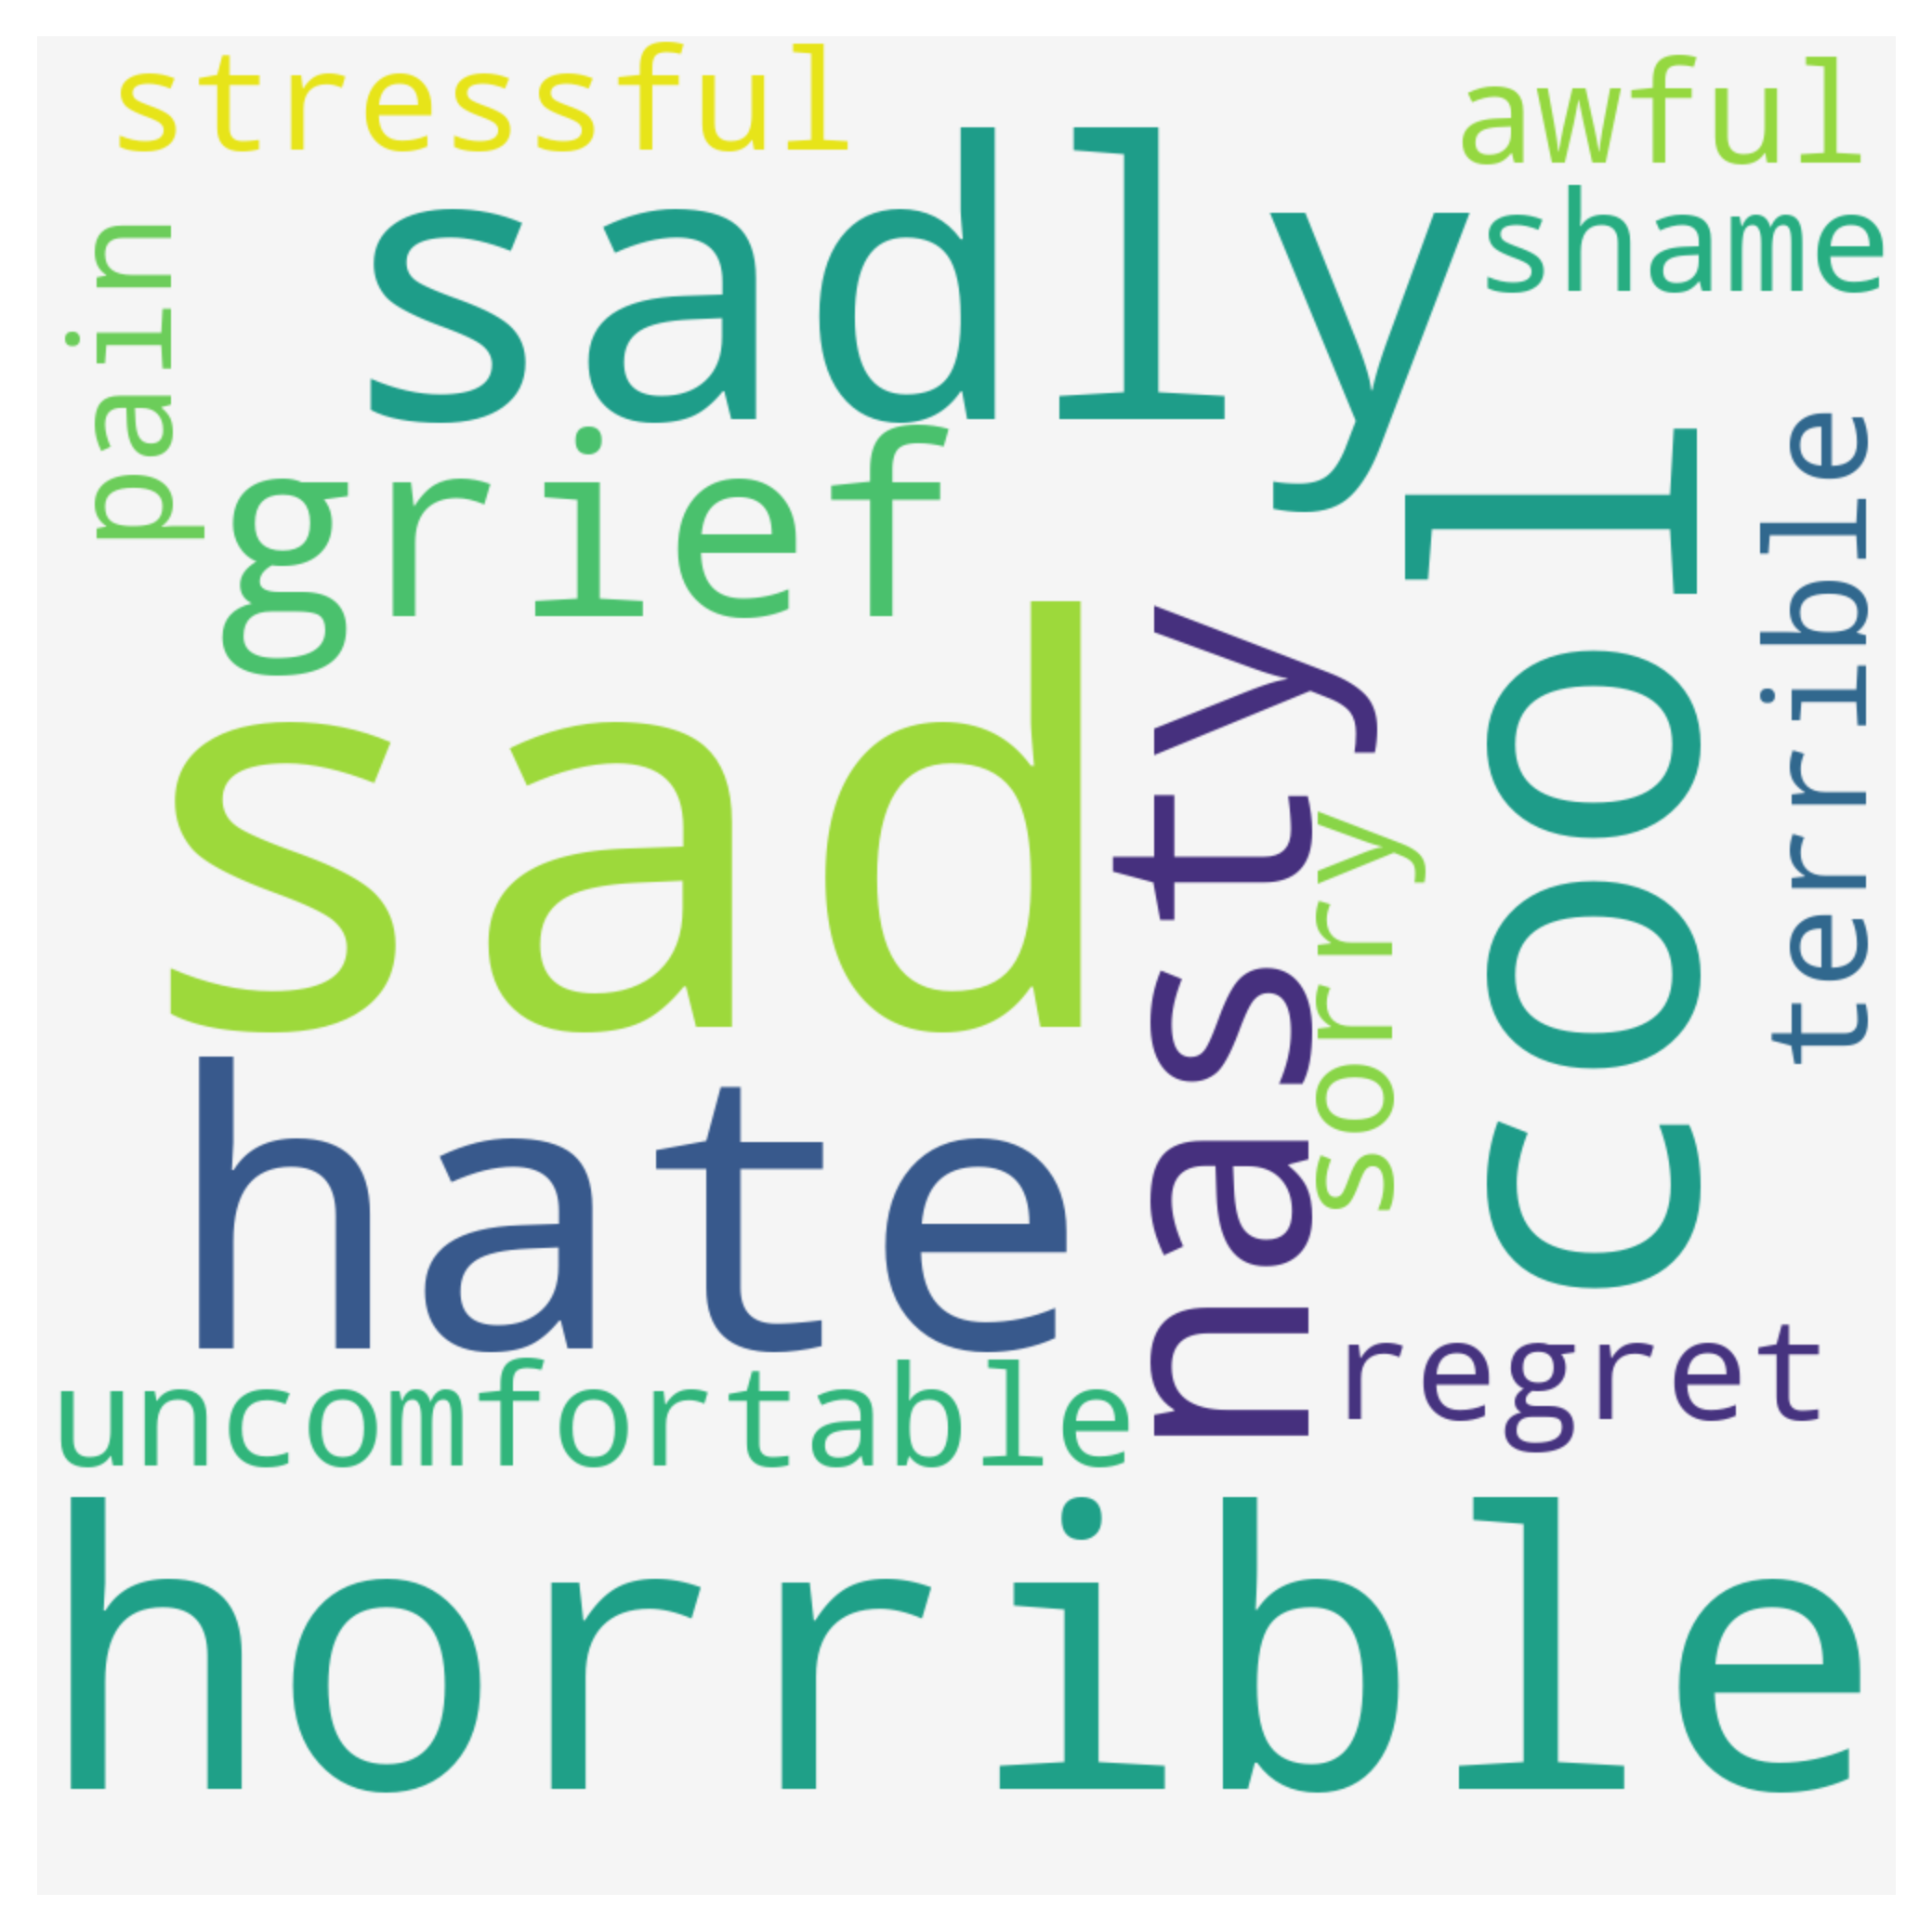

In [205]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Hangouts_negative_words.pdf')
plt.show()

# Whatsapp

In [91]:
df1=df.loc[df['App Name'] == "Whatsapp"]

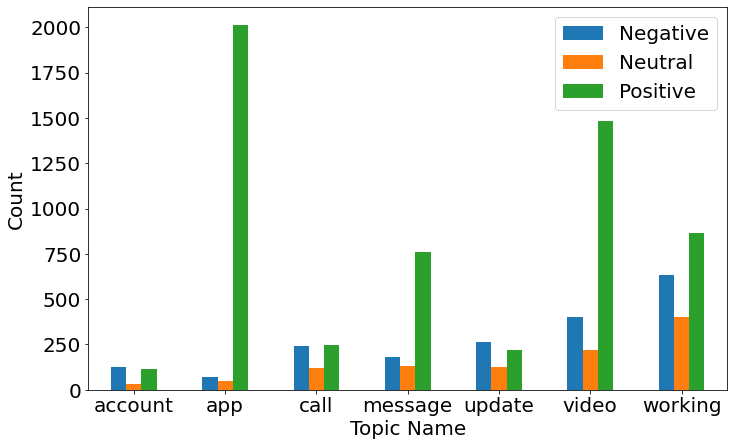

In [92]:
results = df1.groupby(['Dominant_topic', 'sentiment']).count().reset_index()
results = results[results.Dominant_topic != 2]
results = results[results.Dominant_topic != 1]
results = results[results.Dominant_topic != 9]
results = results.merge(all_topics, on='Dominant_topic')
results['Topic Name'] = results['topic_name'].apply(', '.join)

graph_results = results[['Topic Name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Topic Name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Topic Name', inplace=True)

fig = graph_results.plot.bar(rot=0, figsize=(10,6),fontsize=20)
fig.legend(fontsize=20)
plt.xlabel('Topic Name', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout(pad=0)
fig.figure.savefig('Whatsapp_Topic_Sentiment.pdf', bbox_inches='tight')

In [208]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df1['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df1.loc[df1['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass
                    

unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

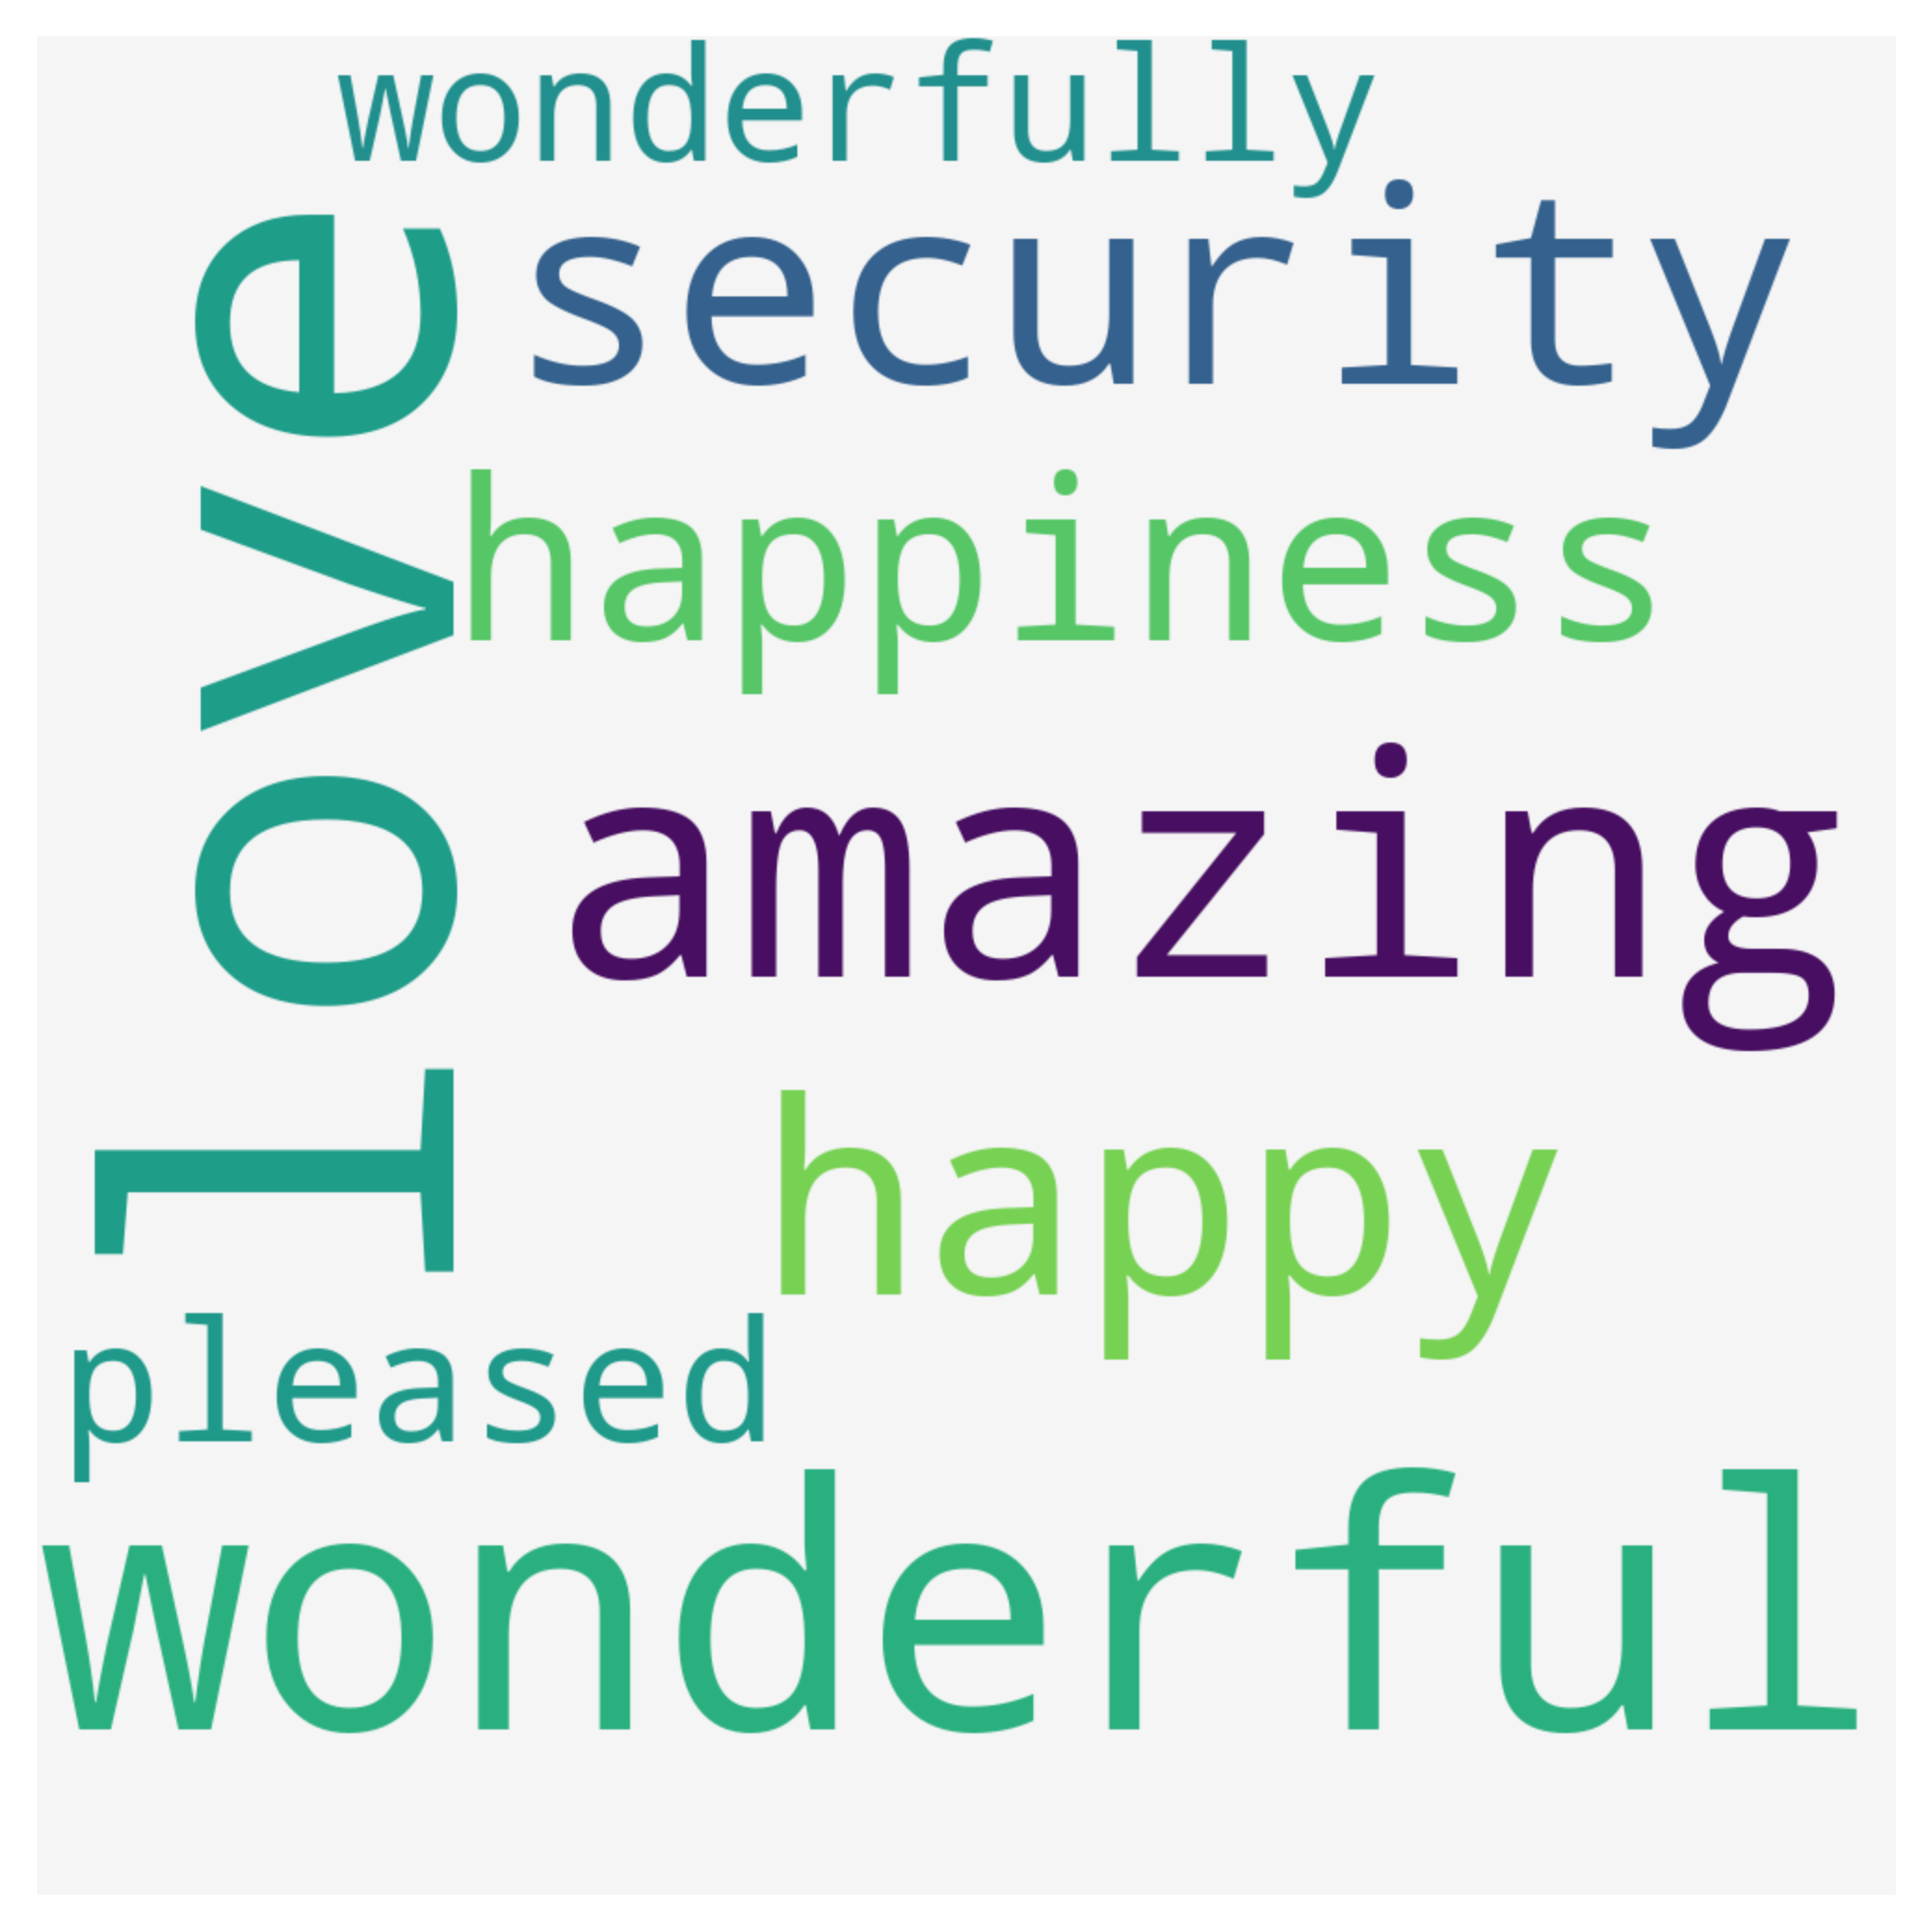

In [209]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v


wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Mircrosoft_positive_words.pdf')
plt.show()

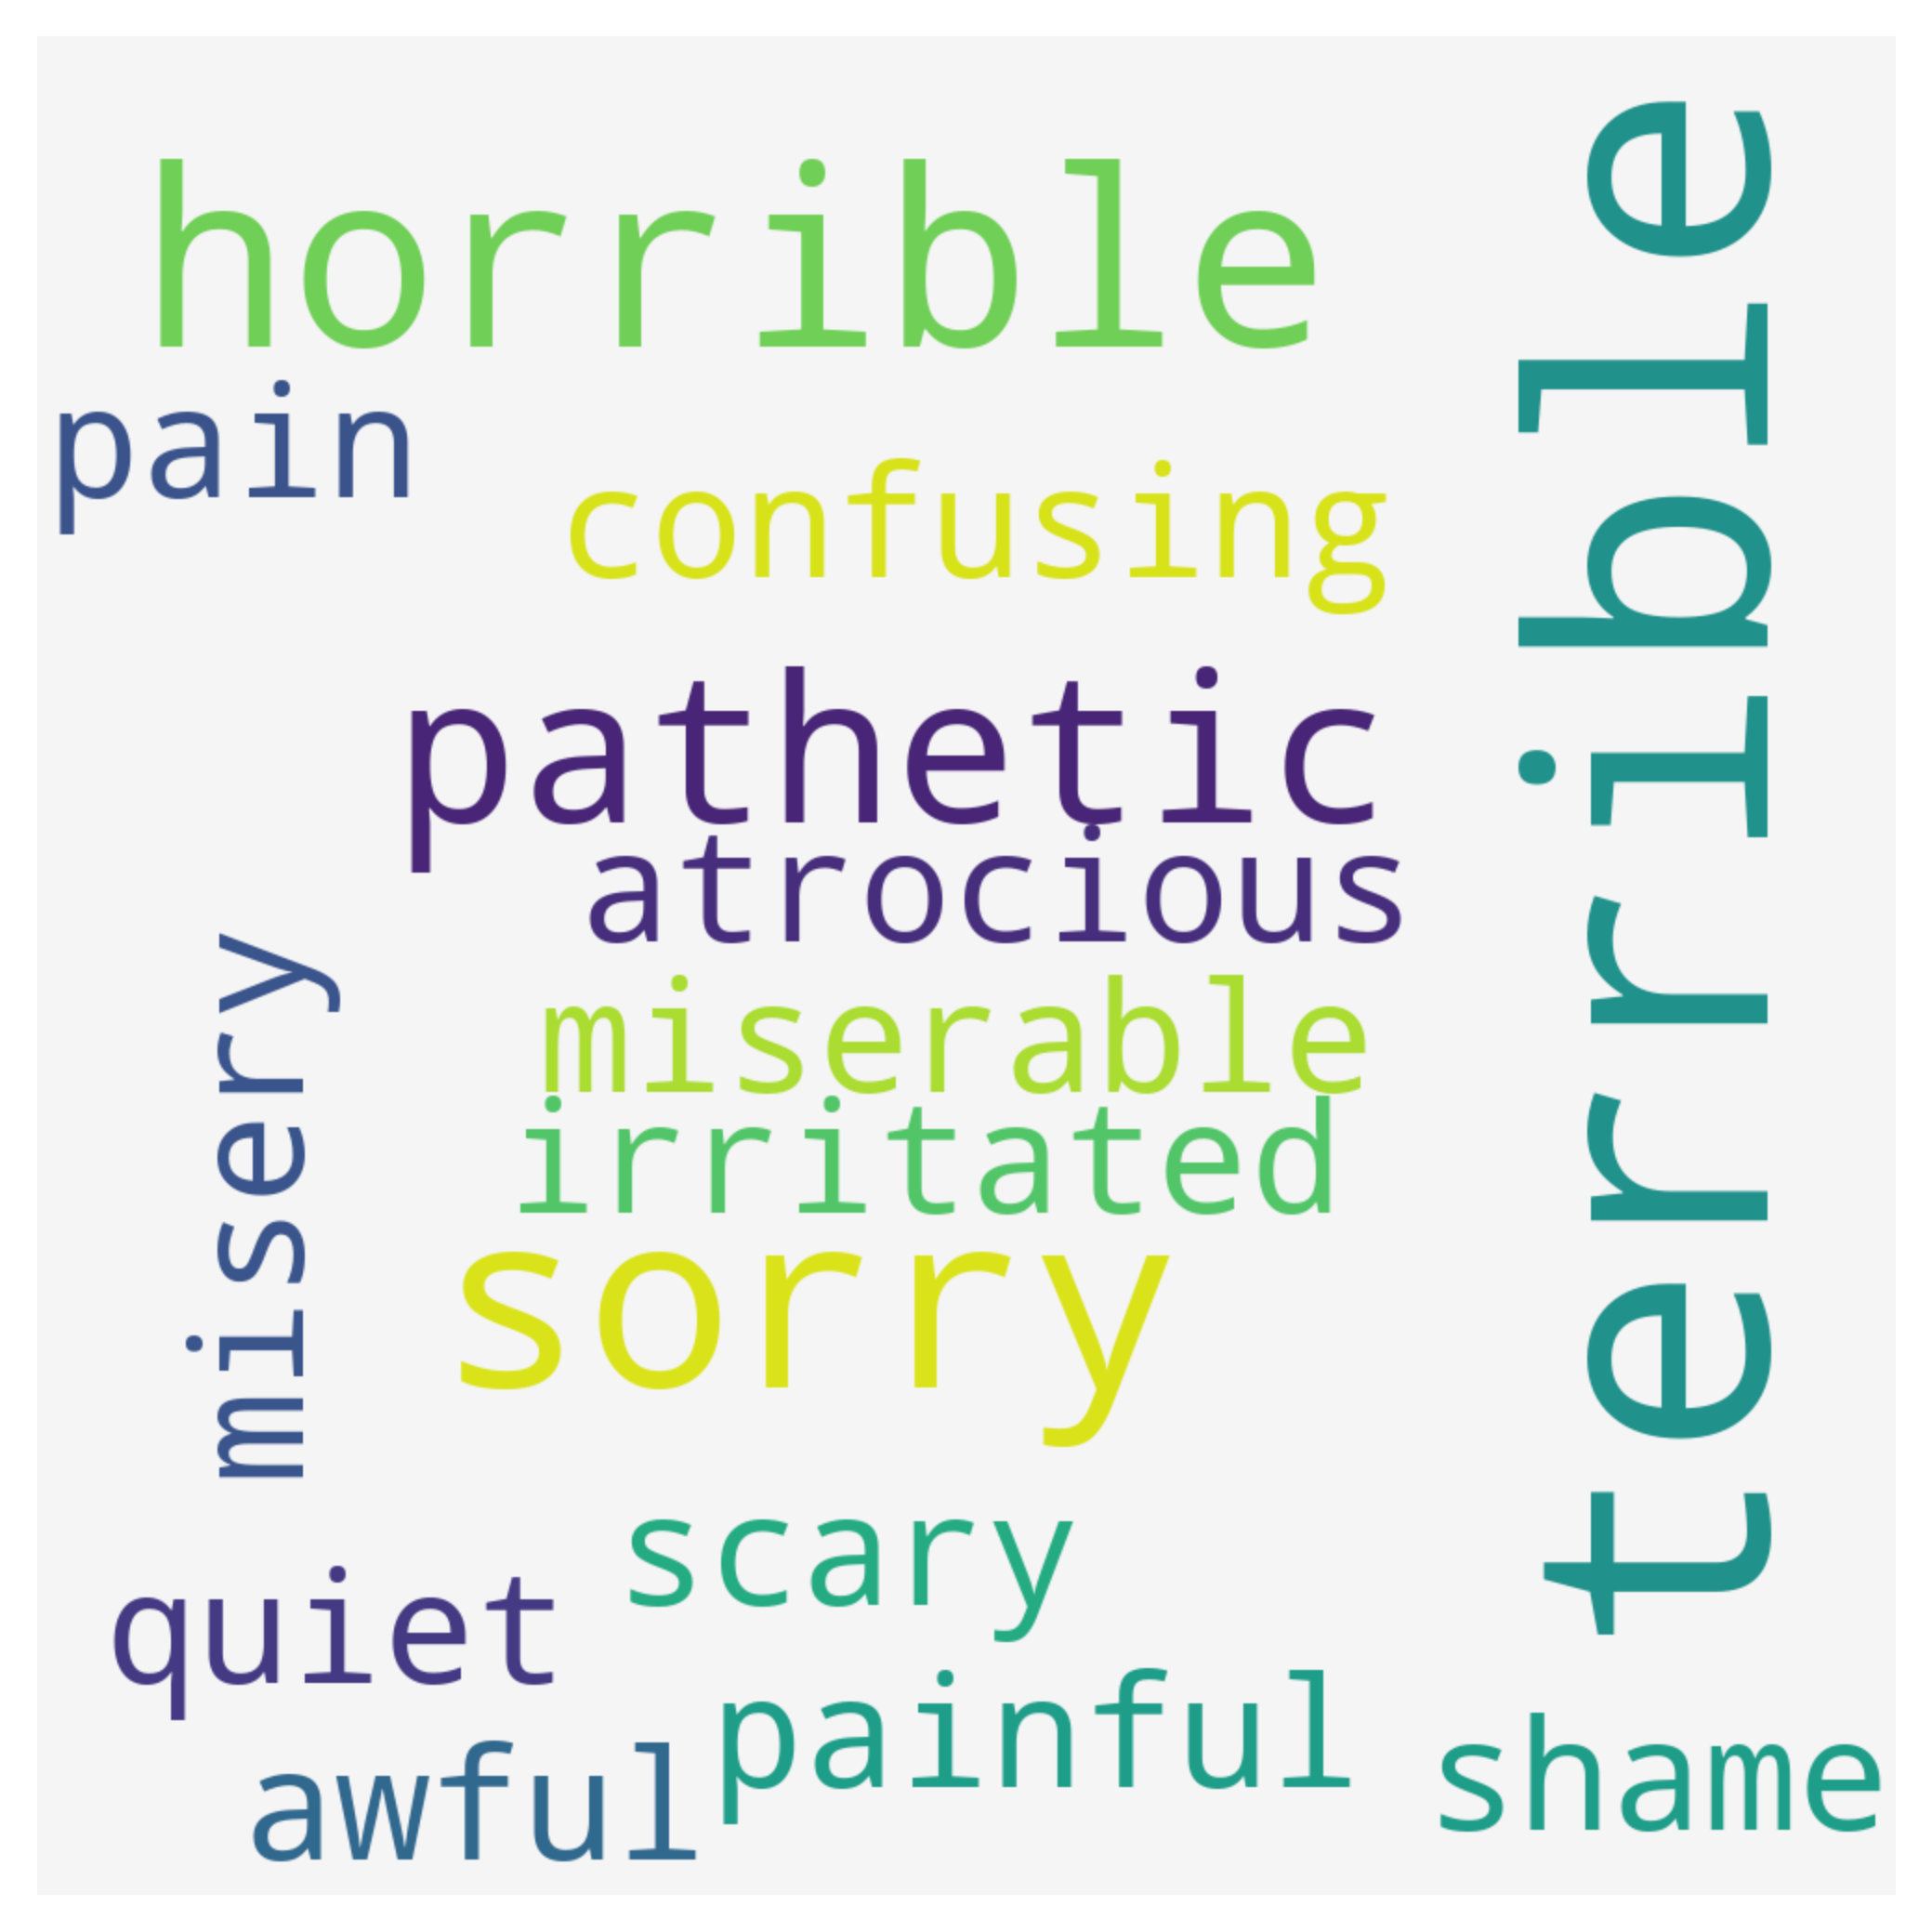

In [210]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(5,5),dpi=400)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('Microsoft_negative_words.pdf')
plt.show()

In [128]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [129]:
df["cleanText"]=df["cleanText"].astype(str)

In [130]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
Lable= label_encoder.fit_transform(df["sentiment"])
from collections import Counter
Counter(Lable)

Counter({2: 29196, 0: 14279, 1: 6525})

In [131]:
from collections import Counter
Counter(df["sentiment"])

Counter({'Positive': 29196, 'Negative': 14279, 'Neutral': 6525})

In [21]:
# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["cleanText"], Lable, test_size=0.20, shuffle=True)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = CountVectorizer()
# 3. fit
# 4. transform training data
X_train_dtf = vect.fit_transform(X_train)
X_test_dtf = vect.transform(X_test)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = TfidfVectorizer()
# 3. fit
# 4. transform training data
X_train_tf = vect.fit_transform(X_train)
X_test_tf = vect.transform(X_test)

In [24]:
from sklearn.feature_extraction.text import HashingVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = HashingVectorizer()
# 3. fit
# 4. transform training data
X_train_h = vect.fit_transform(X_train)
X_test_h = vect.transform(X_test)

In [25]:
from sklearn.svm import SVC
print("SVC")
dt = SVC(kernel='linear', C=5.0, random_state=500,probability=True)
dtP1=dt.fit(X_train_dtf, y_train).predict(X_test_dtf)
dtPre1=dt.fit(X_train_dtf, y_train).predict_proba(X_test_dtf)
print(accuracy_score(y_test,dtP1))
print(classification_report(y_test,dtP1))
print(confusion_matrix(y_test,dtP1))

SVC
0.9004
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2817
           1       0.84      0.80      0.82      1324
           2       0.94      0.93      0.94      5859

    accuracy                           0.90     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.90      0.90      0.90     10000

[[2483  107  227]
 [ 154 1054  116]
 [ 301   91 5467]]


In [26]:
from sklearn.svm import SVC
print("SVC")
dt = SVC(kernel='linear', C=5.0, random_state=500,probability=True)
dtP2=dt.fit(X_train_tf, y_train).predict(X_test_tf)
dtPre2=dt.fit(X_train_tf, y_train).predict_proba(X_test_tf)
print(accuracy_score(y_test,dtP2))
print(classification_report(y_test,dtP2))
print(confusion_matrix(y_test,dtP2))

SVC
0.9089
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2817
           1       0.88      0.80      0.84      1324
           2       0.94      0.94      0.94      5859

    accuracy                           0.91     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.91      0.91      0.91     10000

[[2501   82  234]
 [ 151 1062  111]
 [ 271   62 5526]]


In [27]:
from sklearn.svm import SVC
print("SVC")
dt = SVC(kernel='linear', C=5.0, random_state=500,probability=True)
dtP3=dt.fit(X_train_h, y_train).predict(X_test_h)
dtPre3=dt.fit(X_train_h, y_train).predict_proba(X_test_h)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

SVC
0.9161
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2817
           1       0.89      0.83      0.86      1324
           2       0.94      0.95      0.95      5859

    accuracy                           0.92     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.92      0.92      0.92     10000

[[2500   72  245]
 [ 122 1097  105]
 [ 235   60 5564]]


In [98]:
from sklearn.tree import DecisionTreeClassifier
print("DT")
dt=DecisionTreeClassifier(max_depth=300)
dtP1=dt.fit(X_train_dtf, y_train).predict(X_test_dtf)
dtPre1=dt.fit(X_train_dtf, y_train).predict_proba(X_test_dtf)
print(accuracy_score(y_test,dtP1))
print(classification_report(y_test,dtP1))
print(confusion_matrix(y_test,dtP1))

DT
0.833
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2825
           1       0.78      0.83      0.80      1300
           2       0.88      0.88      0.88      5875

    accuracy                           0.83     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.83      0.83      0.83     10000

[[2070  170  585]
 [ 121 1074  105]
 [ 564  125 5186]]


In [99]:
from sklearn.tree import DecisionTreeClassifier
print("DT")
dt=DecisionTreeClassifier(max_depth=300)
dtP2=dt.fit(X_train_tf, y_train).predict(X_test_tf)
dtPre2=dt.fit(X_train_tf, y_train).predict_proba(X_test_tf)
print(accuracy_score(y_test,dtP2))
print(classification_report(y_test,dtP2))
print(confusion_matrix(y_test,dtP2))

DT
0.8164
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      2825
           1       0.75      0.81      0.78      1300
           2       0.87      0.87      0.87      5875

    accuracy                           0.82     10000
   macro avg       0.78      0.80      0.79     10000
weighted avg       0.82      0.82      0.82     10000

[[2012  188  625]
 [ 123 1056  121]
 [ 609  170 5096]]


In [100]:
from sklearn.tree import DecisionTreeClassifier
print("DT")
dt=DecisionTreeClassifier(max_depth=300)
dtP3=dt.fit(X_train_h, y_train).predict(X_test_h)
dtPre3=dt.fit(X_train_h, y_train).predict_proba(X_test_h)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

DT
0.8192
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      2825
           1       0.76      0.79      0.77      1300
           2       0.87      0.87      0.87      5875

    accuracy                           0.82     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.82      0.82      0.82     10000

[[2042  177  606]
 [ 130 1024  146]
 [ 601  148 5126]]


In [101]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
dt = RandomForestClassifier(n_estimators=300, random_state=5, max_depth=300) 
dtP1=dt.fit(X_train_dtf, y_train).predict(X_test_dtf)
dtPre1=dt.fit(X_train_dtf, y_train).predict_proba(X_test_dtf)
print(accuracy_score(y_test,dtP1))
print(classification_report(y_test,dtP1))
print(confusion_matrix(y_test,dtP1))

RF
0.8468
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      2825
           1       0.80      0.70      0.75      1300
           2       0.86      0.94      0.90      5875

    accuracy                           0.85     10000
   macro avg       0.83      0.79      0.81     10000
weighted avg       0.85      0.85      0.84     10000

[[2042  142  641]
 [  98  913  289]
 [ 270   92 5513]]


In [102]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
dt = RandomForestClassifier(n_estimators=300, random_state=5, max_depth=300) 
dtP2=dt.fit(X_train_tf, y_train).predict(X_test_tf)
dtPre2=dt.fit(X_train_tf, y_train).predict_proba(X_test_tf)
print(accuracy_score(y_test,dtP2))
print(classification_report(y_test,dtP2))
print(confusion_matrix(y_test,dtP2))

RF
0.8387
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      2825
           1       0.81      0.61      0.70      1300
           2       0.84      0.94      0.89      5875

    accuracy                           0.84     10000
   macro avg       0.83      0.76      0.79     10000
weighted avg       0.84      0.84      0.83     10000

[[2045  110  670]
 [ 139  797  364]
 [ 255   75 5545]]


In [103]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
dt = RandomForestClassifier(n_estimators=300, random_state=5, max_depth=300) 
dtP3=dt.fit(X_train_h, y_train).predict(X_test_h)
dtPre3=dt.fit(X_train_h, y_train).predict_proba(X_test_h)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

RF
0.7124
              precision    recall  f1-score   support

           0       0.89      0.41      0.56      2825
           1       0.93      0.14      0.25      1300
           2       0.68      0.98      0.80      5875

    accuracy                           0.71     10000
   macro avg       0.83      0.51      0.54     10000
weighted avg       0.77      0.71      0.66     10000

[[1155   10 1660]
 [  55  185 1060]
 [  87    4 5784]]


In [104]:
from sklearn.linear_model import LogisticRegression
dt = LogisticRegression(random_state=1000, solver='saga',multi_class='multinomial',C=2.0)
dtP1=dt.fit(X_train_dtf, y_train).predict(X_test_dtf)
dtPre1=dt.fit(X_train_dtf, y_train).predict_proba(X_test_dtf)
print(accuracy_score(y_test,dtP1))
print(classification_report(y_test,dtP1))
print(confusion_matrix(y_test,dtP1))

C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.902
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      2825
           1       0.81      0.83      0.82      1300
           2       0.93      0.94      0.94      5875

    accuracy                           0.90     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.90      0.90      0.90     10000

[[2406  151  268]
 [ 106 1075  119]
 [ 231  105 5539]]


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [105]:
from sklearn.linear_model import LogisticRegression
dt = LogisticRegression(random_state=1000, solver='saga',multi_class='multinomial',C=2.0)
dtP2=dt.fit(X_train_tf, y_train).predict(X_test_tf)
dtPre2=dt.fit(X_train_tf, y_train).predict_proba(X_test_tf)
print(accuracy_score(y_test,dtP2))
print(classification_report(y_test,dtP2))
print(confusion_matrix(y_test,dtP2))

0.9032
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2825
           1       0.85      0.79      0.82      1300
           2       0.93      0.95      0.94      5875

    accuracy                           0.90     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.90      0.90      0.90     10000

[[2431  116  278]
 [ 113 1026  161]
 [ 228   72 5575]]


In [106]:
from sklearn.linear_model import LogisticRegression
dt = LogisticRegression(random_state=1000, solver='saga',multi_class='multinomial',C=2.0)
dtP3=dt.fit(X_train_h, y_train).predict(X_test_h)
dtPre3=dt.fit(X_train_h, y_train).predict_proba(X_test_h)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

0.9015
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2825
           1       0.84      0.82      0.83      1300
           2       0.93      0.95      0.94      5875

    accuracy                           0.90     10000
   macro avg       0.88      0.87      0.88     10000
weighted avg       0.90      0.90      0.90     10000

[[2389  131  305]
 [ 111 1070  119]
 [ 239   80 5556]]


In [107]:
from sklearn.neighbors import KNeighborsClassifier
print("KNN")
dt = KNeighborsClassifier() 

dtP1=dt.fit(X_train_dtf, y_train).predict(X_test_dtf)
dtPre1=dt.fit(X_train_dtf, y_train).predict_proba(X_test_dtf)
print(accuracy_score(y_test,dtP1))
print(classification_report(y_test,dtP1))
print(confusion_matrix(y_test,dtP1))

KNN
0.6125
              precision    recall  f1-score   support

           0       0.63      0.31      0.42      2825
           1       0.29      0.74      0.42      1300
           2       0.81      0.73      0.77      5875

    accuracy                           0.61     10000
   macro avg       0.58      0.60      0.53     10000
weighted avg       0.69      0.61      0.62     10000

[[ 888 1200  737]
 [  98  968  234]
 [ 427 1179 4269]]


In [108]:
from sklearn.neighbors import KNeighborsClassifier
print("KNN")
dt = KNeighborsClassifier() 
dtP2=dt.fit(X_train_tf, y_train).predict(X_test_tf)
dtPre2=dt.fit(X_train_tf, y_train).predict_proba(X_test_tf)
print(accuracy_score(y_test,dtP2))
print(classification_report(y_test,dtP2))
print(confusion_matrix(y_test,dtP2))

KNN
0.5927
              precision    recall  f1-score   support

           0       0.58      0.45      0.51      2825
           1       0.26      0.62      0.36      1300
           2       0.82      0.65      0.73      5875

    accuracy                           0.59     10000
   macro avg       0.55      0.58      0.53     10000
weighted avg       0.68      0.59      0.62     10000

[[1279  989  557]
 [ 226  808  266]
 [ 683 1352 3840]]


In [109]:
from sklearn.neighbors import KNeighborsClassifier
print("KNN")
dt = KNeighborsClassifier() 
dtP3=dt.fit(X_train_h, y_train).predict(X_test_h)
dtPre3=dt.fit(X_train_h, y_train).predict_proba(X_test_h)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

KNN
0.6324
              precision    recall  f1-score   support

           0       0.60      0.45      0.52      2825
           1       0.30      0.63      0.40      1300
           2       0.83      0.72      0.77      5875

    accuracy                           0.63     10000
   macro avg       0.58      0.60      0.56     10000
weighted avg       0.69      0.63      0.65     10000

[[1281  932  612]
 [ 213  821  266]
 [ 635 1018 4222]]


In [142]:
# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rounded_predictions, Lable, test_size=0.20, shuffle=True)

In [143]:
from sklearn.linear_model import LogisticRegression
dt = LogisticRegression(random_state=1000, solver='saga',multi_class='multinomial',C=2.0)
dtP3=dt.fit(X_train, y_train).predict(X_test)
dtPre3=dt.fit(X_train, y_train).predict_proba(X_test)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

0.5846
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2870
           1       0.00      0.00      0.00      1284
           2       0.58      1.00      0.74      5846

    accuracy                           0.58     10000
   macro avg       0.19      0.33      0.25     10000
weighted avg       0.34      0.58      0.43     10000

[[   0    0 2870]
 [   0    0 1284]
 [   0    0 5846]]


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [144]:
from sklearn.neighbors import KNeighborsClassifier
print("KNN")
dt = KNeighborsClassifier() 

dtP3=dt.fit(X_train, y_train).predict(X_test)
dtPre3=dt.fit(X_train, y_train).predict_proba(X_test)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

KNN
0.5664
              precision    recall  f1-score   support

           0       0.38      0.33      0.36      2870
           1       0.43      0.33      0.37      1284
           2       0.66      0.73      0.69      5846

    accuracy                           0.57     10000
   macro avg       0.49      0.47      0.47     10000
weighted avg       0.55      0.57      0.56     10000

[[ 957  240 1673]
 [ 297  423  564]
 [1243  319 4284]]


In [145]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
dt = RandomForestClassifier(n_estimators=300, random_state=5, max_depth=300) 

dtP3=dt.fit(X_train, y_train).predict(X_test)
dtPre3=dt.fit(X_train, y_train).predict_proba(X_test)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

RF
0.5954
              precision    recall  f1-score   support

           0       0.72      0.01      0.01      2870
           1       0.85      0.08      0.15      1284
           2       0.59      1.00      0.74      5846

    accuracy                           0.60     10000
   macro avg       0.72      0.36      0.30     10000
weighted avg       0.66      0.60      0.46     10000

[[  18   11 2841]
 [   0  104 1180]
 [   7    7 5832]]


In [146]:
from sklearn.tree import DecisionTreeClassifier
print("DT")
dt=DecisionTreeClassifier(max_depth=300)
dtP3=dt.fit(X_train, y_train).predict(X_test)
dtPre3=dt.fit(X_train, y_train).predict_proba(X_test)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

DT
0.4676
              precision    recall  f1-score   support

           0       0.32      0.32      0.32      2870
           1       0.21      0.23      0.22      1284
           2       0.60      0.59      0.60      5846

    accuracy                           0.47     10000
   macro avg       0.38      0.38      0.38     10000
weighted avg       0.47      0.47      0.47     10000

[[ 917  356 1597]
 [ 300  292  692]
 [1645  734 3467]]


In [147]:
from sklearn.svm import SVC
print("SVC")
dt = SVC(kernel='linear', C=5.0, random_state=500,probability=True)
dtP3=dt.fit(X_train, y_train).predict(X_test)
dtPre3=dt.fit(X_train, y_train).predict_proba(X_test)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

SVC
0.5846
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2870
           1       0.00      0.00      0.00      1284
           2       0.58      1.00      0.74      5846

    accuracy                           0.58     10000
   macro avg       0.19      0.33      0.25     10000
weighted avg       0.34      0.58      0.43     10000

[[   0    0 2870]
 [   0    0 1284]
 [   0    0 5846]]


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohail_Comp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import glob
import cv2
import tensorflow as tf
from keras import layers
from keras.layers import Dropout , Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
import keras.backend as K
from sklearn.utils import shuffle
# importing all necessary libraries to run the code
import re,string
import numpy as np
import pandas as pd
import keras_metrics
import tensorflow.keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding
# using the variable sw to hold all stopwords that are in English
sw = stopwords.words('english')

In [133]:
from keras import optimizers
import tensorflow.keras
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words=5000, lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df["cleanText"].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(df["cleanText"].values)
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X)

Y = pd.get_dummies(Lable).values

X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state =2)
batch_size=128

In [134]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding
from keras.models import Sequential
model_conv = Sequential()
model_conv.add(Embedding(5000,200, input_length=X.shape[1]))
model_conv.add(Dropout(0.5))
model_conv.add(LSTM(128))
model_conv.add(Dropout(0.5))

model_conv.summary()
rounded_predictions = model_conv.predict(X, batch_size=128, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 185, 200)          1000000   
                                                                 
 dropout_2 (Dropout)         (None, 185, 200)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               168448    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
Total params: 1,168,448
Trainable params: 1,168,448
Non-trainable params: 0
_________________________________________________________________


In [141]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(256, 2, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(Flatten())
model_conv.add(Dense(128, activation='softmax'))

model_conv.summary()
rounded_predictions = model_conv.predict(X, batch_size=128, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 185, 100)          500000    
                                                                 
 dropout_4 (Dropout)         (None, 185, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 184, 256)          51456     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 92, 256)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 23552)             0         
                                                                 
 dense (Dense)               (None, 128)               3014784   
                                                      

In [24]:

#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(Dropout(0.5))
model_conv.add(LSTM(128))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',   metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
#Y = data.Reviewer_Score

pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


313/313 - 107s - loss: 0.5618 - accuracy: 0.7702 - mae: 0.2202 - mse: 0.1062 - precision: 0.5995 - recall: 0.2673 - f1_score: 0.3503 - val_loss: 0.3393 - val_accuracy: 0.8916 - val_mae: 0.1269 - val_mse: 0.0578 - val_precision: 0.8114 - val_recall: 0.5713 - val_f1_score: 0.6704 - 107s/epoch - 341ms/step
Epoch 2/100
313/313 - 102s - loss: 0.3109 - accuracy: 0.8991 - mae: 0.1095 - mse: 0.0526 - precision: 0.8363 - recall: 0.6609 - f1_score: 0.7381 - val_loss: 0.2774 - val_accuracy: 0.9095 - val_mae: 0.0949 - val_mse: 0.0461 - val_precision: 0.8490 - val_recall: 0.7134 - val_f1_score: 0.7753 - 102s/epoch - 326ms/step
Epoch 3/100
313/313 - 103s - loss: 0.2445 - accuracy: 0.9252 - mae: 0.0830 - mse: 0.0397 - precision: 0.8592 - recall: 0.7471 - f1_score: 0.7992 - val_loss: 0.2513 - val_accuracy: 0.9212 - val_mae: 0.0800 - val_mse: 0.0412 - val_precision: 0.8661 - val_recall: 0.7725 - val_f1_score: 0.8166 - 103s/epoch - 330ms/step
Epoch 4/100
313/313 - 105s - loss: 0.2176 - accuracy: 0.9341 

Epoch 19/100
313/313 - 98s - loss: 0.0616 - accuracy: 0.9789 - mae: 0.0220 - mse: 0.0106 - precision: 0.9261 - recall: 0.9143 - f1_score: 0.9201 - val_loss: 0.2395 - val_accuracy: 0.9388 - val_mae: 0.0472 - val_mse: 0.0324 - val_precision: 0.9271 - val_recall: 0.9156 - val_f1_score: 0.9213 - 98s/epoch - 314ms/step
Epoch 20/100
313/313 - 98s - loss: 0.0589 - accuracy: 0.9795 - mae: 0.0213 - mse: 0.0102 - precision: 0.9281 - recall: 0.9169 - f1_score: 0.9225 - val_loss: 0.2556 - val_accuracy: 0.9392 - val_mae: 0.0467 - val_mse: 0.0329 - val_precision: 0.9290 - val_recall: 0.9182 - val_f1_score: 0.9236 - 98s/epoch - 313ms/step
Epoch 21/100
313/313 - 98s - loss: 0.0570 - accuracy: 0.9797 - mae: 0.0205 - mse: 0.0099 - precision: 0.9299 - recall: 0.9195 - f1_score: 0.9246 - val_loss: 0.2506 - val_accuracy: 0.9418 - val_mae: 0.0445 - val_mse: 0.0316 - val_precision: 0.9307 - val_recall: 0.9206 - val_f1_score: 0.9256 - 98s/epoch - 312ms/step
Epoch 22/100
313/313 - 105s - loss: 0.0551 - accurac

Epoch 45/100
313/313 - 305s - loss: 0.0209 - accuracy: 0.9932 - mae: 0.0076 - mse: 0.0036 - precision: 0.9527 - recall: 0.9498 - f1_score: 0.9512 - val_loss: 0.3754 - val_accuracy: 0.9350 - val_mae: 0.0447 - val_mse: 0.0374 - val_precision: 0.9529 - val_recall: 0.9502 - val_f1_score: 0.9515 - 305s/epoch - 975ms/step
Epoch 46/100
313/313 - 322s - loss: 0.0195 - accuracy: 0.9938 - mae: 0.0070 - mse: 0.0033 - precision: 0.9531 - recall: 0.9505 - f1_score: 0.9518 - val_loss: 0.3502 - val_accuracy: 0.9385 - val_mae: 0.0436 - val_mse: 0.0356 - val_precision: 0.9534 - val_recall: 0.9508 - val_f1_score: 0.9521 - 322s/epoch - 1s/step
Epoch 47/100
313/313 - 210s - loss: 0.0186 - accuracy: 0.9941 - mae: 0.0068 - mse: 0.0031 - precision: 0.9536 - recall: 0.9512 - f1_score: 0.9524 - val_loss: 0.3740 - val_accuracy: 0.9417 - val_mae: 0.0415 - val_mse: 0.0348 - val_precision: 0.9539 - val_recall: 0.9515 - val_f1_score: 0.9527 - 210s/epoch - 670ms/step
Epoch 48/100
313/313 - 109s - loss: 0.0180 - accu

Epoch 71/100
313/313 - 109s - loss: 0.0124 - accuracy: 0.9964 - mae: 0.0041 - mse: 0.0020 - precision: 0.9620 - recall: 0.9614 - f1_score: 0.9617 - val_loss: 0.4073 - val_accuracy: 0.9387 - val_mae: 0.0425 - val_mse: 0.0362 - val_precision: 0.9621 - val_recall: 0.9616 - val_f1_score: 0.9618 - 109s/epoch - 348ms/step
Epoch 72/100
313/313 - 108s - loss: 0.0085 - accuracy: 0.9973 - mae: 0.0032 - mse: 0.0014 - precision: 0.9623 - recall: 0.9617 - f1_score: 0.9620 - val_loss: 0.4378 - val_accuracy: 0.9371 - val_mae: 0.0429 - val_mse: 0.0375 - val_precision: 0.9624 - val_recall: 0.9618 - val_f1_score: 0.9621 - 108s/epoch - 344ms/step
Epoch 73/100
313/313 - 105s - loss: 0.0107 - accuracy: 0.9966 - mae: 0.0037 - mse: 0.0018 - precision: 0.9625 - recall: 0.9620 - f1_score: 0.9623 - val_loss: 0.4392 - val_accuracy: 0.9385 - val_mae: 0.0420 - val_mse: 0.0365 - val_precision: 0.9627 - val_recall: 0.9621 - val_f1_score: 0.9624 - 105s/epoch - 334ms/step
Epoch 74/100
313/313 - 104s - loss: 0.0102 - a

Epoch 97/100
313/313 - 113s - loss: 0.0082 - accuracy: 0.9975 - mae: 0.0026 - mse: 0.0013 - precision: 0.9668 - recall: 0.9673 - f1_score: 0.9670 - val_loss: 0.4440 - val_accuracy: 0.9380 - val_mae: 0.0423 - val_mse: 0.0371 - val_precision: 0.9669 - val_recall: 0.9673 - val_f1_score: 0.9671 - 113s/epoch - 360ms/step
Epoch 98/100
313/313 - 112s - loss: 0.0073 - accuracy: 0.9976 - mae: 0.0027 - mse: 0.0013 - precision: 0.9669 - recall: 0.9674 - f1_score: 0.9672 - val_loss: 0.4600 - val_accuracy: 0.9372 - val_mae: 0.0429 - val_mse: 0.0375 - val_precision: 0.9670 - val_recall: 0.9675 - val_f1_score: 0.9672 - 112s/epoch - 357ms/step
Epoch 99/100
313/313 - 113s - loss: 0.0074 - accuracy: 0.9977 - mae: 0.0026 - mse: 0.0013 - precision: 0.9671 - recall: 0.9676 - f1_score: 0.9673 - val_loss: 0.4798 - val_accuracy: 0.9360 - val_mae: 0.0430 - val_mse: 0.0380 - val_precision: 0.9672 - val_recall: 0.9676 - val_f1_score: 0.9674 - 113s/epoch - 360ms/step
Epoch 100/100
313/313 - 113s - loss: 0.0071 - 

In [25]:
predict_x=model_conv.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,classes_x))
print(confusion_matrix(rounded_labels,classes_x))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2882
           1       0.93      0.81      0.87      1311
           2       0.96      0.96      0.96      5807

    accuracy                           0.94     10000
   macro avg       0.93      0.91      0.92     10000
weighted avg       0.94      0.94      0.94     10000

[[2738   33  111]
 [ 153 1064   94]
 [ 177   44 5586]]


In [24]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(256, 2, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(layers.GRU(128))
model_conv.add(Dense(16))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
batch_size=32

#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


1250/1250 - 101s - loss: 0.3917 - accuracy: 0.8538 - mae: 0.1423 - mse: 0.0706 - precision: 0.7386 - recall: 0.5672 - f1_score: 0.6323 - val_loss: 0.2506 - val_accuracy: 0.9197 - val_mae: 0.0854 - val_mse: 0.0414 - val_precision: 0.8404 - val_recall: 0.7604 - val_f1_score: 0.7984 - 101s/epoch - 81ms/step
Epoch 2/100
1250/1250 - 101s - loss: 0.2195 - accuracy: 0.9275 - mae: 0.0750 - mse: 0.0373 - precision: 0.8586 - recall: 0.8049 - f1_score: 0.8309 - val_loss: 0.2022 - val_accuracy: 0.9315 - val_mae: 0.0651 - val_mse: 0.0344 - val_precision: 0.8702 - val_recall: 0.8323 - val_f1_score: 0.8508 - 101s/epoch - 81ms/step
Epoch 3/100
1250/1250 - 102s - loss: 0.1569 - accuracy: 0.9477 - mae: 0.0534 - mse: 0.0266 - precision: 0.8804 - recall: 0.8522 - f1_score: 0.8661 - val_loss: 0.1835 - val_accuracy: 0.9431 - val_mae: 0.0540 - val_mse: 0.0298 - val_precision: 0.8892 - val_recall: 0.8654 - val_f1_score: 0.8772 - 102s/epoch - 81ms/step
Epoch 4/100
1250/1250 - 103s - loss: 0.1313 - accuracy: 0.

1250/1250 - 104s - loss: 0.0353 - accuracy: 0.9880 - mae: 0.0121 - mse: 0.0061 - precision: 0.9487 - recall: 0.9479 - f1_score: 0.9483 - val_loss: 0.3456 - val_accuracy: 0.9327 - val_mae: 0.0482 - val_mse: 0.0373 - val_precision: 0.9492 - val_recall: 0.9485 - val_f1_score: 0.9489 - 104s/epoch - 83ms/step
Epoch 20/100
1250/1250 - 103s - loss: 0.0310 - accuracy: 0.9898 - mae: 0.0105 - mse: 0.0053 - precision: 0.9497 - recall: 0.9492 - f1_score: 0.9495 - val_loss: 0.3552 - val_accuracy: 0.9346 - val_mae: 0.0459 - val_mse: 0.0368 - val_precision: 0.9502 - val_recall: 0.9500 - val_f1_score: 0.9501 - 103s/epoch - 83ms/step
Epoch 21/100
1250/1250 - 104s - loss: 0.0308 - accuracy: 0.9898 - mae: 0.0107 - mse: 0.0053 - precision: 0.9506 - recall: 0.9506 - f1_score: 0.9506 - val_loss: 0.3608 - val_accuracy: 0.9334 - val_mae: 0.0471 - val_mse: 0.0375 - val_precision: 0.9511 - val_recall: 0.9512 - val_f1_score: 0.9512 - 104s/epoch - 83ms/step
Epoch 22/100
1250/1250 - 105s - loss: 0.0281 - accuracy:

Epoch 45/100
1250/1250 - 100s - loss: 0.0163 - accuracy: 0.9948 - mae: 0.0055 - mse: 0.0027 - precision: 0.9625 - recall: 0.9651 - f1_score: 0.9638 - val_loss: 0.4239 - val_accuracy: 0.9292 - val_mae: 0.0495 - val_mse: 0.0403 - val_precision: 0.9627 - val_recall: 0.9652 - val_f1_score: 0.9639 - 100s/epoch - 80ms/step
Epoch 46/100
1250/1250 - 99s - loss: 0.0160 - accuracy: 0.9948 - mae: 0.0053 - mse: 0.0027 - precision: 0.9628 - recall: 0.9654 - f1_score: 0.9641 - val_loss: 0.4439 - val_accuracy: 0.9303 - val_mae: 0.0490 - val_mse: 0.0404 - val_precision: 0.9629 - val_recall: 0.9655 - val_f1_score: 0.9642 - 99s/epoch - 79ms/step
Epoch 47/100
1250/1250 - 100s - loss: 0.0155 - accuracy: 0.9951 - mae: 0.0053 - mse: 0.0026 - precision: 0.9630 - recall: 0.9656 - f1_score: 0.9643 - val_loss: 0.4491 - val_accuracy: 0.9313 - val_mae: 0.0478 - val_mse: 0.0393 - val_precision: 0.9632 - val_recall: 0.9658 - val_f1_score: 0.9645 - 100s/epoch - 80ms/step
Epoch 48/100
1250/1250 - 100s - loss: 0.0160 

Epoch 71/100
1250/1250 - 101s - loss: 0.0142 - accuracy: 0.9955 - mae: 0.0045 - mse: 0.0023 - precision: 0.9668 - recall: 0.9703 - f1_score: 0.9685 - val_loss: 0.4460 - val_accuracy: 0.9302 - val_mae: 0.0488 - val_mse: 0.0410 - val_precision: 0.9668 - val_recall: 0.9703 - val_f1_score: 0.9686 - 101s/epoch - 81ms/step
Epoch 72/100
1250/1250 - 101s - loss: 0.0136 - accuracy: 0.9956 - mae: 0.0047 - mse: 0.0023 - precision: 0.9669 - recall: 0.9704 - f1_score: 0.9686 - val_loss: 0.4777 - val_accuracy: 0.9266 - val_mae: 0.0504 - val_mse: 0.0427 - val_precision: 0.9669 - val_recall: 0.9705 - val_f1_score: 0.9687 - 101s/epoch - 81ms/step
Epoch 73/100
1250/1250 - 101s - loss: 0.0148 - accuracy: 0.9948 - mae: 0.0049 - mse: 0.0026 - precision: 0.9670 - recall: 0.9705 - f1_score: 0.9687 - val_loss: 0.4546 - val_accuracy: 0.9270 - val_mae: 0.0500 - val_mse: 0.0414 - val_precision: 0.9670 - val_recall: 0.9706 - val_f1_score: 0.9688 - 101s/epoch - 81ms/step
Epoch 74/100
1250/1250 - 101s - loss: 0.014

Epoch 97/100
1250/1250 - 99s - loss: 0.0135 - accuracy: 0.9954 - mae: 0.0047 - mse: 0.0024 - precision: 0.9688 - recall: 0.9729 - f1_score: 0.9708 - val_loss: 0.4650 - val_accuracy: 0.9290 - val_mae: 0.0488 - val_mse: 0.0408 - val_precision: 0.9689 - val_recall: 0.9729 - val_f1_score: 0.9709 - 99s/epoch - 80ms/step
Epoch 98/100
1250/1250 - 99s - loss: 0.0156 - accuracy: 0.9952 - mae: 0.0050 - mse: 0.0026 - precision: 0.9689 - recall: 0.9729 - f1_score: 0.9709 - val_loss: 0.4415 - val_accuracy: 0.9331 - val_mae: 0.0474 - val_mse: 0.0393 - val_precision: 0.9689 - val_recall: 0.9730 - val_f1_score: 0.9709 - 99s/epoch - 79ms/step
Epoch 99/100
1250/1250 - 99s - loss: 0.0141 - accuracy: 0.9954 - mae: 0.0047 - mse: 0.0024 - precision: 0.9689 - recall: 0.9730 - f1_score: 0.9710 - val_loss: 0.4535 - val_accuracy: 0.9305 - val_mae: 0.0485 - val_mse: 0.0409 - val_precision: 0.9690 - val_recall: 0.9731 - val_f1_score: 0.9710 - 99s/epoch - 79ms/step
Epoch 100/100
1250/1250 - 99s - loss: 0.0120 - ac

In [25]:
predict_x=model_conv.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,classes_x))
print(confusion_matrix(rounded_labels,classes_x))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2882
           1       0.91      0.81      0.86      1311
           2       0.95      0.96      0.96      5807

    accuracy                           0.93     10000
   macro avg       0.92      0.90      0.91     10000
weighted avg       0.93      0.93      0.93     10000

[[2641   58  183]
 [ 125 1061  125]
 [ 176   42 5589]]


In [30]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(256, 2, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(LSTM(128))
model_conv.add(Dense(16))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
batch_size=32

#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


1250/1250 - 197s - loss: 0.3841 - accuracy: 0.8576 - mae: 0.1402 - mse: 0.0694 - precision: 0.7426 - recall: 0.5648 - f1_score: 0.6312 - val_loss: 0.2541 - val_accuracy: 0.9198 - val_mae: 0.0873 - val_mse: 0.0426 - val_precision: 0.8443 - val_recall: 0.7675 - val_f1_score: 0.8040 - 197s/epoch - 158ms/step
Epoch 2/100
1250/1250 - 187s - loss: 0.2058 - accuracy: 0.9312 - mae: 0.0708 - mse: 0.0351 - precision: 0.8629 - recall: 0.8105 - f1_score: 0.8358 - val_loss: 0.1958 - val_accuracy: 0.9382 - val_mae: 0.0565 - val_mse: 0.0324 - val_precision: 0.8776 - val_recall: 0.8380 - val_f1_score: 0.8573 - 187s/epoch - 149ms/step
Epoch 3/100
1250/1250 - 169s - loss: 0.1499 - accuracy: 0.9496 - mae: 0.0507 - mse: 0.0253 - precision: 0.8879 - recall: 0.8566 - f1_score: 0.8720 - val_loss: 0.2153 - val_accuracy: 0.9311 - val_mae: 0.0594 - val_mse: 0.0355 - val_precision: 0.8939 - val_recall: 0.8713 - val_f1_score: 0.8824 - 169s/epoch - 135ms/step
Epoch 4/100
1250/1250 - 169s - loss: 0.1260 - accuracy:

Epoch 19/100
1250/1250 - 188s - loss: 0.0294 - accuracy: 0.9902 - mae: 0.0102 - mse: 0.0050 - precision: 0.9500 - recall: 0.9501 - f1_score: 0.9501 - val_loss: 0.3465 - val_accuracy: 0.9334 - val_mae: 0.0475 - val_mse: 0.0372 - val_precision: 0.9506 - val_recall: 0.9508 - val_f1_score: 0.9507 - 188s/epoch - 150ms/step
Epoch 20/100
1250/1250 - 177s - loss: 0.0283 - accuracy: 0.9901 - mae: 0.0099 - mse: 0.0050 - precision: 0.9512 - recall: 0.9515 - f1_score: 0.9513 - val_loss: 0.3654 - val_accuracy: 0.9359 - val_mae: 0.0454 - val_mse: 0.0367 - val_precision: 0.9517 - val_recall: 0.9521 - val_f1_score: 0.9519 - 177s/epoch - 141ms/step
Epoch 21/100
1250/1250 - 169s - loss: 0.0254 - accuracy: 0.9910 - mae: 0.0089 - mse: 0.0045 - precision: 0.9523 - recall: 0.9526 - f1_score: 0.9525 - val_loss: 0.3832 - val_accuracy: 0.9354 - val_mae: 0.0458 - val_mse: 0.0372 - val_precision: 0.9528 - val_recall: 0.9531 - val_f1_score: 0.9530 - 169s/epoch - 136ms/step
Epoch 22/100
1250/1250 - 169s - loss: 0.

Epoch 45/100
1250/1250 - 112s - loss: 0.0126 - accuracy: 0.9962 - mae: 0.0042 - mse: 0.0020 - precision: 0.9644 - recall: 0.9670 - f1_score: 0.9657 - val_loss: 0.4201 - val_accuracy: 0.9337 - val_mae: 0.0461 - val_mse: 0.0382 - val_precision: 0.9645 - val_recall: 0.9672 - val_f1_score: 0.9658 - 112s/epoch - 90ms/step
Epoch 46/100
1250/1250 - 112s - loss: 0.0133 - accuracy: 0.9958 - mae: 0.0043 - mse: 0.0022 - precision: 0.9647 - recall: 0.9673 - f1_score: 0.9660 - val_loss: 0.4333 - val_accuracy: 0.9330 - val_mae: 0.0459 - val_mse: 0.0386 - val_precision: 0.9648 - val_recall: 0.9675 - val_f1_score: 0.9661 - 112s/epoch - 89ms/step
Epoch 47/100
1250/1250 - 112s - loss: 0.0116 - accuracy: 0.9961 - mae: 0.0040 - mse: 0.0020 - precision: 0.9649 - recall: 0.9676 - f1_score: 0.9663 - val_loss: 0.4604 - val_accuracy: 0.9340 - val_mae: 0.0458 - val_mse: 0.0387 - val_precision: 0.9650 - val_recall: 0.9678 - val_f1_score: 0.9664 - 112s/epoch - 89ms/step
Epoch 48/100
1250/1250 - 111s - loss: 0.012

Epoch 71/100
1250/1250 - 172s - loss: 0.0096 - accuracy: 0.9967 - mae: 0.0034 - mse: 0.0017 - precision: 0.9688 - recall: 0.9724 - f1_score: 0.9706 - val_loss: 0.5026 - val_accuracy: 0.9334 - val_mae: 0.0464 - val_mse: 0.0400 - val_precision: 0.9689 - val_recall: 0.9724 - val_f1_score: 0.9707 - 172s/epoch - 137ms/step
Epoch 72/100
1250/1250 - 171s - loss: 0.0105 - accuracy: 0.9966 - mae: 0.0035 - mse: 0.0018 - precision: 0.9689 - recall: 0.9725 - f1_score: 0.9707 - val_loss: 0.4646 - val_accuracy: 0.9345 - val_mae: 0.0451 - val_mse: 0.0385 - val_precision: 0.9690 - val_recall: 0.9726 - val_f1_score: 0.9708 - 171s/epoch - 136ms/step
Epoch 73/100
1250/1250 - 170s - loss: 0.0126 - accuracy: 0.9962 - mae: 0.0041 - mse: 0.0021 - precision: 0.9691 - recall: 0.9726 - f1_score: 0.9708 - val_loss: 0.4481 - val_accuracy: 0.9333 - val_mae: 0.0465 - val_mse: 0.0388 - val_precision: 0.9691 - val_recall: 0.9727 - val_f1_score: 0.9709 - 170s/epoch - 136ms/step
Epoch 74/100
1250/1250 - 174s - loss: 0.

Epoch 97/100
1250/1250 - 170s - loss: 0.0098 - accuracy: 0.9968 - mae: 0.0032 - mse: 0.0016 - precision: 0.9711 - recall: 0.9747 - f1_score: 0.9729 - val_loss: 0.4682 - val_accuracy: 0.9314 - val_mae: 0.0480 - val_mse: 0.0403 - val_precision: 0.9711 - val_recall: 0.9748 - val_f1_score: 0.9729 - 170s/epoch - 136ms/step
Epoch 98/100
1250/1250 - 170s - loss: 0.0095 - accuracy: 0.9967 - mae: 0.0033 - mse: 0.0017 - precision: 0.9711 - recall: 0.9748 - f1_score: 0.9730 - val_loss: 0.4789 - val_accuracy: 0.9330 - val_mae: 0.0460 - val_mse: 0.0393 - val_precision: 0.9712 - val_recall: 0.9748 - val_f1_score: 0.9730 - 170s/epoch - 136ms/step
Epoch 99/100
1250/1250 - 170s - loss: 0.0096 - accuracy: 0.9969 - mae: 0.0031 - mse: 0.0015 - precision: 0.9712 - recall: 0.9748 - f1_score: 0.9730 - val_loss: 0.4907 - val_accuracy: 0.9317 - val_mae: 0.0473 - val_mse: 0.0404 - val_precision: 0.9712 - val_recall: 0.9749 - val_f1_score: 0.9731 - 170s/epoch - 136ms/step
Epoch 100/100
1250/1250 - 171s - loss: 0

In [31]:
predict_x=model_conv.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,classes_x))
print(confusion_matrix(rounded_labels,classes_x))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2882
           1       0.92      0.81      0.86      1311
           2       0.96      0.96      0.96      5807

    accuracy                           0.93     10000
   macro avg       0.92      0.90      0.91     10000
weighted avg       0.93      0.93      0.93     10000

[[2707   46  129]
 [ 154 1060   97]
 [ 202   49 5556]]


In [27]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(256, 2, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(layers.SimpleRNN(128))
model_conv.add(Dense(16))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
batch_size=32

#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


1250/1250 - 66s - loss: 0.4857 - accuracy: 0.8101 - mae: 0.1788 - mse: 0.0897 - precision: 0.6517 - recall: 0.3557 - f1_score: 0.4410 - val_loss: 0.2982 - val_accuracy: 0.9077 - val_mae: 0.1089 - val_mse: 0.0495 - val_precision: 0.8241 - val_recall: 0.6456 - val_f1_score: 0.7240 - 66s/epoch - 53ms/step
Epoch 2/100
1250/1250 - 62s - loss: 0.2667 - accuracy: 0.9148 - mae: 0.0893 - mse: 0.0445 - precision: 0.8460 - recall: 0.7211 - f1_score: 0.7784 - val_loss: 0.2641 - val_accuracy: 0.9144 - val_mae: 0.0927 - val_mse: 0.0440 - val_precision: 0.8565 - val_recall: 0.7638 - val_f1_score: 0.8075 - 62s/epoch - 50ms/step
Epoch 3/100
1250/1250 - 65s - loss: 0.2435 - accuracy: 0.9226 - mae: 0.0810 - mse: 0.0407 - precision: 0.8641 - recall: 0.7891 - f1_score: 0.8249 - val_loss: 0.5006 - val_accuracy: 0.8273 - val_mae: 0.1412 - val_mse: 0.0883 - val_precision: 0.8649 - val_recall: 0.8047 - val_f1_score: 0.8337 - 65s/epoch - 52ms/step
Epoch 4/100
1250/1250 - 61s - loss: 0.2596 - accuracy: 0.9183 - 

Epoch 20/100
1250/1250 - 63s - loss: 0.1184 - accuracy: 0.9605 - mae: 0.0395 - mse: 0.0201 - precision: 0.9185 - recall: 0.9130 - f1_score: 0.9158 - val_loss: 0.3046 - val_accuracy: 0.9137 - val_mae: 0.0705 - val_mse: 0.0459 - val_precision: 0.9189 - val_recall: 0.9135 - val_f1_score: 0.9162 - 63s/epoch - 50ms/step
Epoch 21/100
1250/1250 - 63s - loss: 0.1141 - accuracy: 0.9621 - mae: 0.0392 - mse: 0.0193 - precision: 0.9194 - recall: 0.9142 - f1_score: 0.9168 - val_loss: 0.3117 - val_accuracy: 0.9166 - val_mae: 0.0664 - val_mse: 0.0449 - val_precision: 0.9199 - val_recall: 0.9149 - val_f1_score: 0.9174 - 63s/epoch - 50ms/step
Epoch 22/100
1250/1250 - 62s - loss: 0.0983 - accuracy: 0.9679 - mae: 0.0331 - mse: 0.0164 - precision: 0.9204 - recall: 0.9157 - f1_score: 0.9180 - val_loss: 0.3056 - val_accuracy: 0.9202 - val_mae: 0.0631 - val_mse: 0.0433 - val_precision: 0.9210 - val_recall: 0.9162 - val_f1_score: 0.9186 - 62s/epoch - 50ms/step
Epoch 23/100
1250/1250 - 64s - loss: 0.0910 - acc

Epoch 46/100
1250/1250 - 64s - loss: 0.0608 - accuracy: 0.9793 - mae: 0.0207 - mse: 0.0104 - precision: 0.9368 - recall: 0.9375 - f1_score: 0.9372 - val_loss: 0.3595 - val_accuracy: 0.9181 - val_mae: 0.0610 - val_mse: 0.0453 - val_precision: 0.9371 - val_recall: 0.9377 - val_f1_score: 0.9374 - 64s/epoch - 51ms/step
Epoch 47/100
1250/1250 - 100s - loss: 0.0558 - accuracy: 0.9814 - mae: 0.0190 - mse: 0.0095 - precision: 0.9373 - recall: 0.9380 - f1_score: 0.9376 - val_loss: 0.3645 - val_accuracy: 0.9191 - val_mae: 0.0603 - val_mse: 0.0454 - val_precision: 0.9375 - val_recall: 0.9383 - val_f1_score: 0.9379 - 100s/epoch - 80ms/step
Epoch 48/100
1250/1250 - 185s - loss: 0.0570 - accuracy: 0.9813 - mae: 0.0191 - mse: 0.0096 - precision: 0.9377 - recall: 0.9385 - f1_score: 0.9381 - val_loss: 0.3644 - val_accuracy: 0.9183 - val_mae: 0.0607 - val_mse: 0.0452 - val_precision: 0.9379 - val_recall: 0.9388 - val_f1_score: 0.9383 - 185s/epoch - 148ms/step
Epoch 49/100
1250/1250 - 175s - loss: 0.0551

Epoch 72/100
1250/1250 - 200s - loss: 0.0492 - accuracy: 0.9841 - mae: 0.0167 - mse: 0.0082 - precision: 0.9444 - recall: 0.9464 - f1_score: 0.9454 - val_loss: 0.3993 - val_accuracy: 0.9184 - val_mae: 0.0605 - val_mse: 0.0465 - val_precision: 0.9444 - val_recall: 0.9465 - val_f1_score: 0.9455 - 200s/epoch - 160ms/step
Epoch 73/100
1250/1250 - 258s - loss: 0.0512 - accuracy: 0.9834 - mae: 0.0169 - mse: 0.0085 - precision: 0.9445 - recall: 0.9466 - f1_score: 0.9456 - val_loss: 0.3650 - val_accuracy: 0.9133 - val_mae: 0.0647 - val_mse: 0.0471 - val_precision: 0.9446 - val_recall: 0.9468 - val_f1_score: 0.9457 - 258s/epoch - 207ms/step
Epoch 74/100
1250/1250 - 200s - loss: 0.0509 - accuracy: 0.9837 - mae: 0.0172 - mse: 0.0085 - precision: 0.9447 - recall: 0.9469 - f1_score: 0.9458 - val_loss: 0.3960 - val_accuracy: 0.9150 - val_mae: 0.0622 - val_mse: 0.0475 - val_precision: 0.9448 - val_recall: 0.9469 - val_f1_score: 0.9459 - 200s/epoch - 160ms/step
Epoch 75/100
1250/1250 - 207s - loss: 0.

Epoch 98/100
1250/1250 - 66s - loss: 0.0468 - accuracy: 0.9845 - mae: 0.0156 - mse: 0.0078 - precision: 0.9479 - recall: 0.9509 - f1_score: 0.9494 - val_loss: 0.4173 - val_accuracy: 0.9159 - val_mae: 0.0601 - val_mse: 0.0474 - val_precision: 0.9480 - val_recall: 0.9509 - val_f1_score: 0.9495 - 66s/epoch - 53ms/step
Epoch 99/100
1250/1250 - 66s - loss: 0.0440 - accuracy: 0.9859 - mae: 0.0146 - mse: 0.0073 - precision: 0.9481 - recall: 0.9510 - f1_score: 0.9496 - val_loss: 0.4148 - val_accuracy: 0.9133 - val_mae: 0.0622 - val_mse: 0.0488 - val_precision: 0.9482 - val_recall: 0.9511 - val_f1_score: 0.9496 - 66s/epoch - 53ms/step
Epoch 100/100
1250/1250 - 66s - loss: 0.0429 - accuracy: 0.9857 - mae: 0.0145 - mse: 0.0073 - precision: 0.9483 - recall: 0.9512 - f1_score: 0.9497 - val_loss: 0.4036 - val_accuracy: 0.9181 - val_mae: 0.0595 - val_mse: 0.0469 - val_precision: 0.9483 - val_recall: 0.9512 - val_f1_score: 0.9498 - 66s/epoch - 53ms/step


In [28]:
predict_x=model_conv.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,classes_x))
print(confusion_matrix(rounded_labels,classes_x))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2882
           1       0.88      0.80      0.84      1311
           2       0.94      0.95      0.95      5807

    accuracy                           0.92     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.92      0.92      0.92     10000

[[2602   71  209]
 [ 142 1050  119]
 [ 212   66 5529]]


In [115]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(Dropout(0.2))
model_conv.add(layers.GRU(128, return_sequences=True))
model_conv.add(layers.SimpleRNN(32))
model_conv.add(Dense(16))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
batch_size=8

#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


5000/5000 - 683s - loss: 0.3609 - accuracy: 0.8671 - mae: 0.1292 - mse: 0.0649 - precision: 0.7561 - recall: 0.6358 - f1_score: 0.6839 - val_loss: 0.2622 - val_accuracy: 0.9075 - val_mae: 0.0855 - val_mse: 0.0460 - val_precision: 0.8329 - val_recall: 0.7959 - val_f1_score: 0.8140 - 683s/epoch - 137ms/step
Epoch 2/100
5000/5000 - 679s - loss: 0.1801 - accuracy: 0.9387 - mae: 0.0606 - mse: 0.0306 - precision: 0.8516 - recall: 0.8360 - f1_score: 0.8437 - val_loss: 0.1993 - val_accuracy: 0.9331 - val_mae: 0.0649 - val_mse: 0.0340 - val_precision: 0.8727 - val_recall: 0.8554 - val_f1_score: 0.8639 - 679s/epoch - 136ms/step
Epoch 3/100
5000/5000 - 682s - loss: 0.1285 - accuracy: 0.9577 - mae: 0.0427 - mse: 0.0215 - precision: 0.8874 - recall: 0.8692 - f1_score: 0.8782 - val_loss: 0.1910 - val_accuracy: 0.9404 - val_mae: 0.0575 - val_mse: 0.0312 - val_precision: 0.8967 - val_recall: 0.8824 - val_f1_score: 0.8895 - 682s/epoch - 136ms/step
Epoch 4/100
5000/5000 - 687s - loss: 0.1012 - accuracy:

Epoch 19/100
5000/5000 - 480s - loss: 0.0150 - accuracy: 0.9951 - mae: 0.0049 - mse: 0.0025 - precision: 0.9602 - recall: 0.9574 - f1_score: 0.9588 - val_loss: 0.3863 - val_accuracy: 0.9310 - val_mae: 0.0481 - val_mse: 0.0400 - val_precision: 0.9607 - val_recall: 0.9580 - val_f1_score: 0.9594 - 480s/epoch - 96ms/step
Epoch 20/100
5000/5000 - 477s - loss: 0.0157 - accuracy: 0.9954 - mae: 0.0051 - mse: 0.0026 - precision: 0.9612 - recall: 0.9585 - f1_score: 0.9598 - val_loss: 0.3817 - val_accuracy: 0.9262 - val_mae: 0.0512 - val_mse: 0.0423 - val_precision: 0.9615 - val_recall: 0.9590 - val_f1_score: 0.9602 - 477s/epoch - 95ms/step
Epoch 21/100
5000/5000 - 494s - loss: 0.0155 - accuracy: 0.9951 - mae: 0.0050 - mse: 0.0026 - precision: 0.9618 - recall: 0.9595 - f1_score: 0.9607 - val_loss: 0.3989 - val_accuracy: 0.9258 - val_mae: 0.0515 - val_mse: 0.0432 - val_precision: 0.9622 - val_recall: 0.9598 - val_f1_score: 0.9610 - 494s/epoch - 99ms/step
Epoch 22/100
5000/5000 - 489s - loss: 0.012

Epoch 45/100
5000/5000 - 904s - loss: 0.0131 - accuracy: 0.9960 - mae: 0.0041 - mse: 0.0021 - precision: 0.9700 - recall: 0.9699 - f1_score: 0.9699 - val_loss: 0.4438 - val_accuracy: 0.9260 - val_mae: 0.0508 - val_mse: 0.0437 - val_precision: 0.9700 - val_recall: 0.9700 - val_f1_score: 0.9700 - 904s/epoch - 181ms/step
Epoch 46/100
5000/5000 - 869s - loss: 0.0097 - accuracy: 0.9970 - mae: 0.0031 - mse: 0.0016 - precision: 0.9701 - recall: 0.9701 - f1_score: 0.9701 - val_loss: 0.4318 - val_accuracy: 0.9263 - val_mae: 0.0511 - val_mse: 0.0436 - val_precision: 0.9702 - val_recall: 0.9702 - val_f1_score: 0.9702 - 869s/epoch - 174ms/step
Epoch 47/100
5000/5000 - 872s - loss: 0.0113 - accuracy: 0.9970 - mae: 0.0034 - mse: 0.0017 - precision: 0.9703 - recall: 0.9703 - f1_score: 0.9703 - val_loss: 0.4281 - val_accuracy: 0.9329 - val_mae: 0.0467 - val_mse: 0.0405 - val_precision: 0.9703 - val_recall: 0.9704 - val_f1_score: 0.9704 - 872s/epoch - 174ms/step
Epoch 48/100
5000/5000 - 866s - loss: 0.

Epoch 71/100
5000/5000 - 1045s - loss: 0.0191 - accuracy: 0.9943 - mae: 0.0059 - mse: 0.0031 - precision: 0.9721 - recall: 0.9731 - f1_score: 0.9726 - val_loss: 0.3773 - val_accuracy: 0.9245 - val_mae: 0.0529 - val_mse: 0.0431 - val_precision: 0.9721 - val_recall: 0.9731 - val_f1_score: 0.9726 - 1045s/epoch - 209ms/step
Epoch 72/100
5000/5000 - 1031s - loss: 0.0194 - accuracy: 0.9938 - mae: 0.0062 - mse: 0.0032 - precision: 0.9721 - recall: 0.9731 - f1_score: 0.9726 - val_loss: 0.3799 - val_accuracy: 0.9270 - val_mae: 0.0514 - val_mse: 0.0424 - val_precision: 0.9721 - val_recall: 0.9732 - val_f1_score: 0.9726 - 1031s/epoch - 206ms/step
Epoch 73/100
5000/5000 - 1104s - loss: 0.0198 - accuracy: 0.9936 - mae: 0.0064 - mse: 0.0032 - precision: 0.9721 - recall: 0.9731 - f1_score: 0.9726 - val_loss: 0.3871 - val_accuracy: 0.9276 - val_mae: 0.0511 - val_mse: 0.0422 - val_precision: 0.9721 - val_recall: 0.9732 - val_f1_score: 0.9726 - 1104s/epoch - 221ms/step
Epoch 74/100
5000/5000 - 1099s - l

Epoch 97/100
5000/5000 - 390s - loss: 0.0230 - accuracy: 0.9923 - mae: 0.0076 - mse: 0.0040 - precision: 0.9722 - recall: 0.9734 - f1_score: 0.9728 - val_loss: 0.4140 - val_accuracy: 0.9225 - val_mae: 0.0538 - val_mse: 0.0447 - val_precision: 0.9722 - val_recall: 0.9735 - val_f1_score: 0.9728 - 390s/epoch - 78ms/step
Epoch 98/100
5000/5000 - 392s - loss: 0.0236 - accuracy: 0.9923 - mae: 0.0077 - mse: 0.0040 - precision: 0.9722 - recall: 0.9734 - f1_score: 0.9728 - val_loss: 0.4079 - val_accuracy: 0.9239 - val_mae: 0.0531 - val_mse: 0.0441 - val_precision: 0.9722 - val_recall: 0.9735 - val_f1_score: 0.9728 - 392s/epoch - 78ms/step
Epoch 99/100
5000/5000 - 396s - loss: 0.0244 - accuracy: 0.9924 - mae: 0.0078 - mse: 0.0040 - precision: 0.9721 - recall: 0.9734 - f1_score: 0.9728 - val_loss: 0.4272 - val_accuracy: 0.9228 - val_mae: 0.0533 - val_mse: 0.0447 - val_precision: 0.9721 - val_recall: 0.9734 - val_f1_score: 0.9728 - 396s/epoch - 79ms/step
Epoch 100/100
5000/5000 - 399s - loss: 0.02

In [116]:
predict_x=model_conv.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,classes_x))
print(confusion_matrix(rounded_labels,classes_x))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2882
           1       0.88      0.81      0.85      1311
           2       0.95      0.96      0.95      5807

    accuracy                           0.92     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.92      0.92      0.92     10000

[[2597   78  207]
 [ 127 1068  116]
 [ 195   61 5551]]


In [26]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(Conv1D(256, 2, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(Flatten())
model_conv.add(Dense(16))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
batch_size=16

#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


2500/2500 - 38s - loss: 0.4226 - accuracy: 0.8624 - mae: 0.1496 - mse: 0.0714 - precision: 0.7842 - recall: 0.6167 - f1_score: 0.6813 - val_loss: 0.3317 - val_accuracy: 0.9105 - val_mae: 0.1079 - val_mse: 0.0505 - val_precision: 0.8578 - val_recall: 0.7672 - val_f1_score: 0.8100 - 38s/epoch - 15ms/step
Epoch 2/100
2500/2500 - 42s - loss: 0.2814 - accuracy: 0.9239 - mae: 0.0930 - mse: 0.0430 - precision: 0.8758 - recall: 0.8042 - f1_score: 0.8385 - val_loss: 0.3617 - val_accuracy: 0.9006 - val_mae: 0.1081 - val_mse: 0.0542 - val_precision: 0.8800 - val_recall: 0.8282 - val_f1_score: 0.8533 - 42s/epoch - 17ms/step
Epoch 3/100
2500/2500 - 40s - loss: 0.2134 - accuracy: 0.9416 - mae: 0.0708 - mse: 0.0325 - precision: 0.8856 - recall: 0.8466 - f1_score: 0.8657 - val_loss: 0.3700 - val_accuracy: 0.8967 - val_mae: 0.1021 - val_mse: 0.0554 - val_precision: 0.8908 - val_recall: 0.8567 - val_f1_score: 0.8734 - 40s/epoch - 16ms/step
Epoch 4/100
2500/2500 - 40s - loss: 0.1438 - accuracy: 0.9588 - 

Epoch 20/100
2500/2500 - 43s - loss: 0.0121 - accuracy: 0.9965 - mae: 0.0034 - mse: 0.0019 - precision: 0.9451 - recall: 0.9378 - f1_score: 0.9414 - val_loss: 1.5316 - val_accuracy: 0.8548 - val_mae: 0.0995 - val_mse: 0.0877 - val_precision: 0.9455 - val_recall: 0.9382 - val_f1_score: 0.9418 - 43s/epoch - 17ms/step
Epoch 21/100
2500/2500 - 43s - loss: 0.0090 - accuracy: 0.9975 - mae: 0.0028 - mse: 0.0014 - precision: 0.9460 - recall: 0.9387 - f1_score: 0.9423 - val_loss: 1.8158 - val_accuracy: 0.8417 - val_mae: 0.1075 - val_mse: 0.0961 - val_precision: 0.9462 - val_recall: 0.9390 - val_f1_score: 0.9426 - 43s/epoch - 17ms/step
Epoch 22/100
2500/2500 - 42s - loss: 0.0111 - accuracy: 0.9964 - mae: 0.0034 - mse: 0.0019 - precision: 0.9464 - recall: 0.9394 - f1_score: 0.9429 - val_loss: 1.7412 - val_accuracy: 0.8478 - val_mae: 0.1029 - val_mse: 0.0919 - val_precision: 0.9466 - val_recall: 0.9398 - val_f1_score: 0.9432 - 42s/epoch - 17ms/step
Epoch 23/100
2500/2500 - 42s - loss: 0.0097 - acc

Epoch 46/100
2500/2500 - 43s - loss: 0.0068 - accuracy: 0.9985 - mae: 0.0013 - mse: 8.2960e-04 - precision: 0.9528 - recall: 0.9516 - f1_score: 0.9522 - val_loss: 2.6851 - val_accuracy: 0.8494 - val_mae: 0.1013 - val_mse: 0.0944 - val_precision: 0.9527 - val_recall: 0.9518 - val_f1_score: 0.9523 - 43s/epoch - 17ms/step
Epoch 47/100
2500/2500 - 40s - loss: 0.0047 - accuracy: 0.9983 - mae: 0.0013 - mse: 8.2465e-04 - precision: 0.9527 - recall: 0.9520 - f1_score: 0.9523 - val_loss: 2.7657 - val_accuracy: 0.8539 - val_mae: 0.0978 - val_mse: 0.0914 - val_precision: 0.9527 - val_recall: 0.9521 - val_f1_score: 0.9524 - 40s/epoch - 16ms/step
Epoch 48/100
2500/2500 - 40s - loss: 0.0041 - accuracy: 0.9987 - mae: 0.0010 - mse: 6.7780e-04 - precision: 0.9528 - recall: 0.9523 - f1_score: 0.9525 - val_loss: 3.0744 - val_accuracy: 0.8462 - val_mae: 0.1030 - val_mse: 0.0966 - val_precision: 0.9528 - val_recall: 0.9524 - val_f1_score: 0.9526 - 40s/epoch - 16ms/step
Epoch 49/100
2500/2500 - 40s - loss: 

Epoch 72/100
2500/2500 - 45s - loss: 0.0040 - accuracy: 0.9990 - mae: 6.9880e-04 - mse: 4.9439e-04 - precision: 0.9553 - recall: 0.9552 - f1_score: 0.9553 - val_loss: 4.0632 - val_accuracy: 0.8541 - val_mae: 0.0975 - val_mse: 0.0932 - val_precision: 0.9554 - val_recall: 0.9553 - val_f1_score: 0.9553 - 45s/epoch - 18ms/step
Epoch 73/100
2500/2500 - 41s - loss: 0.0070 - accuracy: 0.9988 - mae: 9.1592e-04 - mse: 6.9907e-04 - precision: 0.9554 - recall: 0.9553 - f1_score: 0.9554 - val_loss: 3.9271 - val_accuracy: 0.8559 - val_mae: 0.0965 - val_mse: 0.0920 - val_precision: 0.9554 - val_recall: 0.9554 - val_f1_score: 0.9554 - 41s/epoch - 16ms/step
Epoch 74/100
2500/2500 - 42s - loss: 0.0047 - accuracy: 0.9988 - mae: 8.8419e-04 - mse: 6.5734e-04 - precision: 0.9554 - recall: 0.9555 - f1_score: 0.9554 - val_loss: 3.4591 - val_accuracy: 0.8580 - val_mae: 0.0951 - val_mse: 0.0901 - val_precision: 0.9554 - val_recall: 0.9555 - val_f1_score: 0.9555 - 42s/epoch - 17ms/step
Epoch 75/100
2500/2500 - 

Epoch 98/100
2500/2500 - 74s - loss: 0.0039 - accuracy: 0.9994 - mae: 4.7422e-04 - mse: 3.3262e-04 - precision: 0.9561 - recall: 0.9578 - f1_score: 0.9569 - val_loss: 5.1729 - val_accuracy: 0.8477 - val_mae: 0.1021 - val_mse: 0.0985 - val_precision: 0.9560 - val_recall: 0.9578 - val_f1_score: 0.9569 - 74s/epoch - 30ms/step
Epoch 99/100
2500/2500 - 70s - loss: 0.0030 - accuracy: 0.9991 - mae: 6.2804e-04 - mse: 4.6004e-04 - precision: 0.9560 - recall: 0.9579 - f1_score: 0.9569 - val_loss: 5.7638 - val_accuracy: 0.8418 - val_mae: 0.1056 - val_mse: 0.1020 - val_precision: 0.9560 - val_recall: 0.9580 - val_f1_score: 0.9570 - 70s/epoch - 28ms/step
Epoch 100/100
2500/2500 - 74s - loss: 0.0057 - accuracy: 0.9990 - mae: 7.4031e-04 - mse: 5.3655e-04 - precision: 0.9559 - recall: 0.9581 - f1_score: 0.9570 - val_loss: 4.9939 - val_accuracy: 0.8617 - val_mae: 0.0930 - val_mse: 0.0896 - val_precision: 0.9559 - val_recall: 0.9581 - val_f1_score: 0.9570 - 74s/epoch - 30ms/step


In [27]:
predict_x=model_conv.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,classes_x))
print(confusion_matrix(rounded_labels,classes_x))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      2882
           1       0.79      0.64      0.70      1311
           2       0.90      0.93      0.91      5807

    accuracy                           0.86     10000
   macro avg       0.83      0.80      0.81     10000
weighted avg       0.86      0.86      0.86     10000

[[2400  122  360]
 [ 205  835  271]
 [ 324  101 5382]]


In [119]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(5000,100, input_length=X.shape[1]))
model_conv.add(layers.SimpleRNN(100))
model_conv.add(Dense(16))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
batch_size=16

pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


2500/2500 - 61s - loss: 0.5287 - accuracy: 0.7988 - mae: 0.1917 - mse: 0.0963 - precision: 0.6856 - recall: 0.4138 - f1_score: 0.4956 - val_loss: 0.3684 - val_accuracy: 0.8830 - val_mae: 0.1323 - val_mse: 0.0616 - val_precision: 0.8005 - val_recall: 0.6513 - val_f1_score: 0.7182 - 61s/epoch - 25ms/step
Epoch 2/100
2500/2500 - 60s - loss: 0.3305 - accuracy: 0.8944 - mae: 0.1124 - mse: 0.0555 - precision: 0.8263 - recall: 0.7143 - f1_score: 0.7661 - val_loss: 0.3534 - val_accuracy: 0.8883 - val_mae: 0.1191 - val_mse: 0.0583 - val_precision: 0.8351 - val_recall: 0.7452 - val_f1_score: 0.7876 - 60s/epoch - 24ms/step
Epoch 3/100
2500/2500 - 60s - loss: 0.3394 - accuracy: 0.8872 - mae: 0.1176 - mse: 0.0581 - precision: 0.8411 - recall: 0.7635 - f1_score: 0.8004 - val_loss: 0.5678 - val_accuracy: 0.7664 - val_mae: 0.2234 - val_mse: 0.1086 - val_precision: 0.8392 - val_recall: 0.7703 - val_f1_score: 0.8032 - 60s/epoch - 24ms/step
Epoch 4/100
2500/2500 - 60s - loss: 0.4610 - accuracy: 0.8267 - 

Epoch 20/100
2500/2500 - 60s - loss: 0.2021 - accuracy: 0.9368 - mae: 0.0676 - mse: 0.0335 - precision: 0.8429 - recall: 0.8231 - f1_score: 0.8329 - val_loss: 0.3691 - val_accuracy: 0.8945 - val_mae: 0.0908 - val_mse: 0.0572 - val_precision: 0.8441 - val_recall: 0.8249 - val_f1_score: 0.8344 - 60s/epoch - 24ms/step
Epoch 21/100
2500/2500 - 60s - loss: 0.2496 - accuracy: 0.9143 - mae: 0.0868 - mse: 0.0433 - precision: 0.8445 - recall: 0.8262 - f1_score: 0.8353 - val_loss: 0.3493 - val_accuracy: 0.8936 - val_mae: 0.0954 - val_mse: 0.0568 - val_precision: 0.8454 - val_recall: 0.8276 - val_f1_score: 0.8364 - 60s/epoch - 24ms/step
Epoch 22/100
2500/2500 - 60s - loss: 0.1995 - accuracy: 0.9366 - mae: 0.0666 - mse: 0.0332 - precision: 0.8465 - recall: 0.8295 - f1_score: 0.8379 - val_loss: 0.3459 - val_accuracy: 0.8891 - val_mae: 0.1074 - val_mse: 0.0578 - val_precision: 0.8475 - val_recall: 0.8308 - val_f1_score: 0.8391 - 60s/epoch - 24ms/step
Epoch 23/100
2500/2500 - 60s - loss: 0.2000 - acc

Epoch 46/100
2500/2500 - 60s - loss: 0.1461 - accuracy: 0.9543 - mae: 0.0483 - mse: 0.0241 - precision: 0.8770 - recall: 0.8699 - f1_score: 0.8734 - val_loss: 0.4102 - val_accuracy: 0.8847 - val_mae: 0.0942 - val_mse: 0.0619 - val_precision: 0.8773 - val_recall: 0.8704 - val_f1_score: 0.8738 - 60s/epoch - 24ms/step
Epoch 47/100
2500/2500 - 60s - loss: 0.2852 - accuracy: 0.8861 - mae: 0.1054 - mse: 0.0531 - precision: 0.8772 - recall: 0.8703 - f1_score: 0.8738 - val_loss: 0.5255 - val_accuracy: 0.8149 - val_mae: 0.1564 - val_mse: 0.0915 - val_precision: 0.8762 - val_recall: 0.8689 - val_f1_score: 0.8725 - 60s/epoch - 24ms/step
Epoch 48/100
2500/2500 - 60s - loss: 0.2493 - accuracy: 0.9111 - mae: 0.0897 - mse: 0.0443 - precision: 0.8758 - recall: 0.8681 - f1_score: 0.8719 - val_loss: 0.4233 - val_accuracy: 0.8746 - val_mae: 0.1066 - val_mse: 0.0662 - val_precision: 0.8759 - val_recall: 0.8680 - val_f1_score: 0.8719 - 60s/epoch - 24ms/step
Epoch 49/100
2500/2500 - 60s - loss: 0.1901 - acc

Epoch 72/100
2500/2500 - 60s - loss: 0.1653 - accuracy: 0.9470 - mae: 0.0552 - mse: 0.0277 - precision: 0.8807 - recall: 0.8741 - f1_score: 0.8774 - val_loss: 0.4157 - val_accuracy: 0.8768 - val_mae: 0.1026 - val_mse: 0.0658 - val_precision: 0.8807 - val_recall: 0.8743 - val_f1_score: 0.8775 - 60s/epoch - 24ms/step
Epoch 73/100
2500/2500 - 60s - loss: 0.1635 - accuracy: 0.9483 - mae: 0.0540 - mse: 0.0271 - precision: 0.8809 - recall: 0.8745 - f1_score: 0.8777 - val_loss: 0.4217 - val_accuracy: 0.8798 - val_mae: 0.0983 - val_mse: 0.0644 - val_precision: 0.8810 - val_recall: 0.8747 - val_f1_score: 0.8779 - 60s/epoch - 24ms/step
Epoch 74/100
2500/2500 - 60s - loss: 0.1471 - accuracy: 0.9535 - mae: 0.0492 - mse: 0.0244 - precision: 0.8812 - recall: 0.8750 - f1_score: 0.8781 - val_loss: 0.4233 - val_accuracy: 0.8811 - val_mae: 0.0986 - val_mse: 0.0640 - val_precision: 0.8814 - val_recall: 0.8753 - val_f1_score: 0.8783 - 60s/epoch - 24ms/step
Epoch 75/100
2500/2500 - 60s - loss: 0.1611 - acc

Epoch 98/100
2500/2500 - 60s - loss: 0.1259 - accuracy: 0.9605 - mae: 0.0420 - mse: 0.0207 - precision: 0.8887 - recall: 0.8824 - f1_score: 0.8856 - val_loss: 0.4790 - val_accuracy: 0.8721 - val_mae: 0.0974 - val_mse: 0.0687 - val_precision: 0.8889 - val_recall: 0.8826 - val_f1_score: 0.8857 - 60s/epoch - 24ms/step
Epoch 99/100
2500/2500 - 60s - loss: 0.1305 - accuracy: 0.9587 - mae: 0.0429 - mse: 0.0214 - precision: 0.8890 - recall: 0.8828 - f1_score: 0.8859 - val_loss: 0.4397 - val_accuracy: 0.8822 - val_mae: 0.0944 - val_mse: 0.0641 - val_precision: 0.8892 - val_recall: 0.8829 - val_f1_score: 0.8860 - 60s/epoch - 24ms/step
Epoch 100/100
2500/2500 - 60s - loss: 0.1378 - accuracy: 0.9556 - mae: 0.0460 - mse: 0.0228 - precision: 0.8893 - recall: 0.8831 - f1_score: 0.8862 - val_loss: 0.4902 - val_accuracy: 0.8728 - val_mae: 0.0972 - val_mse: 0.0690 - val_precision: 0.8895 - val_recall: 0.8831 - val_f1_score: 0.8863 - 60s/epoch - 24ms/step


In [120]:
predict_x=model_conv.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,classes_x))
print(confusion_matrix(rounded_labels,classes_x))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      2882
           1       0.85      0.81      0.83      1311
           2       0.88      0.94      0.91      5807

    accuracy                           0.87     10000
   macro avg       0.86      0.84      0.85     10000
weighted avg       0.87      0.87      0.87     10000

[[2188  118  576]
 [ 115 1057  139]
 [ 259   65 5483]]


# Other Studies

In [121]:
# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["cleanText"], Lable, test_size=0.20, shuffle=True)

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = TfidfVectorizer()
# 3. fit
# 4. transform training data
X = vect.fit_transform(X_train)
y = vect.transform(X_test)

In [123]:
# importing libraries 
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.datasets import load_iris 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
 #Logistic regression for machine leanring
from sklearn.linear_model import LogisticRegression
Lr = LogisticRegression()
from sklearn.linear_model import SGDClassifier
r3=SGDClassifier(max_iter=1000, tol=1e-3,loss='perceptron')
estimator = [] 

estimator.append(('lr', LogisticRegression(random_state=1000, solver='saga',multi_class='multinomial',C=2.0)))
estimator.append(('SGDC', SGDClassifier(max_iter=1000, tol=1e-3,loss='perceptron')))
                  #SVC(gamma ='auto', probability = True))) 

                  #RandomForestClassifier(n_estimators=200, random_state=10,max_depth=100) ))  

  
# Voting Classifier with hard voting 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(X, y_train) 
y_pred = vot_hard.predict(y) 
  
# using accuracy_score metric to predict accuracy  

print("++++++++++++++++++++++++++++++++++++++++++++++Hard Voting++++++++++++++++++++++++++++++++++++++++++++++") 
score = accuracy_score(y_test, y_pred) 
print("Hard Voting Accuracy  = ", score)
print(classification_report(y_test,y_pred))

++++++++++++++++++++++++++++++++++++++++++++++Hard Voting++++++++++++++++++++++++++++++++++++++++++++++
Hard Voting Accuracy  =  0.8779
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2906
           1       0.78      0.74      0.76      1314
           2       0.95      0.89      0.92      5780

    accuracy                           0.88     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.88      0.88      0.88     10000



In [124]:
#TF-IDF features 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
union = FeatureUnion([("tf", TfidfVectorizer()), ("bow", CountVectorizer())])
X = union.fit_transform(X_train)
y = union.transform(X_test)

from sklearn.ensemble import ExtraTreesClassifier
print("ETC")
b = ExtraTreesClassifier(n_estimators=200, random_state=5, max_depth=200)
b_pred = b.fit(X, y_train).predict(y)
print(classification_report(y_test,b_pred))

ETC
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      2906
           1       0.92      0.39      0.54      1314
           2       0.80      0.96      0.87      5780

    accuracy                           0.82     10000
   macro avg       0.86      0.70      0.74     10000
weighted avg       0.83      0.82      0.81     10000



In [128]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.feature_extraction.text import TfidfVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = TfidfVectorizer()
# 3. fit
# 4. transform training data
X = vect.fit_transform(df["cleanText"])


# Two features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k = 5000)
X_kbest_features = chi2_features.fit_transform(X, Lable)

# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, Lable, test_size=0.20, shuffle=True)

from sklearn.linear_model import LogisticRegression
dt = LogisticRegression(random_state=1000, solver='saga',multi_class='multinomial',C=2.0)
dtP1=dt.fit(X_train, y_train).predict(X_test)
print(accuracy_score(y_test,dtP1))
print(classification_report(y_test,dtP1))
print(confusion_matrix(y_test,dtP1))

0.913
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2810
           1       0.87      0.81      0.84      1280
           2       0.93      0.96      0.94      5910

    accuracy                           0.91     10000
   macro avg       0.90      0.88      0.89     10000
weighted avg       0.91      0.91      0.91     10000

[[2446  100  264]
 [  97 1035  148]
 [ 205   56 5649]]


In [131]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding
from keras.models import Sequential
model_conv = Sequential()
model_conv.add(Embedding(5000, 100, input_length=X.shape[1]))
model_conv.add(Conv1D(128, 4, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(layers.Bidirectional(layers.LSTM(32)))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(16))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
batch_size=16

pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\anaconda3\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


2500/2500 - 95s - loss: 0.5639 - accuracy: 0.7710 - mae: 0.2130 - mse: 0.1059 - precision: 0.7287 - recall: 0.4865 - f1_score: 0.5728 - val_loss: 0.4861 - val_accuracy: 0.7973 - val_mae: 0.1848 - val_mse: 0.0915 - val_precision: 0.7979 - val_recall: 0.6414 - val_f1_score: 0.7111 - 95s/epoch - 38ms/step
Epoch 2/100
2500/2500 - 85s - loss: 0.4402 - accuracy: 0.8336 - mae: 0.1619 - mse: 0.0805 - precision: 0.8119 - recall: 0.6812 - f1_score: 0.7408 - val_loss: 0.4869 - val_accuracy: 0.8138 - val_mae: 0.1647 - val_mse: 0.0902 - val_precision: 0.8235 - val_recall: 0.6970 - val_f1_score: 0.7550 - 85s/epoch - 34ms/step
Epoch 3/100
2500/2500 - 88s - loss: 0.3841 - accuracy: 0.8587 - mae: 0.1402 - mse: 0.0694 - precision: 0.8353 - recall: 0.7116 - f1_score: 0.7685 - val_loss: 0.5030 - val_accuracy: 0.8115 - val_mae: 0.1597 - val_mse: 0.0916 - val_precision: 0.8406 - val_recall: 0.7240 - val_f1_score: 0.7779 - 88s/epoch - 35ms/step
Epoch 4/100
2500/2500 - 85s - loss: 0.3286 - accuracy: 0.8788 - 

Epoch 20/100
2500/2500 - 79s - loss: 0.0890 - accuracy: 0.9651 - mae: 0.0332 - mse: 0.0166 - precision: 0.9105 - recall: 0.8596 - f1_score: 0.8843 - val_loss: 1.4993 - val_accuracy: 0.7729 - val_mae: 0.1588 - val_mse: 0.1326 - val_precision: 0.9110 - val_recall: 0.8609 - val_f1_score: 0.8852 - 79s/epoch - 32ms/step
Epoch 21/100
2500/2500 - 79s - loss: 0.0865 - accuracy: 0.9664 - mae: 0.0325 - mse: 0.0161 - precision: 0.9114 - recall: 0.8623 - f1_score: 0.8862 - val_loss: 1.6080 - val_accuracy: 0.7644 - val_mae: 0.1654 - val_mse: 0.1389 - val_precision: 0.9115 - val_recall: 0.8637 - val_f1_score: 0.8870 - 79s/epoch - 32ms/step
Epoch 22/100
2500/2500 - 79s - loss: 0.0854 - accuracy: 0.9666 - mae: 0.0316 - mse: 0.0157 - precision: 0.9117 - recall: 0.8652 - f1_score: 0.8879 - val_loss: 1.3760 - val_accuracy: 0.7720 - val_mae: 0.1600 - val_mse: 0.1316 - val_precision: 0.9123 - val_recall: 0.8662 - val_f1_score: 0.8887 - 79s/epoch - 32ms/step
Epoch 23/100
2500/2500 - 79s - loss: 0.0832 - acc

Epoch 46/100
2500/2500 - 87s - loss: 0.0625 - accuracy: 0.9746 - mae: 0.0234 - mse: 0.0118 - precision: 0.9253 - recall: 0.8930 - f1_score: 0.9088 - val_loss: 1.6462 - val_accuracy: 0.7595 - val_mae: 0.1659 - val_mse: 0.1426 - val_precision: 0.9253 - val_recall: 0.8933 - val_f1_score: 0.9090 - 87s/epoch - 35ms/step
Epoch 47/100
2500/2500 - 82s - loss: 0.0609 - accuracy: 0.9747 - mae: 0.0233 - mse: 0.0116 - precision: 0.9254 - recall: 0.8937 - f1_score: 0.9093 - val_loss: 1.8233 - val_accuracy: 0.7662 - val_mae: 0.1609 - val_mse: 0.1399 - val_precision: 0.9257 - val_recall: 0.8939 - val_f1_score: 0.9095 - 82s/epoch - 33ms/step
Epoch 48/100
2500/2500 - 82s - loss: 0.0635 - accuracy: 0.9740 - mae: 0.0238 - mse: 0.0120 - precision: 0.9259 - recall: 0.8941 - f1_score: 0.9097 - val_loss: 1.7253 - val_accuracy: 0.7634 - val_mae: 0.1625 - val_mse: 0.1400 - val_precision: 0.9260 - val_recall: 0.8944 - val_f1_score: 0.9099 - 82s/epoch - 33ms/step
Epoch 49/100
2500/2500 - 89s - loss: 0.0606 - acc

Epoch 72/100
2500/2500 - 85s - loss: 0.0540 - accuracy: 0.9771 - mae: 0.0209 - mse: 0.0104 - precision: 0.9287 - recall: 0.9044 - f1_score: 0.9164 - val_loss: 1.8886 - val_accuracy: 0.7616 - val_mae: 0.1647 - val_mse: 0.1445 - val_precision: 0.9288 - val_recall: 0.9045 - val_f1_score: 0.9165 - 85s/epoch - 34ms/step
Epoch 73/100
2500/2500 - 85s - loss: 0.0550 - accuracy: 0.9766 - mae: 0.0211 - mse: 0.0106 - precision: 0.9288 - recall: 0.9047 - f1_score: 0.9166 - val_loss: 1.9401 - val_accuracy: 0.7600 - val_mae: 0.1653 - val_mse: 0.1450 - val_precision: 0.9288 - val_recall: 0.9049 - val_f1_score: 0.9167 - 85s/epoch - 34ms/step
Epoch 74/100
2500/2500 - 86s - loss: 0.0556 - accuracy: 0.9770 - mae: 0.0212 - mse: 0.0106 - precision: 0.9288 - recall: 0.9050 - f1_score: 0.9168 - val_loss: 1.8418 - val_accuracy: 0.7640 - val_mae: 0.1631 - val_mse: 0.1423 - val_precision: 0.9289 - val_recall: 0.9051 - val_f1_score: 0.9169 - 86s/epoch - 35ms/step
Epoch 75/100
2500/2500 - 85s - loss: 0.0561 - acc

Epoch 98/100
2500/2500 - 91s - loss: 0.0514 - accuracy: 0.9782 - mae: 0.0200 - mse: 0.0100 - precision: 0.9312 - recall: 0.9097 - f1_score: 0.9204 - val_loss: 1.9565 - val_accuracy: 0.7564 - val_mae: 0.1679 - val_mse: 0.1483 - val_precision: 0.9313 - val_recall: 0.9097 - val_f1_score: 0.9204 - 91s/epoch - 37ms/step
Epoch 99/100
2500/2500 - 89s - loss: 0.0511 - accuracy: 0.9783 - mae: 0.0197 - mse: 0.0098 - precision: 0.9313 - recall: 0.9098 - f1_score: 0.9204 - val_loss: 2.0425 - val_accuracy: 0.7522 - val_mae: 0.1696 - val_mse: 0.1507 - val_precision: 0.9314 - val_recall: 0.9098 - val_f1_score: 0.9205 - 89s/epoch - 36ms/step
Epoch 100/100
2500/2500 - 88s - loss: 0.0524 - accuracy: 0.9779 - mae: 0.0202 - mse: 0.0101 - precision: 0.9315 - recall: 0.9099 - f1_score: 0.9206 - val_loss: 2.0638 - val_accuracy: 0.7483 - val_mae: 0.1725 - val_mse: 0.1527 - val_precision: 0.9314 - val_recall: 0.9100 - val_f1_score: 0.9206 - 88s/epoch - 35ms/step


In [132]:
rounded_predictions = model_conv.predict_classes(X_valid, batch_size=128, verbose=0)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,rounded_predictions))
print(confusion_matrix(rounded_labels,rounded_predictions))

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [138]:

from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding
from keras.models import Sequential
model_conv = Sequential()
model_conv.add(Embedding(5000, 100, input_length=X.shape[1]))
model_conv.add(Conv1D(128, 4, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',   metrics=['accuracy','mae','mse',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])

batch_size=128
#Here we train the Network.

pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Epoch 1/100


C:\Users\Sohail_Comp\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


156/156 - 13s - loss: 0.5937 - accuracy: 0.7590 - mae: 0.2270 - mse: 0.1126 - precision: 0.4082 - recall: 0.0932 - f1_score: 0.1449 - val_loss: 0.4385 - val_accuracy: 0.8137 - val_mae: 0.1631 - val_mse: 0.0816 - val_precision: 0.7506 - val_recall: 0.3317 - val_f1_score: 0.4598
Epoch 2/100
156/156 - 11s - loss: 0.3647 - accuracy: 0.8494 - mae: 0.1366 - mse: 0.0673 - precision: 0.7817 - recall: 0.4517 - f1_score: 0.5716 - val_loss: 0.4180 - val_accuracy: 0.8263 - val_mae: 0.1468 - val_mse: 0.0776 - val_precision: 0.7980 - val_recall: 0.5248 - val_f1_score: 0.6332
Epoch 3/100
156/156 - 10s - loss: 0.3037 - accuracy: 0.8807 - mae: 0.1127 - mse: 0.0552 - precision: 0.8137 - recall: 0.5738 - f1_score: 0.6729 - val_loss: 0.4317 - val_accuracy: 0.8386 - val_mae: 0.1391 - val_mse: 0.0785 - val_precision: 0.8218 - val_recall: 0.6066 - val_f1_score: 0.6979
Epoch 4/100
156/156 - 10s - loss: 0.2565 - accuracy: 0.9057 - mae: 0.0951 - mse: 0.0461 - precision: 0.8318 - recall: 0.6346 - f1_score: 0.719

Epoch 21/100
156/156 - 10s - loss: 0.0530 - accuracy: 0.9786 - mae: 0.0207 - mse: 0.0100 - precision: 0.9164 - recall: 0.8423 - f1_score: 0.8778 - val_loss: 1.1944 - val_accuracy: 0.8185 - val_mae: 0.1295 - val_mse: 0.1055 - val_precision: 0.9167 - val_recall: 0.8440 - val_f1_score: 0.8789
Epoch 22/100
156/156 - 10s - loss: 0.0500 - accuracy: 0.9790 - mae: 0.0195 - mse: 0.0096 - precision: 0.9171 - recall: 0.8457 - f1_score: 0.8799 - val_loss: 1.2468 - val_accuracy: 0.8237 - val_mae: 0.1251 - val_mse: 0.1022 - val_precision: 0.9176 - val_recall: 0.8471 - val_f1_score: 0.8809
Epoch 23/100
156/156 - 10s - loss: 0.0499 - accuracy: 0.9790 - mae: 0.0193 - mse: 0.0096 - precision: 0.9181 - recall: 0.8485 - f1_score: 0.8820 - val_loss: 1.2573 - val_accuracy: 0.8233 - val_mae: 0.1249 - val_mse: 0.1030 - val_precision: 0.9186 - val_recall: 0.8498 - val_f1_score: 0.8829
Epoch 24/100
156/156 - 10s - loss: 0.0489 - accuracy: 0.9791 - mae: 0.0191 - mse: 0.0095 - precision: 0.9191 - recall: 0.8512 -

Epoch 50/100
156/156 - 10s - loss: 0.0529 - accuracy: 0.9780 - mae: 0.0210 - mse: 0.0101 - precision: 0.9318 - recall: 0.8787 - f1_score: 0.9045 - val_loss: 1.1462 - val_accuracy: 0.8263 - val_mae: 0.1228 - val_mse: 0.1011 - val_precision: 0.9319 - val_recall: 0.8789 - val_f1_score: 0.9046
Epoch 51/100
156/156 - 10s - loss: 0.0475 - accuracy: 0.9793 - mae: 0.0187 - mse: 0.0092 - precision: 0.9320 - recall: 0.8792 - f1_score: 0.9048 - val_loss: 1.2157 - val_accuracy: 0.8269 - val_mae: 0.1226 - val_mse: 0.1014 - val_precision: 0.9321 - val_recall: 0.8794 - val_f1_score: 0.9050
Epoch 52/100
156/156 - 10s - loss: 0.0460 - accuracy: 0.9803 - mae: 0.0180 - mse: 0.0090 - precision: 0.9322 - recall: 0.8797 - f1_score: 0.9052 - val_loss: 1.2414 - val_accuracy: 0.8263 - val_mae: 0.1226 - val_mse: 0.1025 - val_precision: 0.9322 - val_recall: 0.8800 - val_f1_score: 0.9054
Epoch 53/100
156/156 - 10s - loss: 0.0458 - accuracy: 0.9798 - mae: 0.0180 - mse: 0.0090 - precision: 0.9323 - recall: 0.8803 -

Epoch 79/100
156/156 - 10s - loss: 0.0442 - accuracy: 0.9801 - mae: 0.0174 - mse: 0.0088 - precision: 0.9354 - recall: 0.8888 - f1_score: 0.9115 - val_loss: 1.3842 - val_accuracy: 0.8233 - val_mae: 0.1254 - val_mse: 0.1054 - val_precision: 0.9354 - val_recall: 0.8890 - val_f1_score: 0.9116
Epoch 80/100
156/156 - 10s - loss: 0.0443 - accuracy: 0.9803 - mae: 0.0175 - mse: 0.0088 - precision: 0.9354 - recall: 0.8891 - f1_score: 0.9117 - val_loss: 1.4091 - val_accuracy: 0.8261 - val_mae: 0.1218 - val_mse: 0.1033 - val_precision: 0.9355 - val_recall: 0.8892 - val_f1_score: 0.9118
Epoch 81/100
156/156 - 10s - loss: 0.0444 - accuracy: 0.9804 - mae: 0.0175 - mse: 0.0088 - precision: 0.9356 - recall: 0.8893 - f1_score: 0.9118 - val_loss: 1.4119 - val_accuracy: 0.8231 - val_mae: 0.1253 - val_mse: 0.1056 - val_precision: 0.9356 - val_recall: 0.8894 - val_f1_score: 0.9119
Epoch 82/100
156/156 - 10s - loss: 0.0442 - accuracy: 0.9803 - mae: 0.0175 - mse: 0.0088 - precision: 0.9356 - recall: 0.8896 -

In [139]:
rounded_predictions = model_conv.predict_classes(X_valid, batch_size=128, verbose=0)
rounded_labels=np.argmax(Y_valid, axis=1)
print(classification_report(rounded_labels,rounded_predictions))
print(confusion_matrix(rounded_labels,rounded_predictions))

C:\Users\Sohail_Comp\AppData\Roaming\Python\Python37\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.71      0.66      0.69       910
           1       0.55      0.40      0.46       495
           2       0.87      0.92      0.90      3570

    accuracy                           0.82      4975
   macro avg       0.71      0.66      0.68      4975
weighted avg       0.81      0.82      0.82      4975

[[ 605   57  248]
 [  73  197  225]
 [ 172  101 3297]]


In [25]:
df['at'].max()


'2021-12-07 09:01:11'

In [26]:
df['at'].min()

'2018-09-12 13:41:57'

In [29]:
from collections import Counter
Counter(y_train)    

Counter({1: 1943, 2: 14223, 0: 3734})

In [30]:
from collections import Counter
Counter(y_test)    

Counter({2: 3593, 0: 936, 1: 446})

# Other Datasets

In [32]:
data=pd.read_csv("Tweets.csv")
data[:2]

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   

  airline_sentiment_gold      name negativereason_gold  retweet_count  \
0                    NaN   cairdin                 NaN              0   
1                    NaN  jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)

In [38]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
Lable= label_encoder.fit_transform(data["airline_sentiment"])
from collections import Counter
Counter(Lable)

Counter({1: 3099, 2: 2363, 0: 9178})

In [48]:
#Preprocessing of text tweets to remove : Punction, Numbers, stropwords hash tages , links stemming, lematization


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 3 if not w in stopwords.words('english') and "amp"]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)


data['cleanText']=data['text'].map(lambda s:preprocess(s)) 

# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
Lable= label_encoder.fit_transform(data["airline_sentiment"])
from collections import Counter
Counter(Lable)

# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["cleanText"], Lable, test_size=0.20, shuffle=True)

from sklearn.feature_extraction.text import CountVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = CountVectorizer()
# 3. fit
# 4. transform training data
X_train_dtf = vect.fit_transform(X_train)
X_test_dtf = vect.transform(X_test)

from sklearn.feature_extraction.text import TfidfVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = TfidfVectorizer()
# 3. fit
# 4. transform training data
X_train_tf = vect.fit_transform(X_train)
X_test_tf = vect.transform(X_test)

from sklearn.feature_extraction.text import HashingVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = HashingVectorizer()
# 3. fit
# 4. transform training data
X_train_h = vect.fit_transform(X_train)
X_test_h = vect.transform(X_test)

from sklearn.svm import SVC
print("SVC")
dt = SVC(kernel='linear', C=2.0, random_state=500,probability=True)

dtP1=dt.fit(X_train_dtf, y_train).predict(X_test_dtf)
dtPre1=dt.fit(X_train_dtf, y_train).predict_proba(X_test_dtf)
print(accuracy_score(y_test,dtP1))
print(classification_report(y_test,dtP1))
print(confusion_matrix(y_test,dtP1))


dtP2=dt.fit(X_train_tf, y_train).predict(X_test_tf)
dtPre2=dt.fit(X_train_tf, y_train).predict_proba(X_test_tf)
print(accuracy_score(y_test,dtP2))
print(classification_report(y_test,dtP2))
print(confusion_matrix(y_test,dtP2))


dtP3=dt.fit(X_train_h, y_train).predict(X_test_h)
dtPre3=dt.fit(X_train_h, y_train).predict_proba(X_test_h)
print(accuracy_score(y_test,dtP3))
print(classification_report(y_test,dtP3))
print(confusion_matrix(y_test,dtP3))

output=dtPre1
for i in range(len(dtPre1)):
    c1=(dtPre1[i][0]+dtPre2[i][0]+dtPre3[i][0])/3
    c2=(dtPre1[i][1]+dtPre2[i][1]+dtPre3[i][1])/3
    c3=(dtPre1[i][2]+dtPre2[i][2]+dtPre3[i][2])/3
    output[i][0]=c1
    output[i][1]=c2
    output[i][2]=c3
    
rounded_labels=np.argmax(output, axis=1)
from collections import Counter
Counter(rounded_labels)
    
print(accuracy_score(y_test,rounded_labels))
print(classification_report(y_test,rounded_labels))
print(confusion_matrix(y_test,rounded_labels))

output1=dtPre1
for i in range(len(dtP1)):
    output1[i][0]=dtP1[i]
    output1[i][1]=dtP2[i]
    output1[i][2]=dtP3[i]

    
mv=dtP1
import statistics
for i in range(len(output1)):
    try:
        mv[i]=statistics.mode(output1[i])
    except:
        mv[i]=1
        
print(accuracy_score(y_test,mv))
print(classification_report(y_test,mv))
print(confusion_matrix(y_test,mv))

SVC
0.7636612021857924
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1834
           1       0.58      0.60      0.59       618
           2       0.69      0.64      0.67       476

    accuracy                           0.76      2928
   macro avg       0.71      0.70      0.70      2928
weighted avg       0.76      0.76      0.76      2928

[[1556  198   80]
 [ 189  373   56]
 [  97   72  307]]
0.7834699453551912
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1834
           1       0.63      0.56      0.59       618
           2       0.75      0.66      0.70       476

    accuracy                           0.78      2928
   macro avg       0.74      0.70      0.72      2928
weighted avg       0.78      0.78      0.78      2928

[[1637  143   54]
 [ 225  343   50]
 [ 106   56  314]]
0.7814207650273224
              precision    recall  f1-score   support

           0

In [153]:
# t-test
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import t

# function for calculating the t-test for two dependent samples
def dependent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = mean(data1), mean(data2)
	# number of paired samples
	n = len(data1)
	# sum squared difference between observations
	d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
	# sum difference between observations
	d2 = sum([data1[i]-data2[i] for i in range(n)])
	# standard deviation of the difference between means
	sd = sqrt((d1 - (d2**2 / n)) / (n - 1))
	# standard error of the difference between the means
	sed = sd / sqrt(n)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	df = n - 1
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, df)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
	# return everything
	return t_stat, df, cv, p

# seed the random number generator
seed(1)


hasing = [0.91, 0.90, 0.89, 0.90]
cnnlstm = [0.93, 0.91, 0.91, 0.91]
othr = [0.91, 0.91, 0.90, 0.90]
cnngru = [0.94, 0.93, 0.91, 0.92]


# calculate the t test
alpha =0.5
t_stat, df, cv, p = dependent_ttest(cnngru, othr, alpha)
print('t=%.3f, df=%d' % (t_stat, df))
print(cv)
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are not equal.')


t=4.899, df=3
7.203760432571475e-17
Reject the null hypothesis that the means are not equal.


In [ ]:
a=["Animated stickers take up WAY too much storage space.","Have changed profile settings multiple times and still cannot see my profile photo", "Telegram really sucks right now. They added quick reactions which nobody asked for and can't disable."]

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem.lancaster import LancasterStemmer 
from nltk.stem import SnowballStemmer 
sb_stemmer = SnowballStemmer("english",) 
stop_words=set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
fcorpus=[]
for i in range(0,len(a)):
    review = re.sub('[/(){}\[\]\|@!,;]', ' ',a[i])
    tokens=nltk.word_tokenize(review)
    words=[tokens.lower() for tokens in tokens if tokens.isalpha()]
    word=[porter_stemmer.stem(wor) for wor in words]
    wor=[w for w in word if not w in stop_words]
    review=' '.join(wor)
    fcorpus.append(review)
fcorpus


In [ ]:
a=["anim sticker take way much storag space","chang profil set multipl time still see profil photo"]

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer1 = HashingVectorizer(n_features=12)
X_train_tf1 = vectorizer1.fit_transform(a)
df1 = pd.DataFrame(X_train_tf1.toarray())
df1

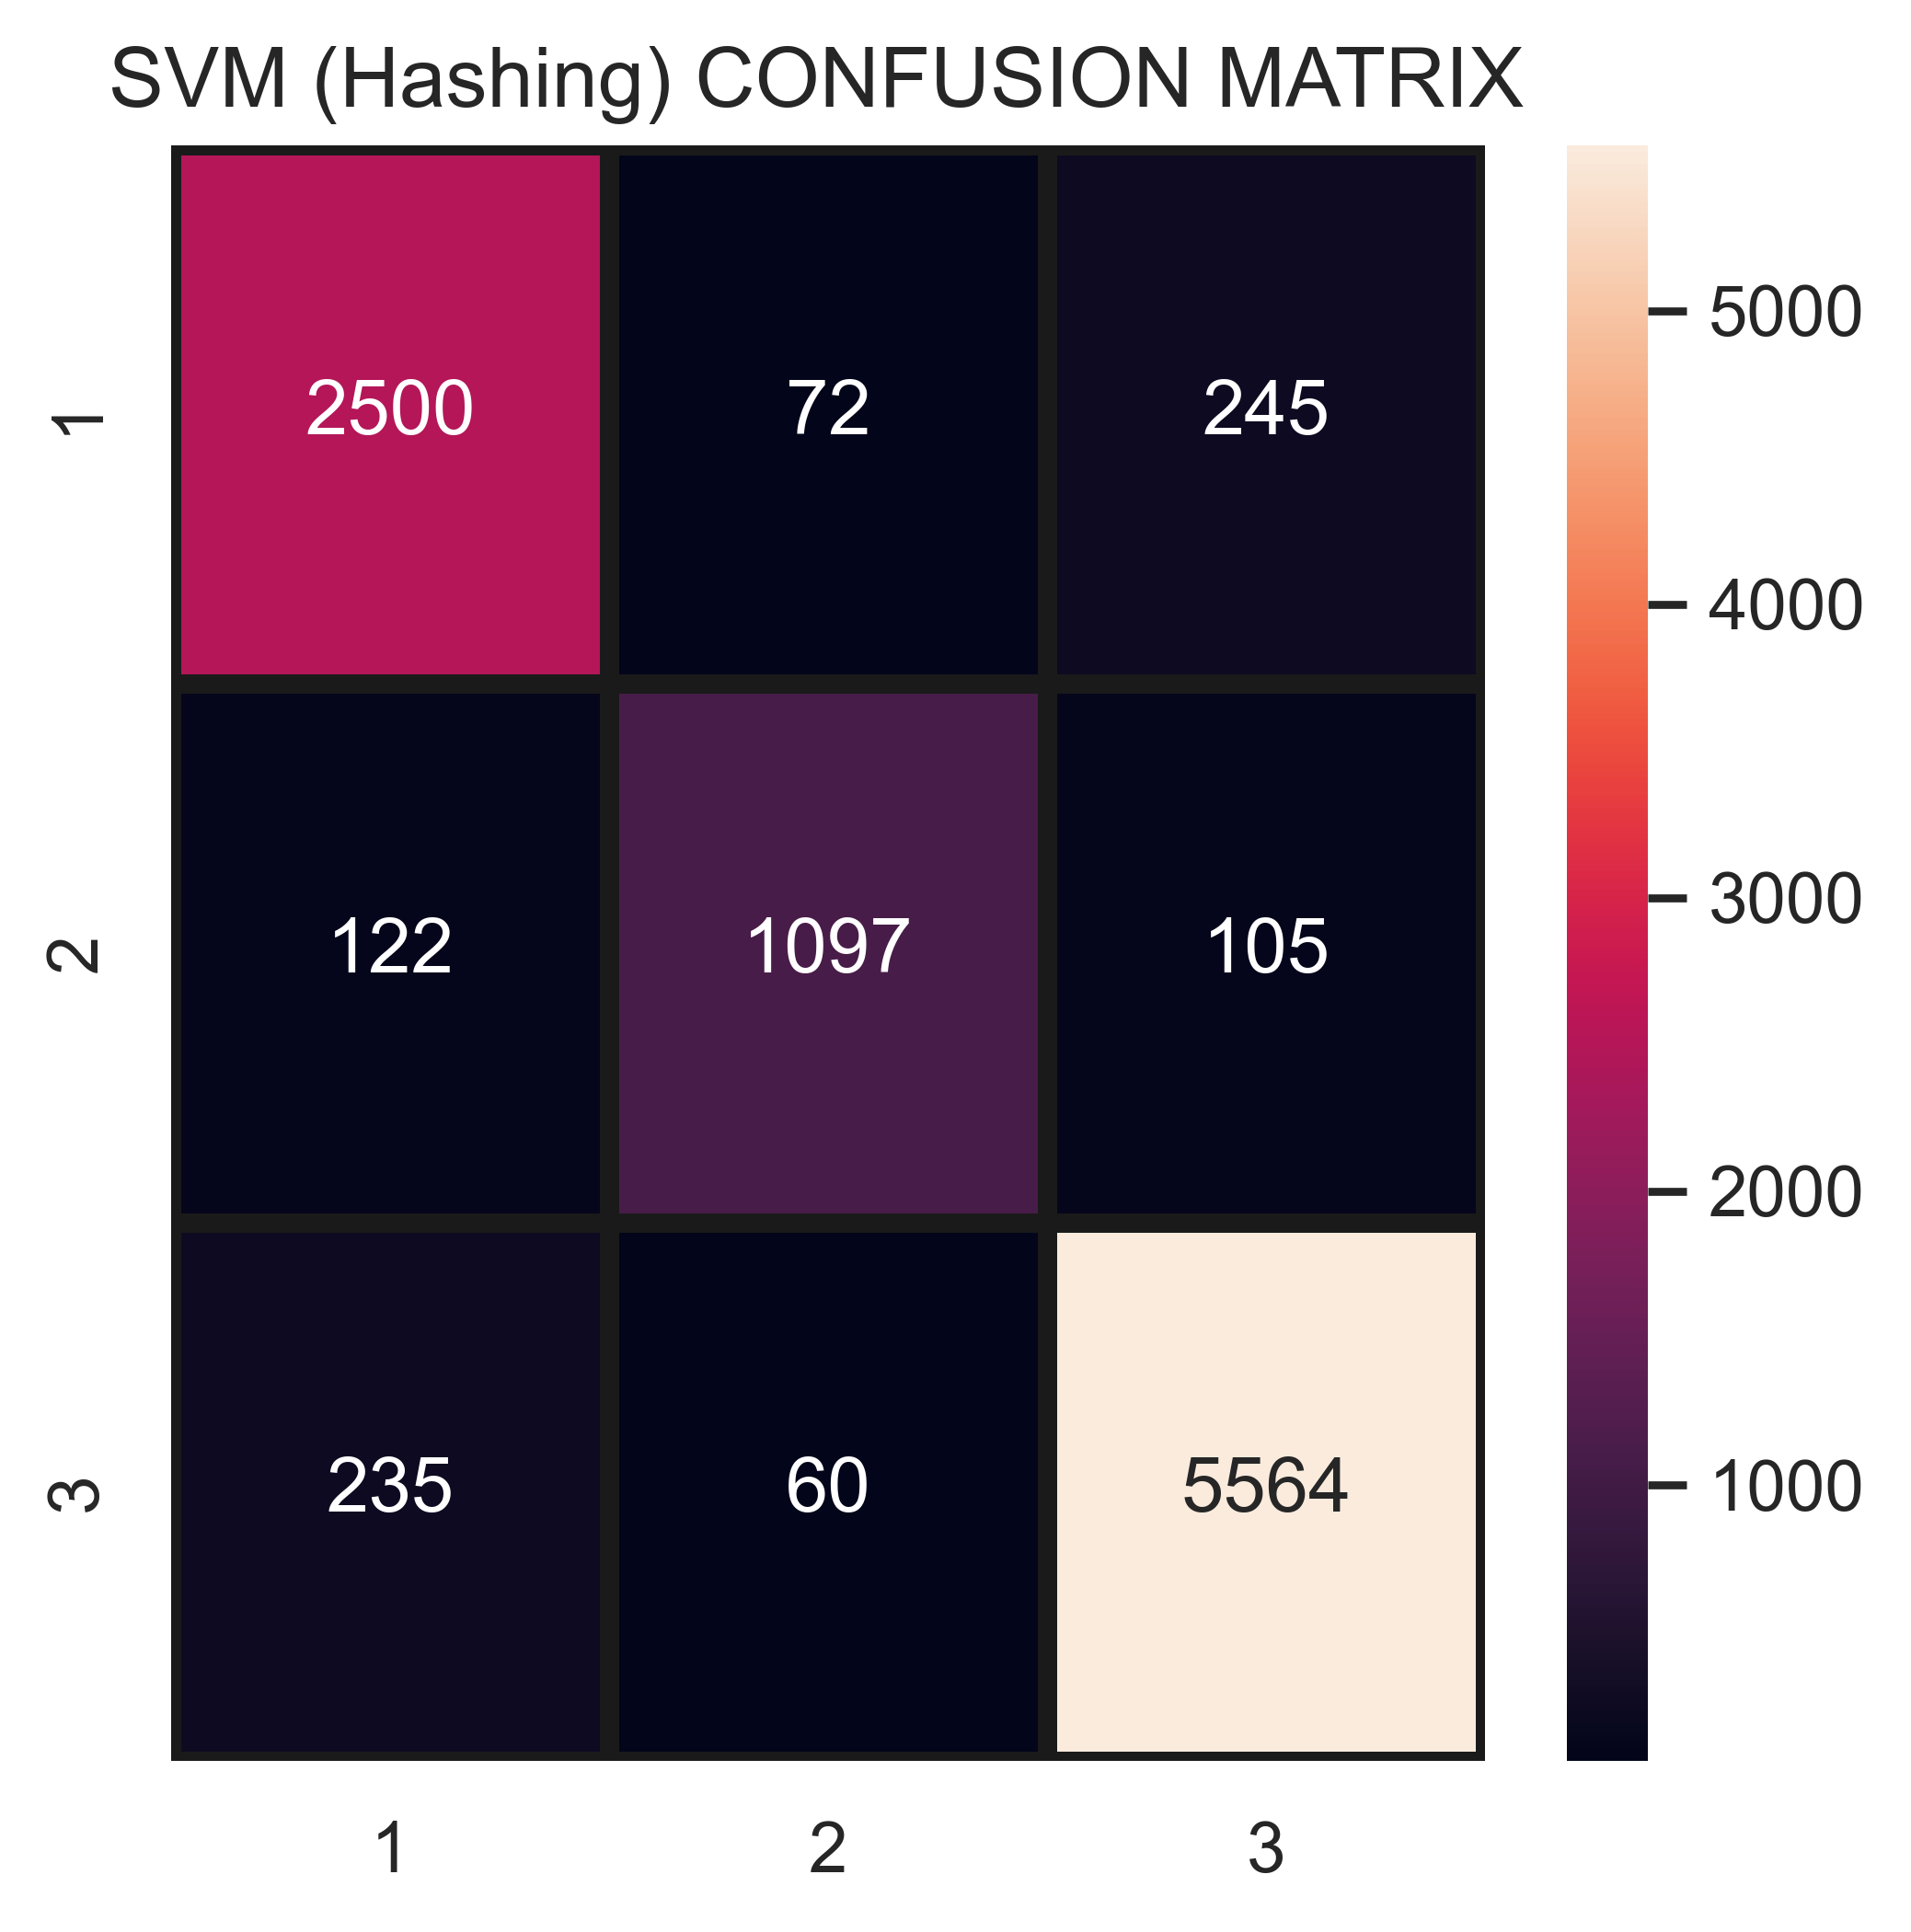

In [11]:
import pandas as pd
array = [[2500 ,  72,  245],
 [ 122 ,1097,  105],
 [ 235 ,  60, 5564]]

SVM = pd.DataFrame(array, index = [i for i in "123"],
                  columns = [i for i in "123"])

i=1
def plot_sub_sentiment(Airline,A):
    sns.set()
    #tmp = rfc.fit(X_train, y_train.ravel())
    sns.heatmap(Airline,annot=True,fmt = "d",linecolor="k",linewidths=3)
    plt.title(A+" CONFUSION MATRIX ",fontsize=13)

plt.figure(1,figsize=(4, 4),dpi=500)
plt.subplot(111) 
plot_sub_sentiment(SVM,'SVM (Hashing)')

plt.tight_layout(pad=0)
plt.savefig('conf1SVM.pdf')


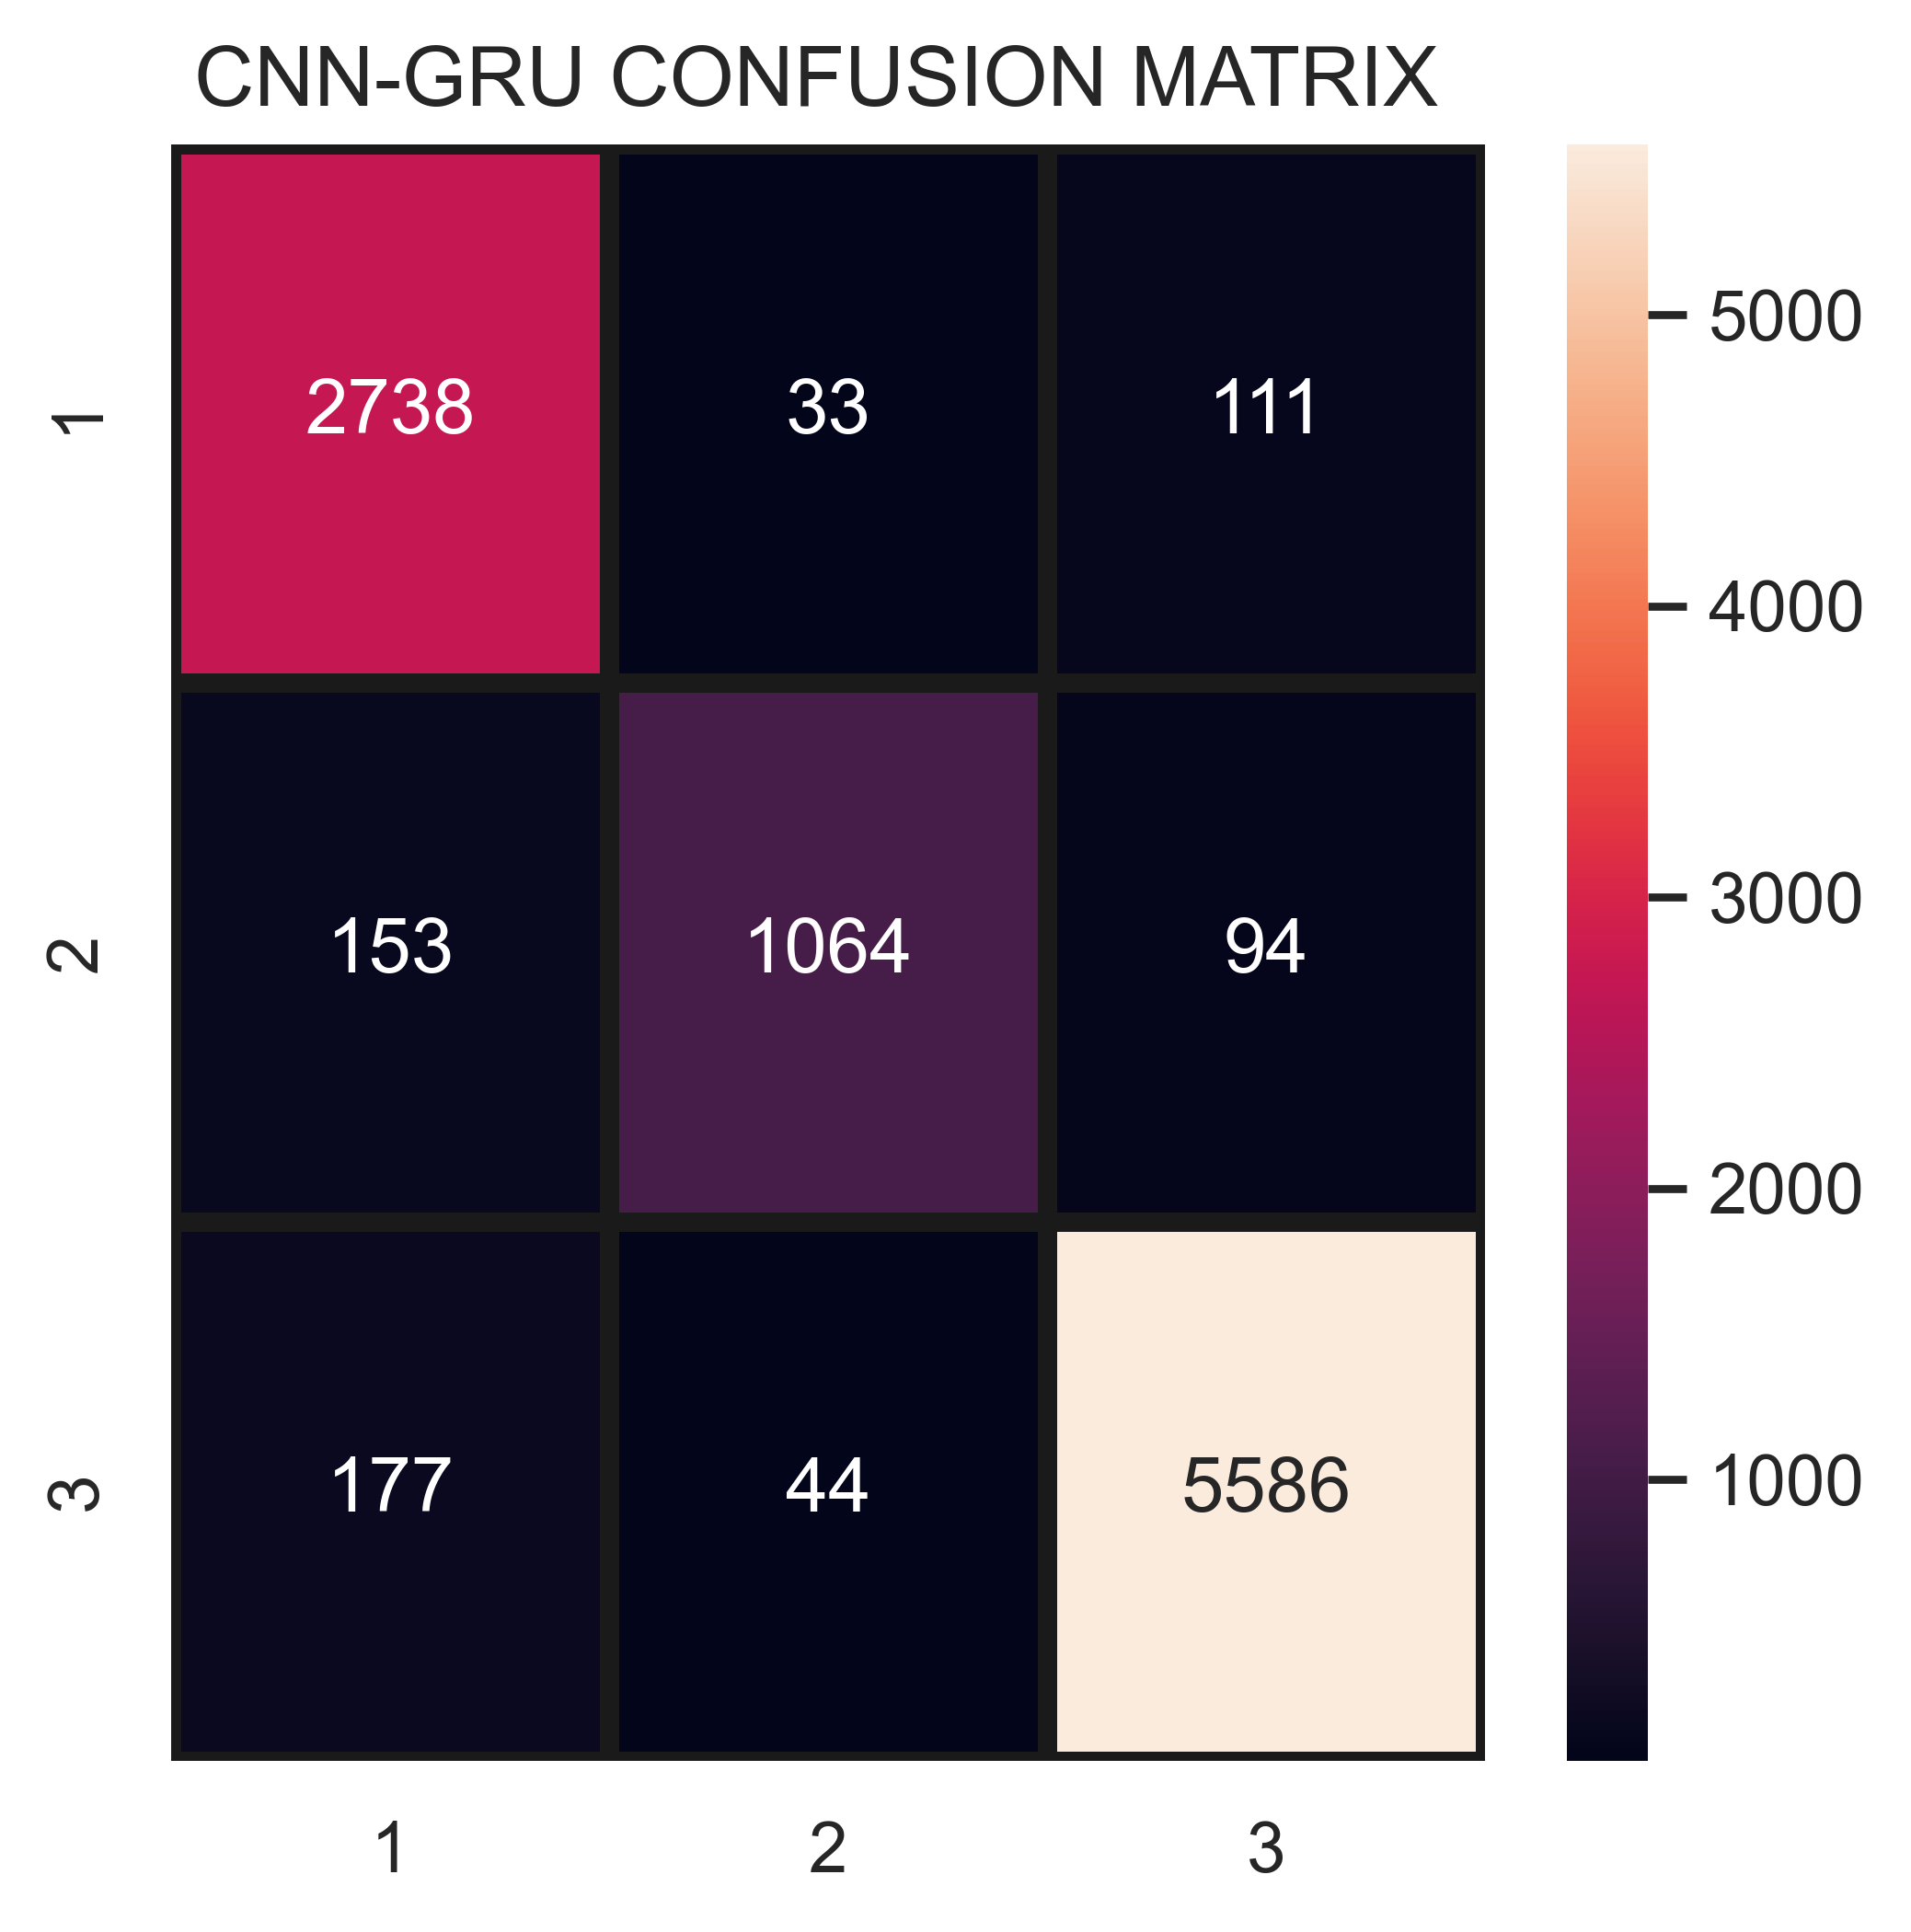

In [10]:


array1 = [[2738,   33 , 111],
 [ 153, 1064  , 94],
 [ 177 ,  44 ,5586]]
CNG = pd.DataFrame(array1, index = [i for i in "123"],
                  columns = [i for i in "123"])



i=1
def plot_sub_sentiment(Airline,A):
    sns.set()
    #tmp = rfc.fit(X_train, y_train.ravel())
    sns.heatmap(Airline,annot=True,fmt = "d",linecolor="k",linewidths=3)
    plt.title(A+" CONFUSION MATRIX ",fontsize=13)

plt.figure(1,figsize=(4, 4),dpi=500)
plt.subplot(111)
plot_sub_sentiment(CNG,'CNN-GRU')

plt.tight_layout(pad=0)
plt.savefig('conf1GRUCNN.pdf')
